In [14]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
#plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
plt.rcParams['font.family'] = 'NanumGothic'
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [3]:
path = '~/workplace/datas/energy/'
#path = '~/Desktop/workplace/datas/energy/'

In [4]:
train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [5]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

In [6]:
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [7]:
X.shape, y.shape, X_test.shape, y_test.shape

((546336, 13), (546336,), (2016, 13), (2016,))

# mRMR

In [8]:
#mRMR
from mrmr import mrmr_classif, mrmr_regression
selected_features = mrmr_regression(X=X, y=y, K=15, return_scores=True)

100%|███████████████████████████████████████████| 13/13 [00:12<00:00,  1.07it/s]


In [9]:
selected_features

(['Hour',
  '적설(cm)',
  '일조(hr)',
  '풍속(m/s)',
  'Year',
  '습도(%)',
  '기온(°C)',
  '일사(MJ/m2)',
  'Day',
  '현지기압(hPa)',
  'Month',
  '지면온도(°C)',
  '강수량(mm)'],
 Year          2908.459627
 Month         1639.148897
 Day            164.969512
 Hour         66378.239550
 기온(°C)        3948.509000
 풍속(m/s)      22671.733192
 습도(%)        25212.169310
 현지기압(hPa)     3293.722139
 지면온도(°C)       847.024560
 강수량(mm)         45.675827
 적설(cm)       42893.801053
 일조(hr)       12483.013488
 일사(MJ/m2)     6379.852491
 dtype: float64,
                Year     Month       Day      Hour    기온(°C)   풍속(m/s)  \
 Year       0.001000  0.001000  0.001000  0.001000  0.001000  0.020088   
 Month      0.098493  0.001000  0.018329  0.001000  0.268855  0.139086   
 Day        0.015768  0.001000  0.001000  0.001000  0.014293  0.011434   
 Hour       0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
 기온(°C)     0.070079  0.001000  0.001000  0.133693  0.001000  0.001606   
 풍속(m/s)    0.001000  0.001000

In [10]:
mrmr = []

for i , j in enumerate(selected_features[0]):
    mrmr.append([(i+1),j])

In [11]:
mrmr = pd.DataFrame(mrmr, columns=['rank', 'features'])

# SAHP

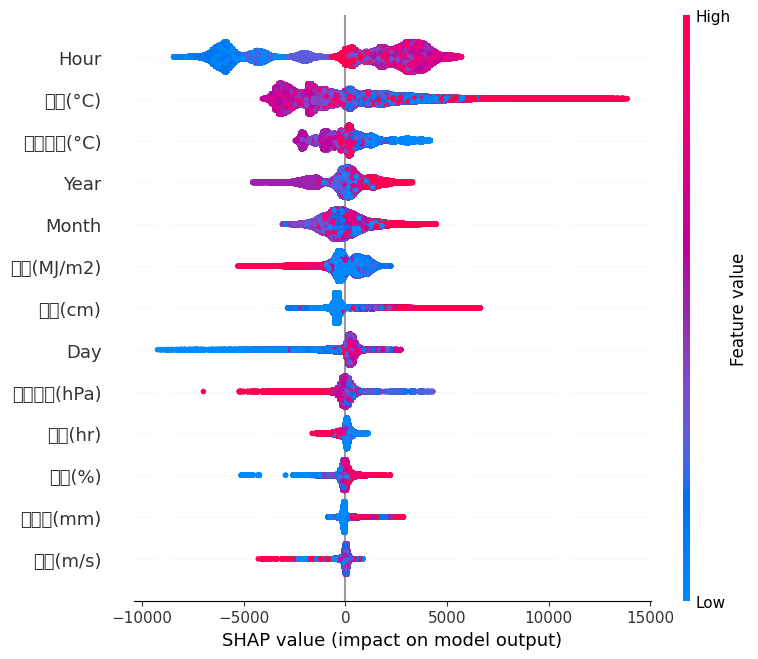

In [12]:
import shap
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X, y)


explainer = shap.Explainer(model)



shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

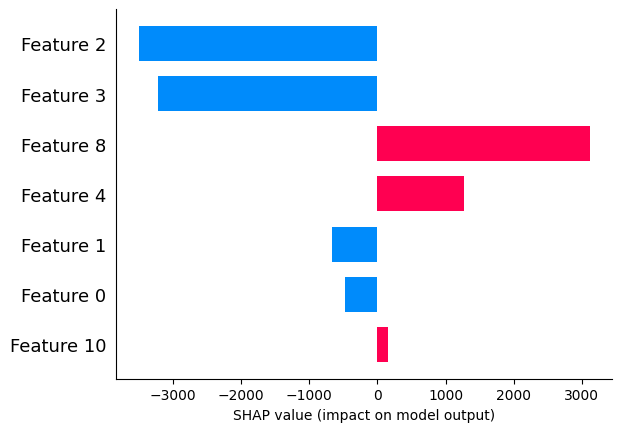

In [13]:
shap.bar_plot(shap_values[0])

In [15]:
import numpy as np

# Calculate mean absolute SHAP values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print feature importance
shap = []
for feature_name, mean_value in zip(X.keys(), mean_shap_values):
    print(f"{feature_name}: {mean_value}")
    shap.append([mean_value,feature_name])


Year: 845.3539762089192
Month: 756.901857107821
Day: 485.22956731564994
Hour: 3393.7727346934494
기온(°C): 2293.5181724824206
풍속(m/s): 97.46997985704144
습도(%): 194.71394678550735
현지기압(hPa): 232.39807080586172
지면온도(°C): 964.3186486055697
강수량(mm): 165.10057191522782
적설(cm): 651.8193713115915
일조(hr): 198.27233434459652
일사(MJ/m2): 700.3101475161301


In [16]:
shap = pd.DataFrame(shap, columns=['value', 'features'])

In [17]:
shap.sort_values('value', ascending=False, inplace=True)

In [18]:
shap['rank'] = [i for i in range(1, len(shap) + 1)]

In [19]:
shap.rename(columns={'rank':'shap_rank'}, inplace=True)

In [20]:
mrmr

,rank,features
0,1,Hour
1,2,적설(cm)
2,3,일조(hr)
3,4,풍속(m/s)
4,5,Year
5,6,습도(%)
6,7,기온(°C)
7,8,일사(MJ/m2)
8,9,Day
9,10,현지기압(hPa)


In [21]:
mrmr.set_index(['features'], inplace=True)
shap.set_index(['features'], inplace=True)

In [22]:
shap

,value,shap_rank
features,,
Hour,3393.772735,1
기온(°C),2293.518172,2
지면온도(°C),964.318649,3
Year,845.353976,4
Month,756.901857,5
일사(MJ/m2),700.310148,6
적설(cm),651.819371,7
Day,485.229567,8
현지기압(hPa),232.398071,9


In [23]:
merge_df = pd.merge(mrmr, shap, left_index=True, right_index=True)
merge_df.drop('value', axis=1, inplace=True)

In [24]:
merge_df['sum'] = (merge_df['rank'] ** 2) + (merge_df['shap_rank'] **2)

In [25]:
merge_df.sort_values('sum', ascending=True, inplace=True)

In [26]:
merge_df

,rank,shap_rank,sum
features,,,
Hour,1,1,2
Year,5,4,41
적설(cm),2,7,53
기온(°C),7,2,53
일사(MJ/m2),8,6,100
일조(hr),3,10,109
Day,9,8,145
Month,11,5,146
지면온도(°C),12,3,153


# 인덱스 순위

In [27]:
merge_df.index

Index(['Hour', 'Year', '적설(cm)', '기온(°C)', '일사(MJ/m2)', '일조(hr)', 'Day',
       'Month', '지면온도(°C)', '습도(%)', '현지기압(hPa)', '풍속(m/s)', '강수량(mm)'],
      dtype='object', name='features')

In [60]:
X = X[merge_df.index[:-7]]
X

,Hour,Year,적설(cm),기온(°C),일사(MJ/m2),일조(hr)
2018-01-01 00:00:00,0,2018,0.034737,-1.298947,0.0,0.0
2018-01-01 00:05:00,0,2018,0.034737,-1.327281,0.0,0.0
2018-01-01 00:10:00,0,2018,0.034737,-1.355614,0.0,0.0
2018-01-01 00:15:00,0,2018,0.034737,-1.383947,0.0,0.0
2018-01-01 00:20:00,0,2018,0.034737,-1.412281,0.0,0.0
...,...,...,...,...,...,...
2023-03-12 23:35:00,23,2023,0.011491,1.765000,0.0,0.0
2023-03-12 23:40:00,23,2023,0.011930,1.720000,0.0,0.0
2023-03-12 23:45:00,23,2023,0.012368,1.675000,0.0,0.0
2023-03-12 23:50:00,23,2023,0.012807,1.630000,0.0,0.0


In [61]:
X_test = X_test.reindex(columns=merge_df.index)

X_test = X_test.iloc[:, :-7]

In [62]:
X.shape, X_test.shape, y.shape, y_test.shape

((546336, 6), (2016, 6), (546336,), (2016,))

# XGBoost

In [63]:
import xgboost as xgb


dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test, label=y_test)


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mape',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 0.01w, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    bst = xgb.train(params, dtrain)
    preds = bst.predict(xgb.DMatrix(X_test))
    mape = mean_absolute_percentage_error(y_test, preds)
    print("MAPE: {}".format(mape))
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

print(study.best_trial)
print(study.best_value)

[I 2023-07-18 22:16:32,415] A new study created in memory with name: no-name-46c25116-5a56-42e6-ab80-7d377b83e721
[I 2023-07-18 22:16:32,766] Trial 0 finished with value: 0.5693128816389499 and parameters: {'max_depth': 5, 'eta': 0.05221347916951655, 'gamma': 0.31251242352598413, 'subsample': 0.4613296814441268, 'colsample_bytree': 0.12616024324416944}. Best is trial 0 with value: 0.5693128816389499.


MAPE: 0.5693128816389499


[I 2023-07-18 22:16:32,972] Trial 1 finished with value: 0.3678436490633105 and parameters: {'max_depth': 2, 'eta': 0.08831446566455202, 'gamma': 0.032553810082529215, 'subsample': 0.4089313451018455, 'colsample_bytree': 0.4727786323480523}. Best is trial 1 with value: 0.3678436490633105.


MAPE: 0.3678436490633105


[I 2023-07-18 22:16:33,620] Trial 2 finished with value: 0.2599866566088408 and parameters: {'max_depth': 6, 'eta': 0.12327956377988351, 'gamma': 0.17570124906606782, 'subsample': 0.9665007131786437, 'colsample_bytree': 0.8975441486071919}. Best is trial 2 with value: 0.2599866566088408.


MAPE: 0.2599866566088408


[I 2023-07-18 22:16:33,939] Trial 3 finished with value: 0.15406311904175327 and parameters: {'max_depth': 5, 'eta': 0.15444186217455022, 'gamma': 0.012734168479631353, 'subsample': 0.24996756166026646, 'colsample_bytree': 0.4171074237041613}. Best is trial 3 with value: 0.15406311904175327.


MAPE: 0.15406311904175327


[I 2023-07-18 22:16:34,770] Trial 4 finished with value: 0.7901620024147552 and parameters: {'max_depth': 9, 'eta': 0.022945971231758806, 'gamma': 0.022108807015503672, 'subsample': 0.4652999835489061, 'colsample_bytree': 0.9081972742217752}. Best is trial 3 with value: 0.15406311904175327.


MAPE: 0.7901620024147552


[I 2023-07-18 22:16:35,173] Trial 5 finished with value: 0.4033686688710488 and parameters: {'max_depth': 4, 'eta': 0.08203011151759519, 'gamma': 0.22269532008570356, 'subsample': 0.5692781750925263, 'colsample_bytree': 0.5437136849954937}. Best is trial 3 with value: 0.15406311904175327.


MAPE: 0.4033686688710488


[I 2023-07-18 22:16:35,594] Trial 6 finished with value: 0.07673952072624328 and parameters: {'max_depth': 10, 'eta': 0.9971804335752631, 'gamma': 0.406524480134707, 'subsample': 0.7746840628479826, 'colsample_bytree': 0.2655966862978068}. Best is trial 6 with value: 0.07673952072624328.


MAPE: 0.07673952072624328


[I 2023-07-18 22:16:35,935] Trial 7 finished with value: 0.5420417298813314 and parameters: {'max_depth': 9, 'eta': 0.05658324029050398, 'gamma': 0.032869102573768384, 'subsample': 0.7117836077107167, 'colsample_bytree': 0.12710241876500916}. Best is trial 6 with value: 0.07673952072624328.


MAPE: 0.5420417298813314


[I 2023-07-18 22:16:36,269] Trial 8 finished with value: 0.5044477081098545 and parameters: {'max_depth': 6, 'eta': 0.06291009740512875, 'gamma': 0.03987574379972768, 'subsample': 0.6081934227261035, 'colsample_bytree': 0.12796974427229887}. Best is trial 6 with value: 0.07673952072624328.


MAPE: 0.5044477081098545


[I 2023-07-18 22:16:36,490] Trial 9 finished with value: 0.3544780867769765 and parameters: {'max_depth': 2, 'eta': 0.09144116601121224, 'gamma': 0.11354936466186968, 'subsample': 0.8321905248824629, 'colsample_bytree': 0.3849525638418211}. Best is trial 6 with value: 0.07673952072624328.


MAPE: 0.3544780867769765


[I 2023-07-18 22:16:37,644] Trial 10 finished with value: 0.07385875730801104 and parameters: {'max_depth': 10, 'eta': 0.9536501127048126, 'gamma': 0.6834770628541257, 'subsample': 0.9733998512963117, 'colsample_bytree': 0.7046456772230515}. Best is trial 10 with value: 0.07385875730801104.


MAPE: 0.07385875730801104


[I 2023-07-18 22:16:38,756] Trial 11 finished with value: 0.08665233164433474 and parameters: {'max_depth': 10, 'eta': 0.9680121886730295, 'gamma': 0.9356143971607723, 'subsample': 0.9736044783472175, 'colsample_bytree': 0.7150450749209412}. Best is trial 10 with value: 0.07385875730801104.


MAPE: 0.08665233164433474


[I 2023-07-18 22:16:39,663] Trial 12 finished with value: 0.0729599568644704 and parameters: {'max_depth': 8, 'eta': 0.8379772999182046, 'gamma': 0.6050748349548197, 'subsample': 0.8303140233174521, 'colsample_bytree': 0.6966570048952541}. Best is trial 12 with value: 0.0729599568644704.


MAPE: 0.0729599568644704


[I 2023-07-18 22:16:40,511] Trial 13 finished with value: 0.07142974010534456 and parameters: {'max_depth': 8, 'eta': 0.4879154155236852, 'gamma': 0.9443403320942797, 'subsample': 0.8794449858400117, 'colsample_bytree': 0.6879795065833342}. Best is trial 13 with value: 0.07142974010534456.


MAPE: 0.07142974010534456


[I 2023-07-18 22:16:41,337] Trial 14 finished with value: 0.07064233550541783 and parameters: {'max_depth': 8, 'eta': 0.4021715625560899, 'gamma': 0.5707154990265935, 'subsample': 0.8323150536740482, 'colsample_bytree': 0.6761389223102149}. Best is trial 14 with value: 0.07064233550541783.


MAPE: 0.07064233550541783


[I 2023-07-18 22:16:42,006] Trial 15 finished with value: 0.07090610883859796 and parameters: {'max_depth': 7, 'eta': 0.4483110003055978, 'gamma': 0.886409023557489, 'subsample': 0.6982593486714307, 'colsample_bytree': 0.6411393749931059}. Best is trial 14 with value: 0.07064233550541783.


MAPE: 0.07090610883859796


[I 2023-07-18 22:16:42,637] Trial 16 finished with value: 0.07243988400477011 and parameters: {'max_depth': 7, 'eta': 0.323324554029759, 'gamma': 0.43633560961173207, 'subsample': 0.7093359163815302, 'colsample_bytree': 0.600167785659895}. Best is trial 14 with value: 0.07064233550541783.


MAPE: 0.07243988400477011


[I 2023-07-18 22:16:43,369] Trial 17 finished with value: 0.08376054789053955 and parameters: {'max_depth': 7, 'eta': 0.2686982495712599, 'gamma': 0.5604192659475413, 'subsample': 0.6663788625247742, 'colsample_bytree': 0.8498688325813744}. Best is trial 14 with value: 0.07064233550541783.


MAPE: 0.08376054789053955


[I 2023-07-18 22:16:43,707] Trial 18 finished with value: 0.1067923701006107 and parameters: {'max_depth': 3, 'eta': 0.21882383286110774, 'gamma': 0.2646627993540771, 'subsample': 0.7635147108047252, 'colsample_bytree': 0.8042241220568367}. Best is trial 14 with value: 0.07064233550541783.


MAPE: 0.1067923701006107


[I 2023-07-18 22:16:44,425] Trial 19 finished with value: 0.06712115871354075 and parameters: {'max_depth': 7, 'eta': 0.4620208949322914, 'gamma': 0.9648680280107892, 'subsample': 0.6516951677387585, 'colsample_bytree': 0.9582222679367502}. Best is trial 19 with value: 0.06712115871354075.


MAPE: 0.06712115871354075


[I 2023-07-18 22:16:45,265] Trial 20 finished with value: 0.07092287164842088 and parameters: {'max_depth': 8, 'eta': 0.5271822341827853, 'gamma': 0.4102627391317111, 'subsample': 0.6213810685522526, 'colsample_bytree': 0.9743257829577932}. Best is trial 19 with value: 0.06712115871354075.


MAPE: 0.07092287164842088


[I 2023-07-18 22:16:45,993] Trial 21 finished with value: 0.07058960497036403 and parameters: {'max_depth': 7, 'eta': 0.4368431705192169, 'gamma': 0.8488240425717396, 'subsample': 0.7473450688210866, 'colsample_bytree': 0.7934643365294147}. Best is trial 19 with value: 0.06712115871354075.


MAPE: 0.07058960497036403


[I 2023-07-18 22:16:46,746] Trial 22 finished with value: 0.1059579989045576 and parameters: {'max_depth': 7, 'eta': 0.21077346730462154, 'gamma': 0.6273382570043373, 'subsample': 0.8673560116574689, 'colsample_bytree': 0.9914104579882437}. Best is trial 19 with value: 0.06712115871354075.


MAPE: 0.1059579989045576


[I 2023-07-18 22:16:47,359] Trial 23 finished with value: 0.07383491425123032 and parameters: {'max_depth': 6, 'eta': 0.3420264489919938, 'gamma': 0.9841533312266227, 'subsample': 0.7834589893899584, 'colsample_bytree': 0.7986675628385033}. Best is trial 19 with value: 0.06712115871354075.


MAPE: 0.07383491425123032


[I 2023-07-18 22:16:48,270] Trial 24 finished with value: 0.06670297658644873 and parameters: {'max_depth': 9, 'eta': 0.5828283393073411, 'gamma': 0.4769255471132015, 'subsample': 0.6502784215817606, 'colsample_bytree': 0.7890398178252803}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.06670297658644873


[I 2023-07-18 22:16:49,151] Trial 25 finished with value: 0.06893263278208739 and parameters: {'max_depth': 9, 'eta': 0.6234915171759792, 'gamma': 0.3660612987584986, 'subsample': 0.5447168245269765, 'colsample_bytree': 0.7845130818299879}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.06893263278208739


[I 2023-07-18 22:16:50,044] Trial 26 finished with value: 0.06967550199300408 and parameters: {'max_depth': 9, 'eta': 0.6293199075149022, 'gamma': 0.16620292876459794, 'subsample': 0.5128226664778043, 'colsample_bytree': 0.9345277735558736}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.06967550199300408


[I 2023-07-18 22:16:50,944] Trial 27 finished with value: 0.07101282475207522 and parameters: {'max_depth': 9, 'eta': 0.624395285954721, 'gamma': 0.3396318409266137, 'subsample': 0.6054649144779347, 'colsample_bytree': 0.8789609643487132}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07101282475207522


[I 2023-07-18 22:16:51,833] Trial 28 finished with value: 0.07022504740326005 and parameters: {'max_depth': 9, 'eta': 0.6497630787435016, 'gamma': 0.4244979487063731, 'subsample': 0.5389113316152717, 'colsample_bytree': 0.7655211434994978}. Best is trial 24 with value: 0.06670297658644873.
[I 2023-07-18 22:16:52,015] Trial 29 finished with value: 0.08613575331844242 and parameters: {'max_depth': 1, 'eta': 0.2775300335121758, 'gamma': 0.3005096046373019, 'subsample': 0.6523631752761214, 'colsample_bytree': 0.8479946198301982}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07022504740326005
MAPE: 0.08613575331844242


[I 2023-07-18 22:16:52,908] Trial 30 finished with value: 0.07256510858235908 and parameters: {'max_depth': 10, 'eta': 0.6878869504875593, 'gamma': 0.2447949223263236, 'subsample': 0.38025492172716524, 'colsample_bytree': 0.9456053164496102}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07256510858235908


[I 2023-07-18 22:16:53,802] Trial 31 finished with value: 0.07135059486448651 and parameters: {'max_depth': 9, 'eta': 0.620101152502053, 'gamma': 0.16077905510719334, 'subsample': 0.5114544412669503, 'colsample_bytree': 0.9283325868544278}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07135059486448651


[I 2023-07-18 22:16:54,591] Trial 32 finished with value: 0.07452950375724009 and parameters: {'max_depth': 8, 'eta': 0.7322592599163479, 'gamma': 0.3478972566697617, 'subsample': 0.5002636499028221, 'colsample_bytree': 0.9926917303393193}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07452950375724009


[I 2023-07-18 22:16:55,492] Trial 33 finished with value: 0.07436838082417242 and parameters: {'max_depth': 9, 'eta': 0.5205657528633088, 'gamma': 0.17423907682446266, 'subsample': 0.5631684717162976, 'colsample_bytree': 0.9207352700031427}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07436838082417242


[I 2023-07-18 22:16:56,422] Trial 34 finished with value: 0.07184673819806689 and parameters: {'max_depth': 10, 'eta': 0.382449954957654, 'gamma': 0.5057161539198166, 'subsample': 0.4367224858720593, 'colsample_bytree': 0.8586714824765203}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07184673819806689


[I 2023-07-18 22:16:56,869] Trial 35 finished with value: 0.07033414048973502 and parameters: {'max_depth': 5, 'eta': 0.7475240708391477, 'gamma': 0.21173636983045926, 'subsample': 0.375050637997809, 'colsample_bytree': 0.75028949302959}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07033414048973502


[I 2023-07-18 22:16:57,649] Trial 36 finished with value: 0.19157247502406563 and parameters: {'max_depth': 8, 'eta': 0.14833858674302897, 'gamma': 0.7129350322601898, 'subsample': 0.4728313915176593, 'colsample_bytree': 0.9005066002372714}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.19157247502406563


[I 2023-07-18 22:16:58,103] Trial 37 finished with value: 0.07125224232612289 and parameters: {'max_depth': 4, 'eta': 0.5475556845684867, 'gamma': 0.3157199988839372, 'subsample': 0.5438336664490847, 'colsample_bytree': 0.9544877727313218}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07125224232612289


[I 2023-07-18 22:16:58,742] Trial 38 finished with value: 0.07261149067310968 and parameters: {'max_depth': 6, 'eta': 0.3519280569598211, 'gamma': 0.48281836545434736, 'subsample': 0.590618791059131, 'colsample_bytree': 0.8381195883552275}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07261149067310968


[I 2023-07-18 22:16:59,676] Trial 39 finished with value: 0.07270434501686623 and parameters: {'max_depth': 9, 'eta': 0.7069542864639687, 'gamma': 0.12852917350597398, 'subsample': 0.6427685901187689, 'colsample_bytree': 0.9285244448351221}. Best is trial 24 with value: 0.06670297658644873.


MAPE: 0.07270434501686623


[I 2023-07-18 22:17:00,685] Trial 40 finished with value: 0.06629573944257047 and parameters: {'max_depth': 10, 'eta': 0.4648911242810308, 'gamma': 0.21272272105246945, 'subsample': 0.575504257600023, 'colsample_bytree': 0.8916910396488082}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.06629573944257047


[I 2023-07-18 22:17:01,724] Trial 41 finished with value: 0.07064126717471836 and parameters: {'max_depth': 10, 'eta': 0.47076983789123833, 'gamma': 0.08469731469128787, 'subsample': 0.5741847849319381, 'colsample_bytree': 0.891008271132744}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07064126717471836


[I 2023-07-18 22:17:02,753] Trial 42 finished with value: 0.07818107589283003 and parameters: {'max_depth': 10, 'eta': 0.885775367826261, 'gamma': 0.20782017826573793, 'subsample': 0.6746594167954465, 'colsample_bytree': 0.823598155370255}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07818107589283003


[I 2023-07-18 22:17:03,710] Trial 43 finished with value: 0.06778236154716873 and parameters: {'max_depth': 9, 'eta': 0.5598086803590714, 'gamma': 0.2738160142050446, 'subsample': 0.6265123370527858, 'colsample_bytree': 0.9984501530448928}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.06778236154716873


[I 2023-07-18 22:17:04,618] Trial 44 finished with value: 0.07046919786626302 and parameters: {'max_depth': 9, 'eta': 0.4080450188759677, 'gamma': 0.36338328591396823, 'subsample': 0.6317276464011133, 'colsample_bytree': 0.990592453293906}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07046919786626302


[I 2023-07-18 22:17:05,655] Trial 45 finished with value: 0.07084983497643345 and parameters: {'max_depth': 10, 'eta': 0.8748927875838682, 'gamma': 0.27622505523367913, 'subsample': 0.6065552487125626, 'colsample_bytree': 0.875544188932952}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07084983497643345


[I 2023-07-18 22:17:06,430] Trial 46 finished with value: 0.07745840285332561 and parameters: {'max_depth': 8, 'eta': 0.29085734266357466, 'gamma': 0.6637120025859893, 'subsample': 0.6821633188011909, 'colsample_bytree': 0.7688683776488616}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07745840285332561


[I 2023-07-18 22:17:07,482] Trial 47 finished with value: 0.07389644574034442 and parameters: {'max_depth': 10, 'eta': 0.9949552443647152, 'gamma': 0.4977294622441319, 'subsample': 0.722145883620636, 'colsample_bytree': 0.8948799549181317}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07389644574034442


[I 2023-07-18 22:17:08,309] Trial 48 finished with value: 0.07225280559627456 and parameters: {'max_depth': 8, 'eta': 0.562850730369414, 'gamma': 0.4157112369958382, 'subsample': 0.5655230776828479, 'colsample_bytree': 0.9655887369310172}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07225280559627456


[I 2023-07-18 22:17:09,186] Trial 49 finished with value: 0.06827250848050871 and parameters: {'max_depth': 9, 'eta': 0.46773999628510937, 'gamma': 0.26620853347694906, 'subsample': 0.6636755639900788, 'colsample_bytree': 0.7427293842386969}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.06827250848050871


[I 2023-07-18 22:17:10,198] Trial 50 finished with value: 0.10385734176461113 and parameters: {'max_depth': 10, 'eta': 0.21105766917421467, 'gamma': 0.24618837431177729, 'subsample': 0.6632523934166809, 'colsample_bytree': 0.852335757585559}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.10385734176461113


[I 2023-07-18 22:17:11,086] Trial 51 finished with value: 0.07000285286316713 and parameters: {'max_depth': 9, 'eta': 0.45859858583644286, 'gamma': 0.3016260680984857, 'subsample': 0.5845628524774185, 'colsample_bytree': 0.7452926203098333}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07000285286316713


[I 2023-07-18 22:17:11,967] Trial 52 finished with value: 0.0746571538391741 and parameters: {'max_depth': 9, 'eta': 0.7866501588932188, 'gamma': 0.35896722751817717, 'subsample': 0.6352281486354607, 'colsample_bytree': 0.7999273994134822}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.0746571538391741


[I 2023-07-18 22:17:12,747] Trial 53 finished with value: 0.07015999421887442 and parameters: {'max_depth': 8, 'eta': 0.38144537304021847, 'gamma': 0.7384724822089641, 'subsample': 0.7079103405247422, 'colsample_bytree': 0.7281307816126226}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.07015999421887442


[I 2023-07-18 22:17:13,455] Trial 54 finished with value: 0.06990573855541074 and parameters: {'max_depth': 7, 'eta': 0.5335014854985973, 'gamma': 0.21017129893590486, 'subsample': 0.619114706822928, 'colsample_bytree': 0.9543087601654859}. Best is trial 40 with value: 0.06629573944257047.


MAPE: 0.06990573855541074


[I 2023-07-18 22:17:14,441] Trial 55 finished with value: 0.06549830334830808 and parameters: {'max_depth': 10, 'eta': 0.44016501724371226, 'gamma': 0.5611824325609004, 'subsample': 0.6869413801209276, 'colsample_bytree': 0.8254481685748188}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06549830334830808


[I 2023-07-18 22:17:15,392] Trial 56 finished with value: 0.07178739028114232 and parameters: {'max_depth': 10, 'eta': 0.33774379490057505, 'gamma': 0.5721280110025383, 'subsample': 0.7405356137033572, 'colsample_bytree': 0.8253837509233205}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07178739028114232


[I 2023-07-18 22:17:16,435] Trial 57 finished with value: 0.06902365050924061 and parameters: {'max_depth': 10, 'eta': 0.46259111152572435, 'gamma': 0.7743532962121131, 'subsample': 0.6861735923665487, 'colsample_bytree': 0.8984054899599972}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06902365050924061


[I 2023-07-18 22:17:17,374] Trial 58 finished with value: 0.08385791773008669 and parameters: {'max_depth': 9, 'eta': 0.2554906567911331, 'gamma': 0.8552034751203367, 'subsample': 0.7871101279941266, 'colsample_bytree': 0.9994137590419438}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.08385791773008669


[I 2023-07-18 22:17:18,390] Trial 59 finished with value: 0.07364615733742487 and parameters: {'max_depth': 10, 'eta': 0.41654623945092234, 'gamma': 0.6220600483858794, 'subsample': 0.6518524049543994, 'colsample_bytree': 0.8781939804327592}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07364615733742487


[I 2023-07-18 22:17:19,051] Trial 60 finished with value: 0.07158949111983556 and parameters: {'max_depth': 7, 'eta': 0.3412258227907991, 'gamma': 0.46958320064821896, 'subsample': 0.7324702584374067, 'colsample_bytree': 0.663031787721638}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07158949111983556


[I 2023-07-18 22:17:19,948] Trial 61 finished with value: 0.06776764786905089 and parameters: {'max_depth': 9, 'eta': 0.6178963489193874, 'gamma': 0.4141603727665202, 'subsample': 0.606592722333003, 'colsample_bytree': 0.7795442020968675}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06776764786905089


[I 2023-07-18 22:17:20,856] Trial 62 finished with value: 0.0690794955832044 and parameters: {'max_depth': 9, 'eta': 0.767211461451347, 'gamma': 0.5419963820313047, 'subsample': 0.6854292878011163, 'colsample_bytree': 0.7187856941422043}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0690794955832044


[I 2023-07-18 22:17:21,651] Trial 63 finished with value: 0.0689476633420848 and parameters: {'max_depth': 8, 'eta': 0.5525646783104218, 'gamma': 0.4051981000889176, 'subsample': 0.6075270677996799, 'colsample_bytree': 0.8196085344856012}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0689476633420848


[I 2023-07-18 22:17:22,545] Trial 64 finished with value: 0.06992654786418813 and parameters: {'max_depth': 9, 'eta': 0.46776865944673335, 'gamma': 0.7802460263785883, 'subsample': 0.7113958142704426, 'colsample_bytree': 0.7778866834746561}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06992654786418813


[I 2023-07-18 22:17:23,397] Trial 65 finished with value: 0.07132118895832898 and parameters: {'max_depth': 8, 'eta': 0.6221652567884816, 'gamma': 0.633091690710982, 'subsample': 0.6563850602502652, 'colsample_bytree': 0.9146869503372846}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07132118895832898


[I 2023-07-18 22:17:24,397] Trial 66 finished with value: 0.07470078893267018 and parameters: {'max_depth': 10, 'eta': 0.30624943116882075, 'gamma': 0.9700918190453646, 'subsample': 0.6288206575494166, 'colsample_bytree': 0.8614386693181806}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07470078893267018


[I 2023-07-18 22:17:25,324] Trial 67 finished with value: 0.06871172350150118 and parameters: {'max_depth': 9, 'eta': 0.8535891297080007, 'gamma': 0.2931759298624516, 'subsample': 0.5902882463345669, 'colsample_bytree': 0.8077795160105444}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06871172350150118


[I 2023-07-18 22:17:26,315] Trial 68 finished with value: 0.07194168335156914 and parameters: {'max_depth': 10, 'eta': 0.3934278313627129, 'gamma': 0.5422460898887514, 'subsample': 0.6958867233332878, 'colsample_bytree': 0.6995389192192958}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07194168335156914


[I 2023-07-18 22:17:26,751] Trial 69 finished with value: 0.07265801567382693 and parameters: {'max_depth': 4, 'eta': 0.4924127447138914, 'gamma': 0.46470701720312807, 'subsample': 0.5418104436064027, 'colsample_bytree': 0.9661648682113405}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07265801567382693


[I 2023-07-18 22:17:27,386] Trial 70 finished with value: 0.08824125082465988 and parameters: {'max_depth': 6, 'eta': 0.2526501316657913, 'gamma': 0.3890014529301328, 'subsample': 0.7507648194889021, 'colsample_bytree': 0.9238874134397195}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.08824125082465988


[I 2023-07-18 22:17:28,287] Trial 71 finished with value: 0.07282117229173875 and parameters: {'max_depth': 9, 'eta': 0.8277441558232147, 'gamma': 0.2727089567958679, 'subsample': 0.5957515113214562, 'colsample_bytree': 0.8091033631684312}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07282117229173875


[I 2023-07-18 22:17:29,184] Trial 72 finished with value: 0.06986671863743076 and parameters: {'max_depth': 9, 'eta': 0.6063270734364158, 'gamma': 0.308008655930232, 'subsample': 0.5784596401273407, 'colsample_bytree': 0.7539593076998623}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06986671863743076


[I 2023-07-18 22:17:29,714] Trial 73 finished with value: 0.07200962059363805 and parameters: {'max_depth': 5, 'eta': 0.7319016877163638, 'gamma': 0.321496906281117, 'subsample': 0.6583883015883089, 'colsample_bytree': 0.8351374561403675}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07200962059363805


[I 2023-07-18 22:17:30,617] Trial 74 finished with value: 0.06888964216498156 and parameters: {'max_depth': 9, 'eta': 0.6812601474860481, 'gamma': 0.4392580777424664, 'subsample': 0.623477662088287, 'colsample_bytree': 0.7873928759181171}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06888964216498156


[I 2023-07-18 22:17:31,436] Trial 75 finished with value: 0.07630757092318317 and parameters: {'max_depth': 8, 'eta': 0.8870723711948276, 'gamma': 0.23789405421840992, 'subsample': 0.5837187633802308, 'colsample_bytree': 0.8610688064638563}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07630757092318317


[I 2023-07-18 22:17:32,406] Trial 76 finished with value: 0.0683919776049732 and parameters: {'max_depth': 10, 'eta': 0.5777889764903886, 'gamma': 0.27655626144112605, 'subsample': 0.5264605255016088, 'colsample_bytree': 0.7374079596834241}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0683919776049732


[I 2023-07-18 22:17:33,366] Trial 77 finished with value: 0.07054657169105485 and parameters: {'max_depth': 10, 'eta': 0.5129532402067711, 'gamma': 0.3455201493206753, 'subsample': 0.5125545847646088, 'colsample_bytree': 0.7327168583616461}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07054657169105485


[I 2023-07-18 22:17:34,390] Trial 78 finished with value: 0.0725314880766621 and parameters: {'max_depth': 10, 'eta': 0.5779470116080919, 'gamma': 0.193085363486755, 'subsample': 0.5624969023153487, 'colsample_bytree': 0.9428925980773917}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0725314880766621


[I 2023-07-18 22:17:35,371] Trial 79 finished with value: 0.06995058327170235 and parameters: {'max_depth': 10, 'eta': 0.4213320419424533, 'gamma': 0.25999768634791165, 'subsample': 0.532972801222055, 'colsample_bytree': 0.7652040322236277}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06995058327170235


[I 2023-07-18 22:17:36,313] Trial 80 finished with value: 0.07012463651470331 and parameters: {'max_depth': 9, 'eta': 0.6820808478087621, 'gamma': 0.3976344749837073, 'subsample': 0.6431134142596533, 'colsample_bytree': 0.9072600830551137}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07012463651470331


[I 2023-07-18 22:17:37,215] Trial 81 finished with value: 0.07051931167857364 and parameters: {'max_depth': 9, 'eta': 0.8203692767053894, 'gamma': 0.29139728651138447, 'subsample': 0.6055042740162377, 'colsample_bytree': 0.8035763860528969}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07051931167857364


[I 2023-07-18 22:17:38,118] Trial 82 finished with value: 0.07100236578434989 and parameters: {'max_depth': 9, 'eta': 0.5770723166669246, 'gamma': 0.2767766518432072, 'subsample': 0.681202225761011, 'colsample_bytree': 0.7021791247376129}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07100236578434989


[I 2023-07-18 22:17:39,101] Trial 83 finished with value: 0.06836955896186829 and parameters: {'max_depth': 10, 'eta': 0.4906945373861354, 'gamma': 0.2377732681857366, 'subsample': 0.5553026086436527, 'colsample_bytree': 0.7801402390609233}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06836955896186829


[I 2023-07-18 22:17:40,005] Trial 84 finished with value: 0.07339314870456462 and parameters: {'max_depth': 10, 'eta': 0.3642975339288627, 'gamma': 0.2276345811673932, 'subsample': 0.4810705408879047, 'colsample_bytree': 0.6723293760267023}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07339314870456462


[I 2023-07-18 22:17:40,958] Trial 85 finished with value: 0.0711428102007144 and parameters: {'max_depth': 10, 'eta': 0.49621867326825403, 'gamma': 0.1890188932753842, 'subsample': 0.5267438195388975, 'colsample_bytree': 0.740197021365074}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0711428102007144


[I 2023-07-18 22:17:41,916] Trial 86 finished with value: 0.07035826373397155 and parameters: {'max_depth': 10, 'eta': 0.41968572681793553, 'gamma': 0.37316143000626684, 'subsample': 0.5639149611397165, 'colsample_bytree': 0.7748438841598144}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07035826373397155


[I 2023-07-18 22:17:42,919] Trial 87 finished with value: 0.07200543888452793 and parameters: {'max_depth': 10, 'eta': 0.32667205743718064, 'gamma': 0.33314501444596895, 'subsample': 0.6268062771747591, 'colsample_bytree': 0.8353964971852217}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07200543888452793


[I 2023-07-18 22:17:43,575] Trial 88 finished with value: 0.068958377598419 and parameters: {'max_depth': 7, 'eta': 0.6586718930447619, 'gamma': 0.24522107586185604, 'subsample': 0.7065329534160544, 'colsample_bytree': 0.6491845952265752}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.068958377598419


[I 2023-07-18 22:17:44,604] Trial 89 finished with value: 0.07196638372463168 and parameters: {'max_depth': 10, 'eta': 0.4384800821308486, 'gamma': 0.698465053387713, 'subsample': 0.6697473277940953, 'colsample_bytree': 0.8741401191475068}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07196638372463168


[I 2023-07-18 22:17:45,399] Trial 90 finished with value: 0.07050425309326248 and parameters: {'max_depth': 8, 'eta': 0.5129775264367422, 'gamma': 0.536695128422583, 'subsample': 0.5554485562109659, 'colsample_bytree': 0.7265071668850138}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07050425309326248


[I 2023-07-18 22:17:46,308] Trial 91 finished with value: 0.069935707725439 and parameters: {'max_depth': 9, 'eta': 0.912886198576142, 'gamma': 0.44354359404079313, 'subsample': 0.5982138696282098, 'colsample_bytree': 0.7865871112850754}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.069935707725439


[I 2023-07-18 22:17:47,220] Trial 92 finished with value: 0.06887858264041592 and parameters: {'max_depth': 9, 'eta': 0.7613540616713514, 'gamma': 0.30042044984354527, 'subsample': 0.5840093248930636, 'colsample_bytree': 0.8134809783551503}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06887858264041592


[I 2023-07-18 22:17:48,014] Trial 93 finished with value: 0.07731646502501227 and parameters: {'max_depth': 8, 'eta': 0.992996484443384, 'gamma': 0.22772153308882986, 'subsample': 0.615414578429292, 'colsample_bytree': 0.7547913215753048}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07731646502501227


[I 2023-07-18 22:17:48,953] Trial 94 finished with value: 0.0674514120457414 and parameters: {'max_depth': 9, 'eta': 0.5599180281613654, 'gamma': 0.2691116453047186, 'subsample': 0.6452406805397766, 'colsample_bytree': 0.8449021507379539}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0674514120457414


[I 2023-07-18 22:17:49,993] Trial 95 finished with value: 0.06856782320757573 and parameters: {'max_depth': 10, 'eta': 0.5703041789079187, 'gamma': 0.258226042464003, 'subsample': 0.6632000391230514, 'colsample_bytree': 0.8510298467351871}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06856782320757573


[I 2023-07-18 22:17:50,263] Trial 96 finished with value: 0.07811656773434476 and parameters: {'max_depth': 2, 'eta': 0.46517981269728165, 'gamma': 0.3298644745926296, 'subsample': 0.6320099881347798, 'colsample_bytree': 0.9712219783505527}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07811656773434476


[I 2023-07-18 22:17:51,189] Trial 97 finished with value: 0.07291706161615227 and parameters: {'max_depth': 9, 'eta': 0.6423933076413362, 'gamma': 0.4998191830815397, 'subsample': 0.6440984863016596, 'colsample_bytree': 0.9453739589794261}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07291706161615227


[I 2023-07-18 22:17:51,536] Trial 98 finished with value: 0.07829367427921605 and parameters: {'max_depth': 3, 'eta': 0.3564569483591181, 'gamma': 0.6105969852831257, 'subsample': 0.7280529050224515, 'colsample_bytree': 0.8938971416062796}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07829367427921605


[I 2023-07-18 22:17:52,602] Trial 99 finished with value: 0.06913367915400732 and parameters: {'max_depth': 10, 'eta': 0.5252524523571016, 'gamma': 0.1538959211867307, 'subsample': 0.688501913044343, 'colsample_bytree': 0.8340977882044898}. Best is trial 55 with value: 0.06549830334830808.
[I 2023-07-18 22:17:52,798] Trial 100 finished with value: 0.08275918916512037 and parameters: {'max_depth': 1, 'eta': 0.3842246305485004, 'gamma': 0.3637520128544502, 'subsample': 0.49195948501444653, 'colsample_bytree': 0.6887385293545615}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06913367915400732
MAPE: 0.08275918916512037


[I 2023-07-18 22:17:53,832] Trial 101 finished with value: 0.06861391956455129 and parameters: {'max_depth': 10, 'eta': 0.5430860024600462, 'gamma': 0.24512107264559396, 'subsample': 0.6635236433212958, 'colsample_bytree': 0.8502149013068637}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06861391956455129


[I 2023-07-18 22:17:54,840] Trial 102 finished with value: 0.07017483297741747 and parameters: {'max_depth': 10, 'eta': 0.5959020450189035, 'gamma': 0.2661344438494208, 'subsample': 0.672406097751452, 'colsample_bytree': 0.8771608778913234}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07017483297741747


[I 2023-07-18 22:17:55,813] Trial 103 finished with value: 0.06806659715267421 and parameters: {'max_depth': 10, 'eta': 0.44778183761657175, 'gamma': 0.21710901256743645, 'subsample': 0.6159223260836192, 'colsample_bytree': 0.7954803821544382}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06806659715267421


[I 2023-07-18 22:17:56,702] Trial 104 finished with value: 0.06882311917030517 and parameters: {'max_depth': 9, 'eta': 0.45202078988278277, 'gamma': 0.21844380298205693, 'subsample': 0.6131481052343497, 'colsample_bytree': 0.76766624288348}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06882311917030517


[I 2023-07-18 22:17:57,630] Trial 105 finished with value: 0.07096201709630391 and parameters: {'max_depth': 9, 'eta': 0.7067543671565236, 'gamma': 0.20570338111280734, 'subsample': 0.5509259467752573, 'colsample_bytree': 0.819196664924683}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07096201709630391


[I 2023-07-18 22:17:58,604] Trial 106 finished with value: 0.07157127647144737 and parameters: {'max_depth': 10, 'eta': 0.3966704588849823, 'gamma': 0.4211624820074946, 'subsample': 0.6433478922962603, 'colsample_bytree': 0.7894362673923182}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07157127647144737


[I 2023-07-18 22:17:59,508] Trial 107 finished with value: 0.06887340948655982 and parameters: {'max_depth': 9, 'eta': 0.49133052237135316, 'gamma': 0.8561333971544736, 'subsample': 0.5743097625261101, 'colsample_bytree': 0.9296708197894631}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06887340948655982


[I 2023-07-18 22:18:00,579] Trial 108 finished with value: 0.07160190401788978 and parameters: {'max_depth': 10, 'eta': 0.42900137527788307, 'gamma': 0.17793000169597256, 'subsample': 0.699395889309453, 'colsample_bytree': 0.7109916782086557}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07160190401788978


[I 2023-07-18 22:18:01,385] Trial 109 finished with value: 0.07461551108258979 and parameters: {'max_depth': 8, 'eta': 0.3146671258189631, 'gamma': 0.3748439312928761, 'subsample': 0.5974138554355436, 'colsample_bytree': 0.7895681225944263}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07461551108258979


[I 2023-07-18 22:18:02,431] Trial 110 finished with value: 0.0705934298993581 and parameters: {'max_depth': 10, 'eta': 0.5940577054103846, 'gamma': 0.3152087508808834, 'subsample': 0.6189524588232052, 'colsample_bytree': 0.9829781681902273}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0705934298993581


[I 2023-07-18 22:18:03,492] Trial 111 finished with value: 0.06647569819434189 and parameters: {'max_depth': 10, 'eta': 0.5597277006448163, 'gamma': 0.27829347820921124, 'subsample': 0.6545703832389632, 'colsample_bytree': 0.8447716373742262}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06647569819434189


[I 2023-07-18 22:18:04,504] Trial 112 finished with value: 0.07231487801275827 and parameters: {'max_depth': 10, 'eta': 0.6414429503144566, 'gamma': 0.281025760213534, 'subsample': 0.6509857326712352, 'colsample_bytree': 0.7481034450881089}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07231487801275827


[I 2023-07-18 22:18:05,514] Trial 113 finished with value: 0.07096745972949506 and parameters: {'max_depth': 10, 'eta': 0.48993613160797783, 'gamma': 0.23065346839109874, 'subsample': 0.5271327538356785, 'colsample_bytree': 0.9146049287925543}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07096745972949506


[I 2023-07-18 22:18:06,426] Trial 114 finished with value: 0.0659167368340049 and parameters: {'max_depth': 9, 'eta': 0.5537001659949651, 'gamma': 0.3366955608006691, 'subsample': 0.6357150167773958, 'colsample_bytree': 0.8377752991247017}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0659167368340049


[I 2023-07-18 22:18:07,350] Trial 115 finished with value: 0.07106702177796051 and parameters: {'max_depth': 9, 'eta': 0.5300934848324552, 'gamma': 0.3325447878127306, 'subsample': 0.6327459920069599, 'colsample_bytree': 0.8386204013474707}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07106702177796051


[I 2023-07-18 22:18:08,322] Trial 116 finished with value: 0.06849668844919192 and parameters: {'max_depth': 9, 'eta': 0.7187253712651397, 'gamma': 0.5762190440304961, 'subsample': 0.7203376637997883, 'colsample_bytree': 0.8623636343544455}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06849668844919192


[I 2023-07-18 22:18:09,234] Trial 117 finished with value: 0.07193596291752663 and parameters: {'max_depth': 9, 'eta': 0.36464911275812567, 'gamma': 0.3849309743287081, 'subsample': 0.676303969618749, 'colsample_bytree': 0.8121900799024622}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07193596291752663


[I 2023-07-18 22:18:10,046] Trial 118 finished with value: 0.0697387183864726 and parameters: {'max_depth': 8, 'eta': 0.4315330783942251, 'gamma': 0.4894094937413854, 'subsample': 0.6476831128797979, 'colsample_bytree': 0.8775251382023992}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0697387183864726


[I 2023-07-18 22:18:10,924] Trial 119 finished with value: 0.06773086384904062 and parameters: {'max_depth': 9, 'eta': 0.4629091976071594, 'gamma': 0.6677769556919155, 'subsample': 0.6928271440003643, 'colsample_bytree': 0.8290492861993841}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06773086384904062


[I 2023-07-18 22:18:11,852] Trial 120 finished with value: 0.07083895498414049 and parameters: {'max_depth': 9, 'eta': 0.3945068789893618, 'gamma': 0.8009571014417282, 'subsample': 0.6739990135290694, 'colsample_bytree': 0.9090739074597909}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07083895498414049


[I 2023-07-18 22:18:12,757] Trial 121 finished with value: 0.06960040776322586 and parameters: {'max_depth': 9, 'eta': 0.4640189589938401, 'gamma': 0.6862771050072465, 'subsample': 0.608309750515376, 'colsample_bytree': 0.8262210260975311}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06960040776322586


[I 2023-07-18 22:18:13,667] Trial 122 finished with value: 0.067424544340121 and parameters: {'max_depth': 9, 'eta': 0.5423496757360959, 'gamma': 0.9000021528912241, 'subsample': 0.6978748583625461, 'colsample_bytree': 0.7995764816849856}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.067424544340121


[I 2023-07-18 22:18:14,467] Trial 123 finished with value: 0.06838943902316597 and parameters: {'max_depth': 8, 'eta': 0.6614579886522993, 'gamma': 0.8780075882650509, 'subsample': 0.6947680140718295, 'colsample_bytree': 0.8043259197484659}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06838943902316597


[I 2023-07-18 22:18:15,373] Trial 124 finished with value: 0.06937803488756487 and parameters: {'max_depth': 9, 'eta': 0.5354354988854501, 'gamma': 0.7494942258222884, 'subsample': 0.7078588537480628, 'colsample_bytree': 0.8248270823182329}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06937803488756487


[I 2023-07-18 22:18:16,311] Trial 125 finished with value: 0.06665958127677157 and parameters: {'max_depth': 9, 'eta': 0.608620714350634, 'gamma': 0.9702528463164596, 'subsample': 0.7346091143955051, 'colsample_bytree': 0.8880390671405121}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06665958127677157


[I 2023-07-18 22:18:17,265] Trial 126 finished with value: 0.06718807365917027 and parameters: {'max_depth': 9, 'eta': 0.7880353638076582, 'gamma': 0.9721294211771266, 'subsample': 0.7348328325955487, 'colsample_bytree': 0.8921043917953876}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06718807365917027


[I 2023-07-18 22:18:18,209] Trial 127 finished with value: 0.07693633603313298 and parameters: {'max_depth': 9, 'eta': 0.7970035030116503, 'gamma': 0.992907948567021, 'subsample': 0.7556929157057584, 'colsample_bytree': 0.8906164281593644}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07693633603313298


[I 2023-07-18 22:18:18,856] Trial 128 finished with value: 0.07184252248297358 and parameters: {'max_depth': 6, 'eta': 0.7267039972554544, 'gamma': 0.9204502551465177, 'subsample': 0.7307432663661837, 'colsample_bytree': 0.9629950696541996}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07184252248297358


[I 2023-07-18 22:18:19,699] Trial 129 finished with value: 0.07181956103284154 and parameters: {'max_depth': 8, 'eta': 0.6123256852536452, 'gamma': 0.8206740415077541, 'subsample': 0.7650085396971762, 'colsample_bytree': 0.9330215841923863}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07181956103284154


[I 2023-07-18 22:18:20,672] Trial 130 finished with value: 0.07615788551014656 and parameters: {'max_depth': 9, 'eta': 0.7936678831572526, 'gamma': 0.9077431923004516, 'subsample': 0.7347034396653345, 'colsample_bytree': 0.8594390027955154}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07615788551014656


[I 2023-07-18 22:18:21,618] Trial 131 finished with value: 0.07020107161209294 and parameters: {'max_depth': 9, 'eta': 0.5501934790776993, 'gamma': 0.6655979038607485, 'subsample': 0.7171320302487674, 'colsample_bytree': 0.8450186915112917}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07020107161209294


[I 2023-07-18 22:18:22,590] Trial 132 finished with value: 0.07326665959360058 and parameters: {'max_depth': 9, 'eta': 0.6833777673661791, 'gamma': 0.9432953930849195, 'subsample': 0.7787252258895125, 'colsample_bytree': 0.8694851104505165}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07326665959360058


[I 2023-07-18 22:18:23,546] Trial 133 finished with value: 0.07201622028924688 and parameters: {'max_depth': 9, 'eta': 0.614491411251507, 'gamma': 0.7911358035897348, 'subsample': 0.6906120512558784, 'colsample_bytree': 0.8923784851272524}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07201622028924688


[I 2023-07-18 22:18:24,264] Trial 134 finished with value: 0.07109953068508276 and parameters: {'max_depth': 7, 'eta': 0.5094749061032678, 'gamma': 0.7186257745913089, 'subsample': 0.6551465278568565, 'colsample_bytree': 0.8419321127489771}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07109953068508276


[I 2023-07-18 22:18:25,084] Trial 135 finished with value: 0.07012608874882667 and parameters: {'max_depth': 8, 'eta': 0.5661098341297456, 'gamma': 0.6271648915289189, 'subsample': 0.6359909195345043, 'colsample_bytree': 0.9542387968385484}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07012608874882667


[I 2023-07-18 22:18:26,004] Trial 136 finished with value: 0.07019132610471192 and parameters: {'max_depth': 9, 'eta': 0.4346216638021785, 'gamma': 0.850403759102467, 'subsample': 0.7415592916508934, 'colsample_bytree': 0.9161808131759286}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07019132610471192


[I 2023-07-18 22:18:26,998] Trial 137 finished with value: 0.07469188986604926 and parameters: {'max_depth': 9, 'eta': 0.8802010139072618, 'gamma': 0.7411152567432829, 'subsample': 0.6979693369555974, 'colsample_bytree': 0.8923308736508875}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07469188986604926


[I 2023-07-18 22:18:27,984] Trial 138 finished with value: 0.07248477159303822 and parameters: {'max_depth': 10, 'eta': 0.6591726608537993, 'gamma': 0.5329551891713875, 'subsample': 0.6724825880039207, 'colsample_bytree': 0.8000030599067393}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07248477159303822


[I 2023-07-18 22:18:28,836] Trial 139 finished with value: 0.07343871992976021 and parameters: {'max_depth': 8, 'eta': 0.7919572737379365, 'gamma': 0.9889095161346152, 'subsample': 0.7183453954424609, 'colsample_bytree': 0.8570566849522168}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07343871992976021


[I 2023-07-18 22:18:29,856] Trial 140 finished with value: 0.07652140172613732 and parameters: {'max_depth': 10, 'eta': 0.2904600424276657, 'gamma': 0.45674543377677523, 'subsample': 0.6260998977676835, 'colsample_bytree': 0.9883198344344665}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07652140172613732


[I 2023-07-18 22:18:30,754] Trial 141 finished with value: 0.06661035647229001 and parameters: {'max_depth': 9, 'eta': 0.49006842407475426, 'gamma': 0.8615852981079819, 'subsample': 0.6515670866975691, 'colsample_bytree': 0.770284190104064}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06661035647229001


[I 2023-07-18 22:18:31,643] Trial 142 finished with value: 0.06806266387615113 and parameters: {'max_depth': 9, 'eta': 0.4562753836183002, 'gamma': 0.8262564681644274, 'subsample': 0.6570851647632632, 'colsample_bytree': 0.8208706074297589}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06806266387615113


[I 2023-07-18 22:18:32,549] Trial 143 finished with value: 0.07166721005026482 and parameters: {'max_depth': 9, 'eta': 0.4956491283692699, 'gamma': 0.8959381700042048, 'subsample': 0.6789164474463294, 'colsample_bytree': 0.8311000143210041}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07166721005026482


[I 2023-07-18 22:18:33,446] Trial 144 finished with value: 0.06983166735453644 and parameters: {'max_depth': 9, 'eta': 0.5786371810520833, 'gamma': 0.774604664136153, 'subsample': 0.6518548641751706, 'colsample_bytree': 0.7646350560465455}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06983166735453644


[I 2023-07-18 22:18:34,372] Trial 145 finished with value: 0.06903290735941113 and parameters: {'max_depth': 9, 'eta': 0.3937773062870564, 'gamma': 0.8656528368503333, 'subsample': 0.7060126404419397, 'colsample_bytree': 0.8769738020764952}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06903290735941113


[I 2023-07-18 22:18:35,269] Trial 146 finished with value: 0.06868908400256478 and parameters: {'max_depth': 9, 'eta': 0.6179420248752319, 'gamma': 0.6684375830226775, 'subsample': 0.6631593871964763, 'colsample_bytree': 0.8152215851870317}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06868908400256478


[I 2023-07-18 22:18:36,211] Trial 147 finished with value: 0.0722149030819807 and parameters: {'max_depth': 9, 'eta': 0.5346314329808093, 'gamma': 0.6000845062002826, 'subsample': 0.5923345637306828, 'colsample_bytree': 0.9407577228003969}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.0722149030819807


[I 2023-07-18 22:18:37,053] Trial 148 finished with value: 0.07024368445171472 and parameters: {'max_depth': 8, 'eta': 0.4767418968166928, 'gamma': 0.9940032926981829, 'subsample': 0.688259280835472, 'colsample_bytree': 0.8467251850978408}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07024368445171472


[I 2023-07-18 22:18:37,981] Trial 149 finished with value: 0.07226688431805763 and parameters: {'max_depth': 9, 'eta': 0.34728010605196785, 'gamma': 0.7276419685665564, 'subsample': 0.6309311333933164, 'colsample_bytree': 0.9750171618430596}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07226688431805763


[I 2023-07-18 22:18:38,935] Trial 150 finished with value: 0.07165657282355323 and parameters: {'max_depth': 9, 'eta': 0.7235270142496861, 'gamma': 0.8260333622493211, 'subsample': 0.7498178925561332, 'colsample_bytree': 0.9990956901180913}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07165657282355323


[I 2023-07-18 22:18:39,919] Trial 151 finished with value: 0.06853844846991435 and parameters: {'max_depth': 10, 'eta': 0.45731488087302, 'gamma': 0.9244866417521658, 'subsample': 0.6156744985666067, 'colsample_bytree': 0.7773598384042817}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06853844846991435


[I 2023-07-18 22:18:40,902] Trial 152 finished with value: 0.06951953645492917 and parameters: {'max_depth': 10, 'eta': 0.42646284341411045, 'gamma': 0.6705964197008124, 'subsample': 0.6438229183005678, 'colsample_bytree': 0.7928274839301972}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06951953645492917


[I 2023-07-18 22:18:41,808] Trial 153 finished with value: 0.07005035882709623 and parameters: {'max_depth': 9, 'eta': 0.5636778333330188, 'gamma': 0.7734148473560476, 'subsample': 0.6052960195060884, 'colsample_bytree': 0.808130517819788}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07005035882709623


[I 2023-07-18 22:18:42,686] Trial 154 finished with value: 0.07193141343344253 and parameters: {'max_depth': 9, 'eta': 0.5066872307554621, 'gamma': 0.8213656301583465, 'subsample': 0.6598424143848012, 'colsample_bytree': 0.8276818400417814}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07193141343344253


[I 2023-07-18 22:18:43,716] Trial 155 finished with value: 0.07078590957225725 and parameters: {'max_depth': 10, 'eta': 0.4029586090186644, 'gamma': 0.9891493218680569, 'subsample': 0.6219526907009963, 'colsample_bytree': 0.8705693031300521}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07078590957225725


[I 2023-07-18 22:18:44,253] Trial 156 finished with value: 0.07232544058260006 and parameters: {'max_depth': 5, 'eta': 0.6686931878153383, 'gamma': 0.5524662125918538, 'subsample': 0.5802077584881977, 'colsample_bytree': 0.9006253429221331}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07232544058260006


[I 2023-07-18 22:18:45,107] Trial 157 finished with value: 0.4208057138519 and parameters: {'max_depth': 9, 'eta': 0.07985961003805118, 'gamma': 0.4110269625933827, 'subsample': 0.6844058594542729, 'colsample_bytree': 0.7880588726967556}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.4208057138519


[I 2023-07-18 22:18:46,100] Trial 158 finished with value: 0.06721994019231159 and parameters: {'max_depth': 10, 'eta': 0.44812134567536077, 'gamma': 0.5865122048734002, 'subsample': 0.6421574934036208, 'colsample_bytree': 0.7549371872513227}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.06721994019231159


[I 2023-07-18 22:18:47,010] Trial 159 finished with value: 0.07021834874641164 and parameters: {'max_depth': 9, 'eta': 0.5986368033730561, 'gamma': 0.6019002835764098, 'subsample': 0.644286690163358, 'colsample_bytree': 0.7702731433915914}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07021834874641164


[I 2023-07-18 22:18:48,092] Trial 160 finished with value: 0.07051317047978455 and parameters: {'max_depth': 10, 'eta': 0.5304003164536076, 'gamma': 0.5177024034834408, 'subsample': 0.708442298785402, 'colsample_bytree': 0.8495445919196766}. Best is trial 55 with value: 0.06549830334830808.


MAPE: 0.07051317047978455


[I 2023-07-18 22:18:49,070] Trial 161 finished with value: 0.0653248320150746 and parameters: {'max_depth': 10, 'eta': 0.44589528281280755, 'gamma': 0.46862409630179547, 'subsample': 0.6636712793537219, 'colsample_bytree': 0.8179880786558178}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0653248320150746


[I 2023-07-18 22:18:50,060] Trial 162 finished with value: 0.06871596290144794 and parameters: {'max_depth': 10, 'eta': 0.4646111169251153, 'gamma': 0.45047099440074256, 'subsample': 0.6666300947683398, 'colsample_bytree': 0.8166178312232285}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06871596290144794


[I 2023-07-18 22:18:51,024] Trial 163 finished with value: 0.07296529030194486 and parameters: {'max_depth': 10, 'eta': 0.3524952728416703, 'gamma': 0.3507227764032059, 'subsample': 0.6358884383521414, 'colsample_bytree': 0.7576514083944762}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07296529030194486


[I 2023-07-18 22:18:51,362] Trial 164 finished with value: 0.13384506294824214 and parameters: {'max_depth': 3, 'eta': 0.184833332776475, 'gamma': 0.48506885548256734, 'subsample': 0.6853511473318155, 'colsample_bytree': 0.8331320152292279}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.13384506294824214


[I 2023-07-18 22:18:52,277] Trial 165 finished with value: 0.07154978735638391 and parameters: {'max_depth': 9, 'eta': 0.37067252505145676, 'gamma': 0.707860756398995, 'subsample': 0.6588401553508829, 'colsample_bytree': 0.8655243237885576}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07154978735638391


[I 2023-07-18 22:18:53,147] Trial 166 finished with value: 0.07048948907750134 and parameters: {'max_depth': 9, 'eta': 0.40700467182359495, 'gamma': 0.5815943964304844, 'subsample': 0.7308529339681006, 'colsample_bytree': 0.8062582791008334}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07048948907750134


[I 2023-07-18 22:18:54,167] Trial 167 finished with value: 0.071167445588893 and parameters: {'max_depth': 10, 'eta': 0.5022672139421552, 'gamma': 0.6582998838608622, 'subsample': 0.5969486176904737, 'colsample_bytree': 0.8842774835535429}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.071167445588893


[I 2023-07-18 22:18:55,165] Trial 168 finished with value: 0.07463691805204278 and parameters: {'max_depth': 10, 'eta': 0.3166118982097034, 'gamma': 0.871381296766962, 'subsample': 0.6959454168675987, 'colsample_bytree': 0.9122758974403916}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07463691805204278


[I 2023-07-18 22:18:56,014] Trial 169 finished with value: 0.07051267361789577 and parameters: {'max_depth': 9, 'eta': 0.5615297159676185, 'gamma': 0.30017907051124515, 'subsample': 0.7934897411880506, 'colsample_bytree': 0.606526451857012}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07051267361789577


[I 2023-07-18 22:18:56,829] Trial 170 finished with value: 0.07349974409764415 and parameters: {'max_depth': 8, 'eta': 0.6366701089267601, 'gamma': 0.4800598720645929, 'subsample': 0.6418013364468824, 'colsample_bytree': 0.8454337318865977}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07349974409764415


[I 2023-07-18 22:18:57,825] Trial 171 finished with value: 0.06746038675064503 and parameters: {'max_depth': 10, 'eta': 0.44635570576141637, 'gamma': 0.3970868113483773, 'subsample': 0.6126430083910682, 'colsample_bytree': 0.7777218952935043}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06746038675064503


[I 2023-07-18 22:18:58,825] Trial 172 finished with value: 0.06790778639983032 and parameters: {'max_depth': 10, 'eta': 0.46737041865032397, 'gamma': 0.416312106515651, 'subsample': 0.6744654392695392, 'colsample_bytree': 0.7775697098961474}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06790778639983032


[I 2023-07-18 22:18:59,843] Trial 173 finished with value: 0.06952116792653185 and parameters: {'max_depth': 10, 'eta': 0.42359658937921796, 'gamma': 0.41797376174871154, 'subsample': 0.6774583115684943, 'colsample_bytree': 0.7316894676406229}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06952116792653185


[I 2023-07-18 22:19:00,865] Trial 174 finished with value: 0.0680366246683789 and parameters: {'max_depth': 10, 'eta': 0.536123583121327, 'gamma': 0.3897890491657645, 'subsample': 0.616337656630184, 'colsample_bytree': 0.7792287117151557}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0680366246683789


[I 2023-07-18 22:19:01,891] Trial 175 finished with value: 0.07060233398027503 and parameters: {'max_depth': 10, 'eta': 0.48918086656289156, 'gamma': 0.34411887832240745, 'subsample': 0.7169810704275479, 'colsample_bytree': 0.8049051733703498}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07060233398027503


[I 2023-07-18 22:19:02,878] Trial 176 finished with value: 0.0665834861575844 and parameters: {'max_depth': 10, 'eta': 0.5886977322175406, 'gamma': 0.4332119787151287, 'subsample': 0.5805029573540089, 'colsample_bytree': 0.7596589473898502}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0665834861575844


[I 2023-07-18 22:19:03,903] Trial 177 finished with value: 0.06915077361339819 and parameters: {'max_depth': 10, 'eta': 0.7265641828013994, 'gamma': 0.5125801223994575, 'subsample': 0.5892866705803169, 'colsample_bytree': 0.7496241448881519}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06915077361339819


[I 2023-07-18 22:19:04,910] Trial 178 finished with value: 0.06867302683135348 and parameters: {'max_depth': 10, 'eta': 0.6090222872388578, 'gamma': 0.4394154721814344, 'subsample': 0.6041392917542745, 'colsample_bytree': 0.7528038875829217}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06867302683135348


[I 2023-07-18 22:19:05,959] Trial 179 finished with value: 0.0701936021789027 and parameters: {'max_depth': 10, 'eta': 0.5716338367656304, 'gamma': 0.35938447744894386, 'subsample': 0.6265910564407973, 'colsample_bytree': 0.9579342691839045}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0701936021789027


[I 2023-07-18 22:19:06,947] Trial 180 finished with value: 0.07300838833047606 and parameters: {'max_depth': 10, 'eta': 0.6552318292439873, 'gamma': 0.3244665956461348, 'subsample': 0.5676423330681134, 'colsample_bytree': 0.7060924174766456}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07300838833047606


[I 2023-07-18 22:19:07,936] Trial 181 finished with value: 0.0675374472468597 and parameters: {'max_depth': 10, 'eta': 0.488083664203755, 'gamma': 0.39923055700926857, 'subsample': 0.6686543143762883, 'colsample_bytree': 0.7749906393575124}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0675374472468597


[I 2023-07-18 22:19:08,886] Trial 182 finished with value: 0.24164701301969743 and parameters: {'max_depth': 10, 'eta': 0.12576662001140218, 'gamma': 0.3914842875112551, 'subsample': 0.6411854062123383, 'colsample_bytree': 0.7193732083667974}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.24164701301969743


[I 2023-07-18 22:19:09,861] Trial 183 finished with value: 0.06925572910738692 and parameters: {'max_depth': 10, 'eta': 0.49428569166212966, 'gamma': 0.4695826773455942, 'subsample': 0.5741439241014146, 'colsample_bytree': 0.7924744935053782}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06925572910738692


[I 2023-07-18 22:19:10,746] Trial 184 finished with value: 0.07051896548375677 and parameters: {'max_depth': 9, 'eta': 0.4297466021150244, 'gamma': 0.5449056380075472, 'subsample': 0.6558530599584079, 'colsample_bytree': 0.7659622950582802}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07051896548375677


[I 2023-07-18 22:19:11,750] Trial 185 finished with value: 0.06998748399423359 and parameters: {'max_depth': 10, 'eta': 0.5333104524583171, 'gamma': 0.3008089167822851, 'subsample': 0.6967767812311624, 'colsample_bytree': 0.8269283242000514}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06998748399423359


[I 2023-07-18 22:19:12,678] Trial 186 finished with value: 0.06872975728759607 and parameters: {'max_depth': 9, 'eta': 0.5696543739539562, 'gamma': 0.4511866294518683, 'subsample': 0.6310966258066196, 'colsample_bytree': 0.9265645091187167}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06872975728759607


[I 2023-07-18 22:19:13,702] Trial 187 finished with value: 0.06931745445343904 and parameters: {'max_depth': 10, 'eta': 0.6880927913585951, 'gamma': 0.2639164724256583, 'subsample': 0.6077589310436851, 'colsample_bytree': 0.7369656567046617}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06931745445343904


[I 2023-07-18 22:19:14,580] Trial 188 finished with value: 0.07061055871468998 and parameters: {'max_depth': 9, 'eta': 0.3730691794658184, 'gamma': 0.3874935255062038, 'subsample': 0.6750980889618826, 'colsample_bytree': 0.7907033727290397}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07061055871468998


[I 2023-07-18 22:19:15,588] Trial 189 finished with value: 0.07132866814953405 and parameters: {'max_depth': 10, 'eta': 0.7762767111720333, 'gamma': 0.5178225522083312, 'subsample': 0.5893942866966562, 'colsample_bytree': 0.8656976952215956}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07132866814953405


[I 2023-07-18 22:19:16,462] Trial 190 finished with value: 0.7020694796432281 and parameters: {'max_depth': 9, 'eta': 0.03410943360046362, 'gamma': 0.5877400196300808, 'subsample': 0.6527810932700377, 'colsample_bytree': 0.978100708147602}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.7020694796432281


[I 2023-07-18 22:19:17,483] Trial 191 finished with value: 0.06864469731703568 and parameters: {'max_depth': 10, 'eta': 0.4669975149398161, 'gamma': 0.4290119900494596, 'subsample': 0.6702785962664934, 'colsample_bytree': 0.7764639789978862}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06864469731703568


[I 2023-07-18 22:19:18,488] Trial 192 finished with value: 0.0682192316515755 and parameters: {'max_depth': 10, 'eta': 0.4394107746565741, 'gamma': 0.4271062249545173, 'subsample': 0.6971786861877155, 'colsample_bytree': 0.7629216151467211}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0682192316515755


[I 2023-07-18 22:19:19,517] Trial 193 finished with value: 0.06861016883375497 and parameters: {'max_depth': 10, 'eta': 0.5038647363815374, 'gamma': 0.368289554412641, 'subsample': 0.674433691790921, 'colsample_bytree': 0.8020032680331849}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06861016883375497


[I 2023-07-18 22:19:20,575] Trial 194 finished with value: 0.07061877420376118 and parameters: {'max_depth': 10, 'eta': 0.6041084316932552, 'gamma': 0.31463468561466057, 'subsample': 0.6238432529444801, 'colsample_bytree': 0.8380793049543507}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07061877420376118


[I 2023-07-18 22:19:21,555] Trial 195 finished with value: 0.07087870770930403 and parameters: {'max_depth': 10, 'eta': 0.4000465422037527, 'gamma': 0.49038929426764916, 'subsample': 0.7142418543206625, 'colsample_bytree': 0.7797265831194499}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07087870770930403


[I 2023-07-18 22:19:22,435] Trial 196 finished with value: 0.06868904703743038 and parameters: {'max_depth': 9, 'eta': 0.46655789259454006, 'gamma': 0.34212316965815986, 'subsample': 0.6430711496428977, 'colsample_bytree': 0.8135363015368083}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06868904703743038


[I 2023-07-18 22:19:23,462] Trial 197 finished with value: 0.06774357628184538 and parameters: {'max_depth': 10, 'eta': 0.5135062550452831, 'gamma': 0.9988076913209153, 'subsample': 0.729824372992726, 'colsample_bytree': 0.7597411640022238}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06774357628184538


[I 2023-07-18 22:19:24,367] Trial 198 finished with value: 0.06816797396592378 and parameters: {'max_depth': 9, 'eta': 0.534713243349648, 'gamma': 0.962813215964115, 'subsample': 0.7358747880626048, 'colsample_bytree': 0.7415885570347099}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06816797396592378


[I 2023-07-18 22:19:25,434] Trial 199 finished with value: 0.07250953657572304 and parameters: {'max_depth': 10, 'eta': 0.895684678653909, 'gamma': 0.9024929770875467, 'subsample': 0.7469790705650382, 'colsample_bytree': 0.8513015873346746}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07250953657572304


[I 2023-07-18 22:19:26,353] Trial 200 finished with value: 0.07031792574427291 and parameters: {'max_depth': 9, 'eta': 0.6342544886622683, 'gamma': 0.8993445627516191, 'subsample': 0.7154194639041558, 'colsample_bytree': 0.8950664845122375}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07031792574427291


[I 2023-07-18 22:19:27,361] Trial 201 finished with value: 0.07116221175928868 and parameters: {'max_depth': 10, 'eta': 0.49858824493452447, 'gamma': 0.4005518067158643, 'subsample': 0.7629863709551967, 'colsample_bytree': 0.7609103066043443}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07116221175928868


[I 2023-07-18 22:19:28,401] Trial 202 finished with value: 0.06814038123037754 and parameters: {'max_depth': 10, 'eta': 0.578473507061879, 'gamma': 0.7481150735375771, 'subsample': 0.6888828297081102, 'colsample_bytree': 0.7895851706189664}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06814038123037754


[I 2023-07-18 22:19:29,101] Trial 203 finished with value: 0.07051293761356027 and parameters: {'max_depth': 7, 'eta': 0.4656327768357168, 'gamma': 0.8181486358223555, 'subsample': 0.6587212075484252, 'colsample_bytree': 0.7740520373472976}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07051293761356027


[I 2023-07-18 22:19:30,091] Trial 204 finished with value: 0.06948614913202275 and parameters: {'max_depth': 10, 'eta': 0.5279702521083737, 'gamma': 0.10121749426879582, 'subsample': 0.6317710428013656, 'colsample_bytree': 0.7193511446136341}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06948614913202275


[I 2023-07-18 22:19:31,056] Trial 205 finished with value: 0.07048766984651775 and parameters: {'max_depth': 10, 'eta': 0.41786694038473204, 'gamma': 0.9727824243950042, 'subsample': 0.6720738396968379, 'colsample_bytree': 0.8220290566406145}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07048766984651775


[I 2023-07-18 22:19:32,056] Trial 206 finished with value: 0.07104136610001403 and parameters: {'max_depth': 10, 'eta': 0.5645644326568003, 'gamma': 0.27693767904035893, 'subsample': 0.6070785863574487, 'colsample_bytree': 0.9454520473972597}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07104136610001403


[I 2023-07-18 22:19:32,662] Trial 207 finished with value: 0.07051989271503764 and parameters: {'max_depth': 9, 'eta': 0.3858902297649141, 'gamma': 0.4495862019904407, 'subsample': 0.22320997509569396, 'colsample_bytree': 0.7998650018944479}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07051989271503764


[I 2023-07-18 22:19:33,287] Trial 208 finished with value: 0.06940768327032061 and parameters: {'max_depth': 10, 'eta': 0.6945327407974309, 'gamma': 0.9983106753754999, 'subsample': 0.6999929429556612, 'colsample_bytree': 0.464578504680186}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06940768327032061


[I 2023-07-18 22:19:33,884] Trial 209 finished with value: 0.06975336326421301 and parameters: {'max_depth': 6, 'eta': 0.45712550048628836, 'gamma': 0.6400570884289846, 'subsample': 0.5557019205741426, 'colsample_bytree': 0.7597760328528741}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06975336326421301


[I 2023-07-18 22:19:34,812] Trial 210 finished with value: 0.072205107205397 and parameters: {'max_depth': 9, 'eta': 0.48538244178336176, 'gamma': 0.2499950625918991, 'subsample': 0.726070372769776, 'colsample_bytree': 0.879455599744372}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.072205107205397


[I 2023-07-18 22:19:35,823] Trial 211 finished with value: 0.06682226639231673 and parameters: {'max_depth': 10, 'eta': 0.53217378913398, 'gamma': 0.3746230228248511, 'subsample': 0.6212375635737435, 'colsample_bytree': 0.7783721025036066}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06682226639231673


[I 2023-07-18 22:19:36,821] Trial 212 finished with value: 0.06906246673984688 and parameters: {'max_depth': 10, 'eta': 0.6145964243674563, 'gamma': 0.37918194974472447, 'subsample': 0.6466808879589269, 'colsample_bytree': 0.7430548888972998}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06906246673984688


[I 2023-07-18 22:19:37,369] Trial 213 finished with value: 0.0849603842942891 and parameters: {'max_depth': 10, 'eta': 0.26225044600595243, 'gamma': 0.41089064523447877, 'subsample': 0.149984024461515, 'colsample_bytree': 0.7767219656859689}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0849603842942891


[I 2023-07-18 22:19:38,364] Trial 214 finished with value: 0.06808856450366801 and parameters: {'max_depth': 10, 'eta': 0.5279587924560903, 'gamma': 0.3317039826585271, 'subsample': 0.6096980328300174, 'colsample_bytree': 0.6865386527923971}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06808856450366801


[I 2023-07-18 22:19:39,346] Trial 215 finished with value: 0.06766378738486324 and parameters: {'max_depth': 10, 'eta': 0.43934969979554594, 'gamma': 0.5512750645939392, 'subsample': 0.623772598592337, 'colsample_bytree': 0.8158278964450661}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06766378738486324


[I 2023-07-18 22:19:40,213] Trial 216 finished with value: 0.07040942720893323 and parameters: {'max_depth': 9, 'eta': 0.4158448296443655, 'gamma': 0.5278137248748654, 'subsample': 0.6230352174063899, 'colsample_bytree': 0.8332038176314599}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07040942720893323


[I 2023-07-18 22:19:41,198] Trial 217 finished with value: 0.06594172229946745 and parameters: {'max_depth': 10, 'eta': 0.5735895770156753, 'gamma': 0.5454966700574108, 'subsample': 0.5872435788994551, 'colsample_bytree': 0.809426541990713}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06594172229946745


[I 2023-07-18 22:19:42,193] Trial 218 finished with value: 0.07044874837923813 and parameters: {'max_depth': 10, 'eta': 0.6020518644028093, 'gamma': 0.5768834198871614, 'subsample': 0.5756830950152012, 'colsample_bytree': 0.8125578508281737}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07044874837923813


[I 2023-07-18 22:19:43,216] Trial 219 finished with value: 0.07465848650023205 and parameters: {'max_depth': 10, 'eta': 0.9523397786240324, 'gamma': 0.4991239612326024, 'subsample': 0.5920463826026852, 'colsample_bytree': 0.8488928128382244}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07465848650023205


[I 2023-07-18 22:19:44,248] Trial 220 finished with value: 0.07036588156488403 and parameters: {'max_depth': 10, 'eta': 0.5119643794921697, 'gamma': 0.5518579338759295, 'subsample': 0.9462469888126055, 'colsample_bytree': 0.7964882207765762}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07036588156488403


[I 2023-07-18 22:19:45,225] Trial 221 finished with value: 0.06778229961037043 and parameters: {'max_depth': 10, 'eta': 0.5537188183624612, 'gamma': 0.6280072696606425, 'subsample': 0.6316804749802355, 'colsample_bytree': 0.8280363718950734}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06778229961037043


[I 2023-07-18 22:19:46,229] Trial 222 finished with value: 0.06849309307606466 and parameters: {'max_depth': 10, 'eta': 0.5676999313855542, 'gamma': 0.6313513690096155, 'subsample': 0.6356047272278389, 'colsample_bytree': 0.8271975960864842}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06849309307606466


[I 2023-07-18 22:19:47,225] Trial 223 finished with value: 0.06854459743473038 and parameters: {'max_depth': 10, 'eta': 0.5313785741508755, 'gamma': 0.7209665970763652, 'subsample': 0.5977513377624436, 'colsample_bytree': 0.8125688518314579}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06854459743473038


[I 2023-07-18 22:19:48,282] Trial 224 finished with value: 0.07265681185361465 and parameters: {'max_depth': 10, 'eta': 0.6316968958829196, 'gamma': 0.5846074582093822, 'subsample': 0.6191587509876932, 'colsample_bytree': 0.8595949170096391}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07265681185361465


[I 2023-07-18 22:19:49,282] Trial 225 finished with value: 0.069642553050446 and parameters: {'max_depth': 10, 'eta': 0.442170400974137, 'gamma': 0.4771732735605509, 'subsample': 0.5431998238377724, 'colsample_bytree': 0.8394137039021312}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.069642553050446


[I 2023-07-18 22:19:50,250] Trial 226 finished with value: 0.07222823354248324 and parameters: {'max_depth': 10, 'eta': 0.3316752565555155, 'gamma': 0.6606267332739234, 'subsample': 0.6516860632421683, 'colsample_bytree': 0.7945134085957363}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07222823354248324


[I 2023-07-18 22:19:51,240] Trial 227 finished with value: 0.07039765053334741 and parameters: {'max_depth': 10, 'eta': 0.75108373879808, 'gamma': 0.8882892435824015, 'subsample': 0.5740979731626068, 'colsample_bytree': 0.8126604061943556}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07039765053334741


[I 2023-07-18 22:19:52,251] Trial 228 finished with value: 0.06912212860672282 and parameters: {'max_depth': 10, 'eta': 0.4951918042596462, 'gamma': 0.7751143481662837, 'subsample': 0.6328524416242338, 'colsample_bytree': 0.860226689921371}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06912212860672282


[I 2023-07-18 22:19:53,312] Trial 229 finished with value: 0.07181124137994407 and parameters: {'max_depth': 10, 'eta': 0.6476346424286696, 'gamma': 0.5340318951374746, 'subsample': 0.6616481035099329, 'colsample_bytree': 0.9020626576020553}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07181124137994407


[I 2023-07-18 22:19:54,263] Trial 230 finished with value: 0.09422101669221092 and parameters: {'max_depth': 10, 'eta': 0.22131261907010216, 'gamma': 0.06006790716523697, 'subsample': 0.602919424871279, 'colsample_bytree': 0.8266867235065551}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.09422101669221092


[I 2023-07-18 22:19:55,178] Trial 231 finished with value: 0.07007763890684897 and parameters: {'max_depth': 9, 'eta': 0.5595879861267926, 'gamma': 0.4563787345858466, 'subsample': 0.6191487604139329, 'colsample_bytree': 0.992869604084226}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07007763890684897


[I 2023-07-18 22:19:56,100] Trial 232 finished with value: 0.06848017633403201 and parameters: {'max_depth': 9, 'eta': 0.5771895372945757, 'gamma': 0.35826163565986874, 'subsample': 0.644166983790549, 'colsample_bytree': 0.9642547178127245}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06848017633403201


[I 2023-07-18 22:19:57,014] Trial 233 finished with value: 0.06967064111711538 and parameters: {'max_depth': 9, 'eta': 0.5047711322867041, 'gamma': 0.19409264382062089, 'subsample': 0.6161972869086962, 'colsample_bytree': 0.7842634860973632}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06967064111711538


[I 2023-07-18 22:19:57,923] Trial 234 finished with value: 0.07306170495015134 and parameters: {'max_depth': 9, 'eta': 0.8402165797584807, 'gamma': 0.6125661994720799, 'subsample': 0.5929941944362398, 'colsample_bytree': 0.8004963792360866}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07306170495015134


[I 2023-07-18 22:19:58,958] Trial 235 finished with value: 0.06560519367829626 and parameters: {'max_depth': 10, 'eta': 0.4506030249991055, 'gamma': 0.2953309887283509, 'subsample': 0.6590887016009149, 'colsample_bytree': 0.8778008720267106}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06560519367829626


[I 2023-07-18 22:19:59,957] Trial 236 finished with value: 0.06831145802730751 and parameters: {'max_depth': 10, 'eta': 0.4418189012775633, 'gamma': 0.14382950169879424, 'subsample': 0.6863881820237847, 'colsample_bytree': 0.7562810217817022}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06831145802730751


[I 2023-07-18 22:20:01,005] Trial 237 finished with value: 0.06838695005009472 and parameters: {'max_depth': 10, 'eta': 0.41810738278981835, 'gamma': 0.29711807725875844, 'subsample': 0.6631779003784325, 'colsample_bytree': 0.8885750712568989}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06838695005009472


[I 2023-07-18 22:20:02,020] Trial 238 finished with value: 0.07104019039393945 and parameters: {'max_depth': 10, 'eta': 0.3870110813432093, 'gamma': 0.845334621180763, 'subsample': 0.6429771457471933, 'colsample_bytree': 0.9221278139066836}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07104019039393945


[I 2023-07-18 22:20:03,065] Trial 239 finished with value: 0.06920159941816038 and parameters: {'max_depth': 10, 'eta': 0.46058915829591235, 'gamma': 0.01734753085924933, 'subsample': 0.6823083432415634, 'colsample_bytree': 0.8706189483614073}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06920159941816038


[I 2023-07-18 22:20:03,512] Trial 240 finished with value: 0.07085449039510797 and parameters: {'max_depth': 4, 'eta': 0.5308173859561595, 'gamma': 0.505607842968706, 'subsample': 0.7072036676846091, 'colsample_bytree': 0.8426601375684806}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07085449039510797


[I 2023-07-18 22:20:04,470] Trial 241 finished with value: 0.07206269011659912 and parameters: {'max_depth': 9, 'eta': 0.6747254440769888, 'gamma': 0.3095945629240678, 'subsample': 0.6325195477434895, 'colsample_bytree': 0.9339941880050016}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07206269011659912


[I 2023-07-18 22:20:05,495] Trial 242 finished with value: 0.06662344039573502 and parameters: {'max_depth': 10, 'eta': 0.48740670346566595, 'gamma': 0.26252337960197825, 'subsample': 0.6594487565657486, 'colsample_bytree': 0.8773497615587575}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.06662344039573502


[I 2023-07-18 22:20:06,516] Trial 243 finished with value: 0.0713980942624484 and parameters: {'max_depth': 10, 'eta': 0.5020777789118743, 'gamma': 0.27606163618783347, 'subsample': 0.6621244143458855, 'colsample_bytree': 0.8826225199009603}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0713980942624484


[I 2023-07-18 22:20:07,550] Trial 244 finished with value: 0.0719420708556006 and parameters: {'max_depth': 10, 'eta': 0.4752350845789518, 'gamma': 0.22626205591826068, 'subsample': 0.6460691293594191, 'colsample_bytree': 0.8684965639601764}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.0719420708556006


[I 2023-07-18 22:20:08,581] Trial 245 finished with value: 0.07165414320045825 and parameters: {'max_depth': 10, 'eta': 0.4277986250817934, 'gamma': 0.3566709150867365, 'subsample': 0.6695392683352652, 'colsample_bytree': 0.8368244081186557}. Best is trial 161 with value: 0.0653248320150746.


MAPE: 0.07165414320045825


[I 2023-07-18 22:20:09,598] Trial 246 finished with value: 0.06455513465103013 and parameters: {'max_depth': 10, 'eta': 0.5910895966650064, 'gamma': 0.9399176181809428, 'subsample': 0.6893202832559351, 'colsample_bytree': 0.9055519677065882}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06455513465103013


[I 2023-07-18 22:20:10,638] Trial 247 finished with value: 0.0692985882190909 and parameters: {'max_depth': 10, 'eta': 0.36234281727023526, 'gamma': 0.9175792932485121, 'subsample': 0.6954271274934046, 'colsample_bytree': 0.9100092891140814}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0692985882190909


[I 2023-07-18 22:20:11,649] Trial 248 finished with value: 0.17878435616875668 and parameters: {'max_depth': 10, 'eta': 0.15299266880990528, 'gamma': 0.24750702782087802, 'subsample': 0.6827586475436735, 'colsample_bytree': 0.9036074380592268}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.17878435616875668


[I 2023-07-18 22:20:12,622] Trial 249 finished with value: 0.8866161464391228 and parameters: {'max_depth': 10, 'eta': 0.011769231362984068, 'gamma': 0.9313187054795057, 'subsample': 0.720105862466582, 'colsample_bytree': 0.894483104852708}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8866161464391228


[I 2023-07-18 22:20:13,530] Trial 250 finished with value: 0.06935343048024177 and parameters: {'max_depth': 10, 'eta': 0.6287332993326612, 'gamma': 0.9857248000665696, 'subsample': 0.7495276861174806, 'colsample_bytree': 0.5908962678146513}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06935343048024177


[I 2023-07-18 22:20:14,504] Trial 251 finished with value: 0.3349158025355872 and parameters: {'max_depth': 10, 'eta': 0.10073431630364046, 'gamma': 0.8280616214121077, 'subsample': 0.6624943787233756, 'colsample_bytree': 0.8802875408731217}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3349158025355872


[I 2023-07-18 22:20:15,494] Trial 252 finished with value: 0.06880293242772967 and parameters: {'max_depth': 10, 'eta': 0.5969244820478823, 'gamma': 0.2884010902554828, 'subsample': 0.7039296938969978, 'colsample_bytree': 0.7719568267373269}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06880293242772967


[I 2023-07-18 22:20:16,506] Trial 253 finished with value: 0.06882074170421187 and parameters: {'max_depth': 10, 'eta': 0.4759137841390257, 'gamma': 0.42824888812553613, 'subsample': 0.7331904082346645, 'colsample_bytree': 0.7360330056624905}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06882074170421187


[I 2023-07-18 22:20:16,949] Trial 254 finished with value: 0.07490543539799938 and parameters: {'max_depth': 9, 'eta': 0.6935819506457707, 'gamma': 0.8900781181170968, 'subsample': 0.576306436133509, 'colsample_bytree': 0.20696059006728112}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07490543539799938


[I 2023-07-18 22:20:17,984] Trial 255 finished with value: 0.07069300279271713 and parameters: {'max_depth': 10, 'eta': 0.5300892390948744, 'gamma': 0.999649894411075, 'subsample': 0.770588071958968, 'colsample_bytree': 0.8545396285169551}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07069300279271713


[I 2023-07-18 22:20:18,560] Trial 256 finished with value: 0.0784465578245017 and parameters: {'max_depth': 6, 'eta': 0.992325245100585, 'gamma': 0.32440351169073345, 'subsample': 0.428193434666474, 'colsample_bytree': 0.9153399048225922}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0784465578245017


[I 2023-07-18 22:20:19,424] Trial 257 finished with value: 0.06941324150131395 and parameters: {'max_depth': 9, 'eta': 0.44562351615368073, 'gamma': 0.3930512368724466, 'subsample': 0.6843522115687194, 'colsample_bytree': 0.7611763066910789}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06941324150131395


[I 2023-07-18 22:20:20,392] Trial 258 finished with value: 0.07119692857771281 and parameters: {'max_depth': 10, 'eta': 0.38513664657305885, 'gamma': 0.8259665120280659, 'subsample': 0.6560884164993094, 'colsample_bytree': 0.7924980214317026}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07119692857771281


[I 2023-07-18 22:20:21,375] Trial 259 finished with value: 0.06626456295808955 and parameters: {'max_depth': 10, 'eta': 0.5748695321667264, 'gamma': 0.25896764454080456, 'subsample': 0.5581333129560566, 'colsample_bytree': 0.8109402953293406}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06626456295808955


[I 2023-07-18 22:20:22,377] Trial 260 finished with value: 0.06721923555095728 and parameters: {'max_depth': 10, 'eta': 0.5014233899917483, 'gamma': 0.2459201769512848, 'subsample': 0.5535422831433292, 'colsample_bytree': 0.8564116294346725}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06721923555095728


[I 2023-07-18 22:20:23,392] Trial 261 finished with value: 0.07175120917624148 and parameters: {'max_depth': 10, 'eta': 0.5727775274038484, 'gamma': 0.25420223107589973, 'subsample': 0.5494229158772549, 'colsample_bytree': 0.8502310132588966}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07175120917624148


[I 2023-07-18 22:20:24,417] Trial 262 finished with value: 0.07061584022665425 and parameters: {'max_depth': 10, 'eta': 0.4137398788108033, 'gamma': 0.24460907515154665, 'subsample': 0.5605802444027189, 'colsample_bytree': 0.8620657130962197}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07061584022665425


[I 2023-07-18 22:20:25,418] Trial 263 finished with value: 0.07803831837425762 and parameters: {'max_depth': 10, 'eta': 0.3074515115909883, 'gamma': 0.22533392183743978, 'subsample': 0.529622137342139, 'colsample_bytree': 0.8809415406536312}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07803831837425762


[I 2023-07-18 22:20:26,381] Trial 264 finished with value: 0.06945444491105816 and parameters: {'max_depth': 10, 'eta': 0.4949544362243664, 'gamma': 0.20674509724996834, 'subsample': 0.5464114336470278, 'colsample_bytree': 0.8267296744017469}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06945444491105816


[I 2023-07-18 22:20:27,378] Trial 265 finished with value: 0.06802326737452058 and parameters: {'max_depth': 10, 'eta': 0.7471299217234014, 'gamma': 0.28365560693108727, 'subsample': 0.5596060669970147, 'colsample_bytree': 0.8066485429922009}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06802326737452058


[I 2023-07-18 22:20:28,327] Trial 266 finished with value: 0.06821063967304772 and parameters: {'max_depth': 10, 'eta': 0.45382812339202794, 'gamma': 0.261952215987956, 'subsample': 0.5046543408504892, 'colsample_bytree': 0.81758146494075}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06821063967304772


[I 2023-07-18 22:20:29,380] Trial 267 finished with value: 0.06894897824747913 and parameters: {'max_depth': 10, 'eta': 0.5384933181639697, 'gamma': 0.16813606829973118, 'subsample': 0.5750460452245659, 'colsample_bytree': 0.8628743823618231}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06894897824747913


[I 2023-07-18 22:20:30,355] Trial 268 finished with value: 0.5410821018258712 and parameters: {'max_depth': 10, 'eta': 0.05833249004958861, 'gamma': 0.22198483464837215, 'subsample': 0.5920238244653017, 'colsample_bytree': 0.84156418125934}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5410821018258712


[I 2023-07-18 22:20:31,379] Trial 269 finished with value: 0.06988828903719198 and parameters: {'max_depth': 10, 'eta': 0.6098212505547345, 'gamma': 0.2985301139867181, 'subsample': 0.5201773513767796, 'colsample_bytree': 0.933681523701305}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06988828903719198


[I 2023-07-18 22:20:31,992] Trial 270 finished with value: 0.06871599542558379 and parameters: {'max_depth': 10, 'eta': 0.35594854438208906, 'gamma': 0.5534681897690774, 'subsample': 0.6734224135905091, 'colsample_bytree': 0.3640921449466048}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06871599542558379


[I 2023-07-18 22:20:32,907] Trial 271 finished with value: 0.07312488670007462 and parameters: {'max_depth': 9, 'eta': 0.4820516740087387, 'gamma': 0.7083660444324948, 'subsample': 0.6493610619999945, 'colsample_bytree': 0.8838771252579839}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07312488670007462


[I 2023-07-18 22:20:33,937] Trial 272 finished with value: 0.0725590075969065 and parameters: {'max_depth': 10, 'eta': 0.8478065172039742, 'gamma': 0.32576985841870715, 'subsample': 0.6143882159253407, 'colsample_bytree': 0.9031390602161474}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0725590075969065


[I 2023-07-18 22:20:34,629] Trial 273 finished with value: 0.16105375706550526 and parameters: {'max_depth': 7, 'eta': 0.16209312171509552, 'gamma': 0.2759931158237139, 'subsample': 0.696499104527734, 'colsample_bytree': 0.8072250268535806}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.16105375706550526


[I 2023-07-18 22:20:35,650] Trial 274 finished with value: 0.06918890279132095 and parameters: {'max_depth': 10, 'eta': 0.4009786264821942, 'gamma': 0.47075647572152907, 'subsample': 0.6386734774563624, 'colsample_bytree': 0.8439260132951023}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06918890279132095


[I 2023-07-18 22:20:36,502] Trial 275 finished with value: 0.06895005541041789 and parameters: {'max_depth': 8, 'eta': 0.5741558438664373, 'gamma': 0.24399386406896797, 'subsample': 0.7919390949042956, 'colsample_bytree': 0.8682076022360173}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06895005541041789


[I 2023-07-18 22:20:37,464] Trial 276 finished with value: 0.06914832323335521 and parameters: {'max_depth': 10, 'eta': 0.43769646914943566, 'gamma': 0.1406721854256125, 'subsample': 0.5366704342505879, 'colsample_bytree': 0.8180814311175532}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06914832323335521


[I 2023-07-18 22:20:38,354] Trial 277 finished with value: 0.06848559823142084 and parameters: {'max_depth': 9, 'eta': 0.5293423885554647, 'gamma': 0.3586461824636154, 'subsample': 0.6701656388655846, 'colsample_bytree': 0.7898499240485897}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06848559823142084


[I 2023-07-18 22:20:39,351] Trial 278 finished with value: 0.09441028658628554 and parameters: {'max_depth': 10, 'eta': 0.22577289674633552, 'gamma': 0.20424709128074048, 'subsample': 0.5918756532803604, 'colsample_bytree': 0.9220869676446574}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.09441028658628554


[I 2023-07-18 22:20:40,398] Trial 279 finished with value: 0.0707630438977068 and parameters: {'max_depth': 10, 'eta': 0.6517368012874049, 'gamma': 0.26466453568851656, 'subsample': 0.6535531070493498, 'colsample_bytree': 0.8949337804393587}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0707630438977068


[I 2023-07-18 22:20:41,331] Trial 280 finished with value: 0.07677600236567157 and parameters: {'max_depth': 9, 'eta': 0.291437010376473, 'gamma': 0.7611291747861328, 'subsample': 0.6236829244923319, 'colsample_bytree': 0.8355418759497344}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07677600236567157


[I 2023-07-18 22:20:41,623] Trial 281 finished with value: 0.0739588721249665 and parameters: {'max_depth': 3, 'eta': 0.47971526535020215, 'gamma': 0.1855173850992366, 'subsample': 0.331255410842254, 'colsample_bytree': 0.8520623195247975}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0739588721249665


[I 2023-07-18 22:20:42,654] Trial 282 finished with value: 0.07077921940115768 and parameters: {'max_depth': 10, 'eta': 0.5819588101321498, 'gamma': 0.5836778776461443, 'subsample': 0.5675574155564191, 'colsample_bytree': 0.9502848892410973}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07077921940115768


[I 2023-07-18 22:20:43,581] Trial 283 finished with value: 0.07033145132716181 and parameters: {'max_depth': 10, 'eta': 0.7102308696877877, 'gamma': 0.4991575453990085, 'subsample': 0.6702179171428655, 'colsample_bytree': 0.6656216980925738}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07033145132716181


[I 2023-07-18 22:20:44,506] Trial 284 finished with value: 0.07187078392378227 and parameters: {'max_depth': 9, 'eta': 0.516183369362353, 'gamma': 0.4521301304091661, 'subsample': 0.6896237116003416, 'colsample_bytree': 0.8718518817879952}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07187078392378227


[I 2023-07-18 22:20:45,035] Trial 285 finished with value: 0.07283141938523426 and parameters: {'max_depth': 5, 'eta': 0.4311031020632688, 'gamma': 0.3859976338412018, 'subsample': 0.7121777037266502, 'colsample_bytree': 0.7869181984214945}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07283141938523426


[I 2023-07-18 22:20:45,977] Trial 286 finished with value: 0.07274260805707916 and parameters: {'max_depth': 10, 'eta': 0.3396128594991763, 'gamma': 0.11588945071311887, 'subsample': 0.6061294594376939, 'colsample_bytree': 0.8155852801618515}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07274260805707916


[I 2023-07-18 22:20:46,875] Trial 287 finished with value: 0.0699589851549188 and parameters: {'max_depth': 9, 'eta': 0.6344208343208565, 'gamma': 0.2942338019085991, 'subsample': 0.6425074439183723, 'colsample_bytree': 0.7220480317565429}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0699589851549188


[I 2023-07-18 22:20:47,872] Trial 288 finished with value: 0.0703345631796856 and parameters: {'max_depth': 10, 'eta': 0.47684355973079, 'gamma': 0.6937284832273237, 'subsample': 0.5814019459534161, 'colsample_bytree': 0.7752416853741996}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0703345631796856


[I 2023-07-18 22:20:48,849] Trial 289 finished with value: 0.0711435512321791 and parameters: {'max_depth': 10, 'eta': 0.38656676656125083, 'gamma': 0.5295834087877397, 'subsample': 0.6257947270024355, 'colsample_bytree': 0.8286253020409354}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0711435512321791


[I 2023-07-18 22:20:49,735] Trial 290 finished with value: 0.0680917843621505 and parameters: {'max_depth': 9, 'eta': 0.5487940653922118, 'gamma': 0.07969129175144872, 'subsample': 0.651624267398909, 'colsample_bytree': 0.7975486132268689}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0680917843621505


[I 2023-07-18 22:20:50,737] Trial 291 finished with value: 0.23899339445449674 and parameters: {'max_depth': 10, 'eta': 0.1283664822754713, 'gamma': 0.23875955748754993, 'subsample': 0.6721852167464546, 'colsample_bytree': 0.9131405973834656}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.23899339445449674


[I 2023-07-18 22:20:51,628] Trial 292 finished with value: 0.06934164028547378 and parameters: {'max_depth': 10, 'eta': 0.45719835178786666, 'gamma': 0.3276257536962963, 'subsample': 0.6909273771928099, 'colsample_bytree': 0.6232248498396273}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06934164028547378


[I 2023-07-18 22:20:52,537] Trial 293 finished with value: 0.07352706521339329 and parameters: {'max_depth': 9, 'eta': 0.6716968555976092, 'gamma': 0.9072694228943593, 'subsample': 0.5577042543735347, 'colsample_bytree': 0.8847139608748983}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07352706521339329


[I 2023-07-18 22:20:53,568] Trial 294 finished with value: 0.12944764076582288 and parameters: {'max_depth': 10, 'eta': 0.18250576017049247, 'gamma': 0.4238188847285638, 'subsample': 0.601570446808546, 'colsample_bytree': 0.854936405838432}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12944764076582288


[I 2023-07-18 22:20:54,579] Trial 295 finished with value: 0.06977181188736249 and parameters: {'max_depth': 10, 'eta': 0.8239105594652582, 'gamma': 0.7746365003682193, 'subsample': 0.6271288646157998, 'colsample_bytree': 0.7511223925719861}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06977181188736249


[I 2023-07-18 22:20:55,366] Trial 296 finished with value: 0.0699498221807299 and parameters: {'max_depth': 9, 'eta': 0.5897063791192666, 'gamma': 0.5755369286247082, 'subsample': 0.5114201979782896, 'colsample_bytree': 0.5497112839293048}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0699498221807299


[I 2023-07-18 22:20:56,195] Trial 297 finished with value: 0.07011869284751109 and parameters: {'max_depth': 8, 'eta': 0.5139153051510387, 'gamma': 0.158160334887605, 'subsample': 0.7128854807121192, 'colsample_bytree': 0.8048529872306203}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07011869284751109


[I 2023-07-18 22:20:57,186] Trial 298 finished with value: 0.06748996469963849 and parameters: {'max_depth': 10, 'eta': 0.41804594296790787, 'gamma': 0.8228216278638435, 'subsample': 0.6515352056988383, 'colsample_bytree': 0.8289716984531507}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06748996469963849


[I 2023-07-18 22:20:58,195] Trial 299 finished with value: 0.06722428175217696 and parameters: {'max_depth': 10, 'eta': 0.4296692529294509, 'gamma': 0.8493080123697703, 'subsample': 0.6530396655551802, 'colsample_bytree': 0.6952289880900316}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06722428175217696


[I 2023-07-18 22:20:59,172] Trial 300 finished with value: 0.07156761546241015 and parameters: {'max_depth': 10, 'eta': 0.4052362088183594, 'gamma': 0.7790184704711831, 'subsample': 0.6596104022088253, 'colsample_bytree': 0.6958280531900535}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07156761546241015


[I 2023-07-18 22:21:00,121] Trial 301 finished with value: 0.43054759129184333 and parameters: {'max_depth': 10, 'eta': 0.07789014203267842, 'gamma': 0.846325509507295, 'subsample': 0.6455254822578711, 'colsample_bytree': 0.734615225919941}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.43054759129184333


[I 2023-07-18 22:21:01,151] Trial 302 finished with value: 0.06974939815302197 and parameters: {'max_depth': 10, 'eta': 0.7707469804369037, 'gamma': 0.868144778371695, 'subsample': 0.6758625266618654, 'colsample_bytree': 0.7758085505548762}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06974939815302197


[I 2023-07-18 22:21:02,090] Trial 303 finished with value: 0.06758584956977712 and parameters: {'max_depth': 10, 'eta': 0.5374967288119955, 'gamma': 0.8783833027397276, 'subsample': 0.6599031310311277, 'colsample_bytree': 0.6394994606570391}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06758584956977712


[I 2023-07-18 22:21:02,959] Trial 304 finished with value: 0.06900686116742369 and parameters: {'max_depth': 10, 'eta': 0.3615211705714186, 'gamma': 0.7984345059467767, 'subsample': 0.5367201114533438, 'colsample_bytree': 0.5675485438974114}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06900686116742369


[I 2023-07-18 22:21:03,968] Trial 305 finished with value: 0.06608033003702266 and parameters: {'max_depth': 10, 'eta': 0.4874371303094185, 'gamma': 0.924573369189951, 'subsample': 0.638095976524578, 'colsample_bytree': 0.7415406822054855}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06608033003702266


[I 2023-07-18 22:21:04,973] Trial 306 finished with value: 0.07066175782773536 and parameters: {'max_depth': 10, 'eta': 0.6114648926171423, 'gamma': 0.9159916494533987, 'subsample': 0.6347119736517733, 'colsample_bytree': 0.7587344045548567}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07066175782773536


[I 2023-07-18 22:21:05,975] Trial 307 finished with value: 0.07037552762358032 and parameters: {'max_depth': 10, 'eta': 0.40736377415789327, 'gamma': 0.9496179135219911, 'subsample': 0.8054273226342041, 'colsample_bytree': 0.7465184003975238}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07037552762358032


[I 2023-07-18 22:21:07,031] Trial 308 finished with value: 0.07531799095168039 and parameters: {'max_depth': 10, 'eta': 0.9104667403717787, 'gamma': 0.820793705332931, 'subsample': 0.7565039976116529, 'colsample_bytree': 0.8722602366236526}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07531799095168039


[I 2023-07-18 22:21:08,021] Trial 309 finished with value: 0.06751036119986052 and parameters: {'max_depth': 10, 'eta': 0.5584118154003508, 'gamma': 0.7457874492346561, 'subsample': 0.6072677469046726, 'colsample_bytree': 0.7375106693106717}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06751036119986052


[I 2023-07-18 22:21:09,009] Trial 310 finished with value: 0.06523560326350117 and parameters: {'max_depth': 10, 'eta': 0.4924726168925536, 'gamma': 0.9227134016209231, 'subsample': 0.639841233436383, 'colsample_bytree': 0.6845895778762541}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06523560326350117


[I 2023-07-18 22:21:09,889] Trial 311 finished with value: 0.06877680856920299 and parameters: {'max_depth': 10, 'eta': 0.4892775860843746, 'gamma': 0.9982512877732909, 'subsample': 0.5824342107889329, 'colsample_bytree': 0.6474186448045222}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06877680856920299


[I 2023-07-18 22:21:10,900] Trial 312 finished with value: 0.0737971807373044 and parameters: {'max_depth': 10, 'eta': 0.6885228352421027, 'gamma': 0.8718827246210841, 'subsample': 0.6351720605005419, 'colsample_bytree': 0.6794313900501516}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0737971807373044


[I 2023-07-18 22:21:11,848] Trial 313 finished with value: 0.6709731916570552 and parameters: {'max_depth': 10, 'eta': 0.038004220030058586, 'gamma': 0.9268936564070661, 'subsample': 0.6243646173009668, 'colsample_bytree': 0.7102623813116202}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6709731916570552


[I 2023-07-18 22:21:12,802] Trial 314 finished with value: 0.0729068680760712 and parameters: {'max_depth': 10, 'eta': 0.6062610830224847, 'gamma': 0.2630634661729836, 'subsample': 0.46354750160034275, 'colsample_bytree': 0.7067231033130137}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0729068680760712


[I 2023-07-18 22:21:13,707] Trial 315 finished with value: 0.07072621949565346 and parameters: {'max_depth': 9, 'eta': 0.511756148087318, 'gamma': 0.3058558417856704, 'subsample': 0.6090751541694611, 'colsample_bytree': 0.6721048788748993}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07072621949565346


[I 2023-07-18 22:21:14,723] Trial 316 finished with value: 0.0700435236796293 and parameters: {'max_depth': 10, 'eta': 0.5596894611091664, 'gamma': 0.2153602425582723, 'subsample': 0.7437068117859679, 'colsample_bytree': 0.7266253408123874}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0700435236796293


[I 2023-07-18 22:21:15,554] Trial 317 finished with value: 0.07877300103778544 and parameters: {'max_depth': 10, 'eta': 0.24533403209894267, 'gamma': 0.18035568473175959, 'subsample': 0.5925865373180805, 'colsample_bytree': 0.5260616101331274}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07877300103778544


[I 2023-07-18 22:21:16,537] Trial 318 finished with value: 0.06674775862292925 and parameters: {'max_depth': 10, 'eta': 0.4546101780666433, 'gamma': 0.7025064969898509, 'subsample': 0.565217429162842, 'colsample_bytree': 0.6882682712376635}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06674775862292925


[I 2023-07-18 22:21:17,526] Trial 319 finished with value: 0.06811161165882965 and parameters: {'max_depth': 10, 'eta': 0.6335829626494321, 'gamma': 0.7147539974832117, 'subsample': 0.5590808822174955, 'colsample_bytree': 0.7064893415568655}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06811161165882965


[I 2023-07-18 22:21:18,370] Trial 320 finished with value: 0.07533141554962033 and parameters: {'max_depth': 9, 'eta': 0.290074344487365, 'gamma': 0.9336781788080326, 'subsample': 0.5401111542605841, 'colsample_bytree': 0.6766466847348281}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07533141554962033


[I 2023-07-18 22:21:19,318] Trial 321 finished with value: 0.0711516397047219 and parameters: {'max_depth': 10, 'eta': 0.7396040976198048, 'gamma': 0.03607542219135387, 'subsample': 0.4844948848862829, 'colsample_bytree': 0.6779672323159467}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0711516397047219


[I 2023-07-18 22:21:20,189] Trial 322 finished with value: 0.06923771810402389 and parameters: {'max_depth': 9, 'eta': 0.48054615234234577, 'gamma': 0.011589311254385929, 'subsample': 0.5624124461595382, 'colsample_bytree': 0.720975858381296}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06923771810402389


[I 2023-07-18 22:21:21,170] Trial 323 finished with value: 0.06700578842193337 and parameters: {'max_depth': 10, 'eta': 0.5428682902328321, 'gamma': 0.2430575589411392, 'subsample': 0.5208939707303541, 'colsample_bytree': 0.6947604885111033}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06700578842193337


[I 2023-07-18 22:21:21,850] Trial 324 finished with value: 0.0700728571571848 and parameters: {'max_depth': 7, 'eta': 0.5176344645555406, 'gamma': 0.22778736649888928, 'subsample': 0.49709820885459965, 'colsample_bytree': 0.7004113613164081}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0700728571571848


[I 2023-07-18 22:21:22,807] Trial 325 finished with value: 0.06755446394941063 and parameters: {'max_depth': 10, 'eta': 0.4528981441291733, 'gamma': 0.9967541786892133, 'subsample': 0.5215413942195825, 'colsample_bytree': 0.7019330362224863}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06755446394941063


[I 2023-07-18 22:21:23,701] Trial 326 finished with value: 0.07027189963973601 and parameters: {'max_depth': 10, 'eta': 0.5742906781231321, 'gamma': 0.20255479359112774, 'subsample': 0.5522715257477242, 'colsample_bytree': 0.6541866066458214}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07027189963973601


[I 2023-07-18 22:21:24,643] Trial 327 finished with value: 0.06998754962139554 and parameters: {'max_depth': 10, 'eta': 0.37248694559117423, 'gamma': 0.671021237205555, 'subsample': 0.5121585212055606, 'colsample_bytree': 0.6929286932858307}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06998754962139554


[I 2023-07-18 22:21:25,473] Trial 328 finished with value: 0.0733048728794548 and parameters: {'max_depth': 10, 'eta': 0.27518832698950046, 'gamma': 0.24033291317118985, 'subsample': 0.5204928413899941, 'colsample_bytree': 0.6630799853568964}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0733048728794548


[I 2023-07-18 22:21:26,448] Trial 329 finished with value: 0.06856815095913711 and parameters: {'max_depth': 10, 'eta': 0.4750370293656617, 'gamma': 0.02950531963247284, 'subsample': 0.5352870126827187, 'colsample_bytree': 0.6928329427097467}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06856815095913711


[I 2023-07-18 22:21:27,447] Trial 330 finished with value: 0.07051084154294171 and parameters: {'max_depth': 10, 'eta': 0.671169753953478, 'gamma': 0.7877759001086049, 'subsample': 0.5790545822130803, 'colsample_bytree': 0.7294375877289645}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07051084154294171


[I 2023-07-18 22:21:28,442] Trial 331 finished with value: 0.06888245094895251 and parameters: {'max_depth': 10, 'eta': 0.5294700879037824, 'gamma': 0.8568235684766707, 'subsample': 0.6861758522898516, 'colsample_bytree': 0.8969552713346164}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06888245094895251


[I 2023-07-18 22:21:29,471] Trial 332 finished with value: 0.07026866789805526 and parameters: {'max_depth': 10, 'eta': 0.42995570480014617, 'gamma': 0.28780078879483667, 'subsample': 0.7280008896325604, 'colsample_bytree': 0.9437225310701326}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07026866789805526


[I 2023-07-18 22:21:30,389] Trial 333 finished with value: 0.3304880115343187 and parameters: {'max_depth': 10, 'eta': 0.10230301239995382, 'gamma': 0.6237244119459182, 'subsample': 0.4744001621963946, 'colsample_bytree': 0.9705906626034018}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3304880115343187


[I 2023-07-18 22:21:31,303] Trial 334 finished with value: 0.07019689931273289 and parameters: {'max_depth': 10, 'eta': 0.595569974521605, 'gamma': 0.7421374811347647, 'subsample': 0.575950394706926, 'colsample_bytree': 0.626723659632717}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07019689931273289


[I 2023-07-18 22:21:32,303] Trial 335 finished with value: 0.0724852006287035 and parameters: {'max_depth': 10, 'eta': 0.31352681787586295, 'gamma': 0.257212821828089, 'subsample': 0.8479304975001637, 'colsample_bytree': 0.686558776707618}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0724852006287035


[I 2023-07-18 22:21:32,725] Trial 336 finished with value: 0.075756708247333 and parameters: {'max_depth': 10, 'eta': 0.7915244903541263, 'gamma': 0.9137639774542579, 'subsample': 0.7745344535622656, 'colsample_bytree': 0.11758843371439187}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.075756708247333


[I 2023-07-18 22:21:33,720] Trial 337 finished with value: 0.06971149681220334 and parameters: {'max_depth': 10, 'eta': 0.4985015915768788, 'gamma': 0.8640686192154142, 'subsample': 0.5489412231145246, 'colsample_bytree': 0.9088937488396903}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06971149681220334


[I 2023-07-18 22:21:34,558] Trial 338 finished with value: 0.12333834762245717 and parameters: {'max_depth': 10, 'eta': 0.17719175242758647, 'gamma': 0.2264613571081686, 'subsample': 0.7059265979428461, 'colsample_bytree': 0.6617928912268937}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12333834762245717


[I 2023-07-18 22:21:35,579] Trial 339 finished with value: 0.06724385081010383 and parameters: {'max_depth': 10, 'eta': 0.5470770596626053, 'gamma': 0.12591046396502564, 'subsample': 0.6581486098488987, 'colsample_bytree': 0.7164980656928744}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06724385081010383


[I 2023-07-18 22:21:36,506] Trial 340 finished with value: 0.22183130168698742 and parameters: {'max_depth': 10, 'eta': 0.13240018577255686, 'gamma': 0.17709709943506188, 'subsample': 0.6554675204722199, 'colsample_bytree': 0.6811412948536135}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.22183130168698742


[I 2023-07-18 22:21:37,575] Trial 341 finished with value: 0.06960691584611059 and parameters: {'max_depth': 10, 'eta': 0.4516591074850887, 'gamma': 0.144125634801505, 'subsample': 0.6690308052025403, 'colsample_bytree': 0.8883275888944308}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06960691584611059


[I 2023-07-18 22:21:38,587] Trial 342 finished with value: 0.07231968349210258 and parameters: {'max_depth': 10, 'eta': 0.9566195960934876, 'gamma': 0.15091194827107654, 'subsample': 0.6394931269241526, 'colsample_bytree': 0.7150485050905215}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07231968349210258


[I 2023-07-18 22:21:39,596] Trial 343 finished with value: 0.06875248858044945 and parameters: {'max_depth': 10, 'eta': 0.6395017090424591, 'gamma': 0.19493160279420502, 'subsample': 0.6191839520420344, 'colsample_bytree': 0.7208668077643}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06875248858044945


[I 2023-07-18 22:21:40,579] Trial 344 finished with value: 0.06713626362461166 and parameters: {'max_depth': 10, 'eta': 0.5562448228128568, 'gamma': 0.12263763947262646, 'subsample': 0.6549908901990243, 'colsample_bytree': 0.7610143627120596}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06713626362461166


[I 2023-07-18 22:21:41,409] Trial 345 finished with value: 0.07151426477810156 and parameters: {'max_depth': 10, 'eta': 0.7257046921662131, 'gamma': 0.16712863388290464, 'subsample': 0.35710174506122483, 'colsample_bytree': 0.7535614795733087}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07151426477810156


[I 2023-07-18 22:21:42,389] Trial 346 finished with value: 0.06916865882664656 and parameters: {'max_depth': 10, 'eta': 0.5026956512217681, 'gamma': 0.11732711787102423, 'subsample': 0.5979533609764567, 'colsample_bytree': 0.7388145086409412}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06916865882664656


[I 2023-07-18 22:21:43,448] Trial 347 finished with value: 0.07280902276973678 and parameters: {'max_depth': 10, 'eta': 0.58684336335743, 'gamma': 0.055001249691587865, 'subsample': 0.6360154691903347, 'colsample_bytree': 0.9277606861189382}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07280902276973678


[I 2023-07-18 22:21:43,712] Trial 348 finished with value: 0.07918635222153987 and parameters: {'max_depth': 2, 'eta': 0.38575535621012996, 'gamma': 0.27380374218037606, 'subsample': 0.5641411344000266, 'colsample_bytree': 0.7477751977407849}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07918635222153987


[I 2023-07-18 22:21:44,745] Trial 349 finished with value: 0.07111074668560644 and parameters: {'max_depth': 10, 'eta': 0.33135918857814306, 'gamma': 0.10721756675518913, 'subsample': 0.9744321494180057, 'colsample_bytree': 0.7655664037410357}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07111074668560644


[I 2023-07-18 22:21:45,630] Trial 350 finished with value: 0.06777691208908229 and parameters: {'max_depth': 10, 'eta': 0.4213677832507292, 'gamma': 0.12824363198308694, 'subsample': 0.6814970588154935, 'colsample_bytree': 0.6503091889010136}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06777691208908229


[I 2023-07-18 22:21:46,674] Trial 351 finished with value: 0.07103568048133917 and parameters: {'max_depth': 10, 'eta': 0.6393423814842107, 'gamma': 0.3375201963514132, 'subsample': 0.6496462618127391, 'colsample_bytree': 0.9140888876155715}. Best is trial 246 with value: 0.06455513465103013.
[I 2023-07-18 22:21:46,872] Trial 352 finished with value: 0.08266730149423468 and parameters: {'max_depth': 1, 'eta': 0.8422464412941433, 'gamma': 0.09191455718668758, 'subsample': 0.6119115958523639, 'colsample_bytree': 0.8650779845312204}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07103568048133917
MAPE: 0.08266730149423468


[I 2023-07-18 22:21:47,822] Trial 353 finished with value: 0.0697550353582575 and parameters: {'max_depth': 10, 'eta': 0.46445362676132895, 'gamma': 0.2566466352723791, 'subsample': 0.49381778976028007, 'colsample_bytree': 0.7794751249695058}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0697550353582575


[I 2023-07-18 22:21:48,801] Trial 354 finished with value: 0.29208998556167654 and parameters: {'max_depth': 10, 'eta': 0.10998236862379594, 'gamma': 0.2190897540283165, 'subsample': 0.9099865681194841, 'colsample_bytree': 0.7444465734844872}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.29208998556167654


[I 2023-07-18 22:21:49,815] Trial 355 finished with value: 0.10100781830264553 and parameters: {'max_depth': 10, 'eta': 0.21406279045884002, 'gamma': 0.18776310651963984, 'subsample': 0.6331067260592487, 'colsample_bytree': 0.885544437583724}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10100781830264553


[I 2023-07-18 22:21:50,736] Trial 356 finished with value: 0.10725501636256851 and parameters: {'max_depth': 10, 'eta': 0.20127120928206632, 'gamma': 0.4818067316068001, 'subsample': 0.5820919159577997, 'colsample_bytree': 0.7659454781382922}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10725501636256851


[I 2023-07-18 22:21:51,623] Trial 357 finished with value: 0.06689105836769965 and parameters: {'max_depth': 10, 'eta': 0.5447043088493049, 'gamma': 0.3125512900728721, 'subsample': 0.6691162312138053, 'colsample_bytree': 0.6365012274708453}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06689105836769965


[I 2023-07-18 22:21:52,043] Trial 358 finished with value: 0.07271182169805783 and parameters: {'max_depth': 4, 'eta': 0.548335812290084, 'gamma': 0.2903385953076184, 'subsample': 0.6777486263942204, 'colsample_bytree': 0.6328520517681199}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07271182169805783


[I 2023-07-18 22:21:52,856] Trial 359 finished with value: 0.07221511783576276 and parameters: {'max_depth': 8, 'eta': 0.6781975791037709, 'gamma': 0.31705349191277266, 'subsample': 0.5415182001506176, 'colsample_bytree': 0.9524407939035896}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07221511783576276


[I 2023-07-18 22:21:53,899] Trial 360 finished with value: 0.06989664310950146 and parameters: {'max_depth': 10, 'eta': 0.5837725186567936, 'gamma': 0.36286623141071467, 'subsample': 0.6706060541028387, 'colsample_bytree': 0.8488411591674668}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06989664310950146


[I 2023-07-18 22:21:54,801] Trial 361 finished with value: 0.07042481103809806 and parameters: {'max_depth': 10, 'eta': 0.5156850950720799, 'gamma': 0.25608058027710295, 'subsample': 0.6956034675278104, 'colsample_bytree': 0.6155137192939509}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07042481103809806


[I 2023-07-18 22:21:55,655] Trial 362 finished with value: 0.13982641060306628 and parameters: {'max_depth': 10, 'eta': 0.16557535954425973, 'gamma': 0.09028608943760774, 'subsample': 0.7547907710223117, 'colsample_bytree': 0.6605335414535078}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.13982641060306628


[I 2023-07-18 22:21:56,207] Trial 363 finished with value: 0.42323063743177486 and parameters: {'max_depth': 6, 'eta': 0.07811699612019612, 'gamma': 0.3293520806023409, 'subsample': 0.5911587435748549, 'colsample_bytree': 0.6390224463871471}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.42323063743177486


[I 2023-07-18 22:21:57,178] Trial 364 finished with value: 0.2773055007010608 and parameters: {'max_depth': 10, 'eta': 0.11432898015689104, 'gamma': 0.29665188896945327, 'subsample': 0.8130946976924631, 'colsample_bytree': 0.7896933959373568}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2773055007010608


[I 2023-07-18 22:21:58,244] Trial 365 finished with value: 0.19034986778842405 and parameters: {'max_depth': 10, 'eta': 0.1467853510659778, 'gamma': 0.2290303066783217, 'subsample': 0.8871697574701365, 'colsample_bytree': 0.930145492160396}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.19034986778842405


[I 2023-07-18 22:21:59,297] Trial 366 finished with value: 0.07139210709068482 and parameters: {'max_depth': 10, 'eta': 0.6329888373313485, 'gamma': 0.21015088393011847, 'subsample': 0.768514967343525, 'colsample_bytree': 0.8736112018245917}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07139210709068482


[I 2023-07-18 22:22:00,173] Trial 367 finished with value: 0.0698233287460262 and parameters: {'max_depth': 10, 'eta': 0.49810918647743224, 'gamma': 0.28297343976204625, 'subsample': 0.5672062374996644, 'colsample_bytree': 0.6134705683206277}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0698233287460262


[I 2023-07-18 22:22:01,090] Trial 368 finished with value: 0.3938590259123104 and parameters: {'max_depth': 10, 'eta': 0.08698647365058335, 'gamma': 0.15333791119995094, 'subsample': 0.4577873395053822, 'colsample_bytree': 0.8932561550075703}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3938590259123104


[I 2023-07-18 22:22:01,895] Trial 369 finished with value: 0.06923283308076686 and parameters: {'max_depth': 8, 'eta': 0.5516151857289054, 'gamma': 0.24079612580638185, 'subsample': 0.7270367893310227, 'colsample_bytree': 0.7287399905912991}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06923283308076686


[I 2023-07-18 22:22:02,860] Trial 370 finished with value: 0.20627587900218877 and parameters: {'max_depth': 10, 'eta': 0.14069974932063253, 'gamma': 0.35001652895460295, 'subsample': 0.52757450457142, 'colsample_bytree': 0.9790565174301018}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.20627587900218877


[I 2023-07-18 22:22:03,948] Trial 371 finished with value: 0.06971556544160903 and parameters: {'max_depth': 10, 'eta': 0.7250232168196268, 'gamma': 0.5171254211923544, 'subsample': 0.6443080640870027, 'colsample_bytree': 0.8452036903835878}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06971556544160903


[I 2023-07-18 22:22:04,763] Trial 372 finished with value: 0.07103603425002533 and parameters: {'max_depth': 9, 'eta': 0.599540824437162, 'gamma': 0.6566778234809081, 'subsample': 0.6159270906174609, 'colsample_bytree': 0.5283247918850287}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07103603425002533


[I 2023-07-18 22:22:05,389] Trial 373 finished with value: 0.07055314093045077 and parameters: {'max_depth': 10, 'eta': 0.5024062390064414, 'gamma': 0.07475019533676551, 'subsample': 0.6693127302722626, 'colsample_bytree': 0.36371605223643566}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07055314093045077


[I 2023-07-18 22:22:06,301] Trial 374 finished with value: 0.06892945565513466 and parameters: {'max_depth': 10, 'eta': 0.460711131668216, 'gamma': 0.3148642655446023, 'subsample': 0.7122868109290184, 'colsample_bytree': 0.6040802775482315}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06892945565513466


[I 2023-07-18 22:22:07,268] Trial 375 finished with value: 0.47006196073404066 and parameters: {'max_depth': 10, 'eta': 0.06997932269513962, 'gamma': 0.999948541935948, 'subsample': 0.7812745383961355, 'colsample_bytree': 0.762600279781133}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.47006196073404066


[I 2023-07-18 22:22:08,085] Trial 376 finished with value: 0.0715283072388986 and parameters: {'max_depth': 9, 'eta': 0.5572024319814088, 'gamma': 0.1410570208086223, 'subsample': 0.6309305705224801, 'colsample_bytree': 0.5939801958627465}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0715283072388986


[I 2023-07-18 22:22:08,994] Trial 377 finished with value: 0.5969243001408984 and parameters: {'max_depth': 10, 'eta': 0.04872205126895994, 'gamma': 0.11071762106633112, 'subsample': 0.6559698975935035, 'colsample_bytree': 0.8044593665991975}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5969243001408984


[I 2023-07-18 22:22:09,681] Trial 378 finished with value: 0.06974239688717496 and parameters: {'max_depth': 7, 'eta': 0.3918969245908131, 'gamma': 0.01786998924058655, 'subsample': 0.5991066154961132, 'colsample_bytree': 0.6760914619964393}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06974239688717496


[I 2023-07-18 22:22:10,694] Trial 379 finished with value: 0.06791380827452635 and parameters: {'max_depth': 10, 'eta': 0.6888161074634837, 'gamma': 0.4378743597450865, 'subsample': 0.5551928440688226, 'colsample_bytree': 0.8600103970135813}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06791380827452635


[I 2023-07-18 22:22:11,692] Trial 380 finished with value: 0.07021730771909962 and parameters: {'max_depth': 10, 'eta': 0.5321353557272642, 'gamma': 0.09860855484052677, 'subsample': 0.6965411949372733, 'colsample_bytree': 0.7882382247583143}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07021730771909962


[I 2023-07-18 22:22:12,216] Trial 381 finished with value: 0.07128482262526646 and parameters: {'max_depth': 9, 'eta': 0.6141445196409964, 'gamma': 0.36425155973735324, 'subsample': 0.14234475552497955, 'colsample_bytree': 0.9016050613682487}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07128482262526646


[I 2023-07-18 22:22:13,251] Trial 382 finished with value: 0.07117139517132684 and parameters: {'max_depth': 10, 'eta': 0.795824407039268, 'gamma': 0.2647289581423647, 'subsample': 0.684739926180509, 'colsample_bytree': 0.7489124562429651}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07117139517132684


[I 2023-07-18 22:22:13,626] Trial 383 finished with value: 0.07721642992683389 and parameters: {'max_depth': 10, 'eta': 0.9161079543707152, 'gamma': 0.5878716814086531, 'subsample': 0.27095495627202065, 'colsample_bytree': 0.16171507116066525}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07721642992683389


[I 2023-07-18 22:22:14,602] Trial 384 finished with value: 0.06926163927415474 and parameters: {'max_depth': 10, 'eta': 0.47317943781980315, 'gamma': 0.4605940206428575, 'subsample': 0.6206694106475045, 'colsample_bytree': 0.8254487395675761}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06926163927415474


[I 2023-07-18 22:22:15,494] Trial 385 finished with value: 0.06813369038305542 and parameters: {'max_depth': 9, 'eta': 0.5771684159342474, 'gamma': 0.3028112777801465, 'subsample': 0.6421138819214005, 'colsample_bytree': 0.8818990143676003}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06813369038305542


[I 2023-07-18 22:22:16,363] Trial 386 finished with value: 0.06919594051510311 and parameters: {'max_depth': 10, 'eta': 0.3441293273429722, 'gamma': 0.13412227245133312, 'subsample': 0.5087639944915978, 'colsample_bytree': 0.6501040389875131}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06919594051510311


[I 2023-07-18 22:22:17,370] Trial 387 finished with value: 0.06880851458332515 and parameters: {'max_depth': 10, 'eta': 0.43412587013147624, 'gamma': 0.711141672815488, 'subsample': 0.740688854690979, 'colsample_bytree': 0.715892253632712}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06880851458332515


[I 2023-07-18 22:22:18,420] Trial 388 finished with value: 0.0723470212445541 and parameters: {'max_depth': 10, 'eta': 0.48666228653619686, 'gamma': 0.16064482697609633, 'subsample': 0.5782695015056236, 'colsample_bytree': 0.9182280288976806}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0723470212445541


[I 2023-07-18 22:22:18,807] Trial 389 finished with value: 0.07438827181619291 and parameters: {'max_depth': 9, 'eta': 0.6442825079033615, 'gamma': 0.17546809517242318, 'subsample': 0.840405459081222, 'colsample_bytree': 0.2822390175558155}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07438827181619291


[I 2023-07-18 22:22:19,881] Trial 390 finished with value: 0.07149749373278495 and parameters: {'max_depth': 10, 'eta': 0.989092997126983, 'gamma': 0.1945571886036969, 'subsample': 0.6578672782063476, 'colsample_bytree': 0.9976334558319431}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07149749373278495


[I 2023-07-18 22:22:20,789] Trial 391 finished with value: 0.06961495192062774 and parameters: {'max_depth': 10, 'eta': 0.532337414735904, 'gamma': 0.5128470835300621, 'subsample': 0.6802099002011647, 'colsample_bytree': 0.5657106836953407}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06961495192062774


[I 2023-07-18 22:22:21,596] Trial 392 finished with value: 0.7852899511193703 and parameters: {'max_depth': 10, 'eta': 0.0232924083375855, 'gamma': 0.23933821895451224, 'subsample': 0.4378778784920653, 'colsample_bytree': 0.7750731934724605}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7852899511193703


[I 2023-07-18 22:22:22,465] Trial 393 finished with value: 0.07040258288665334 and parameters: {'max_depth': 9, 'eta': 0.37681972851447604, 'gamma': 0.41473850449842825, 'subsample': 0.6002817663493447, 'colsample_bytree': 0.8091081473854851}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07040258288665334


[I 2023-07-18 22:22:23,280] Trial 394 finished with value: 0.22154577733950845 and parameters: {'max_depth': 8, 'eta': 0.135807220501674, 'gamma': 0.04778146590787901, 'subsample': 0.6631713912972728, 'colsample_bytree': 0.8630909623449932}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.22154577733950845


[I 2023-07-18 22:22:24,270] Trial 395 finished with value: 0.10732050497502305 and parameters: {'max_depth': 10, 'eta': 0.2044366850058704, 'gamma': 0.2728077938992921, 'subsample': 0.5434543191308947, 'colsample_bytree': 0.8351452084080634}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10732050497502305


[I 2023-07-18 22:22:25,245] Trial 396 finished with value: 0.06764186521877437 and parameters: {'max_depth': 10, 'eta': 0.4557229000677742, 'gamma': 0.07715744168739422, 'subsample': 0.6308712120001687, 'colsample_bytree': 0.736104274366996}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06764186521877437


[I 2023-07-18 22:22:25,860] Trial 397 finished with value: 0.0711563655867459 and parameters: {'max_depth': 10, 'eta': 0.2787748518990631, 'gamma': 0.6155384740938179, 'subsample': 0.7031675401863904, 'colsample_bytree': 0.49858924098299745}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0711563655867459


[I 2023-07-18 22:22:26,879] Trial 398 finished with value: 0.0705600050984447 and parameters: {'max_depth': 10, 'eta': 0.72761230937932, 'gamma': 0.9373130057760405, 'subsample': 0.5699719819530388, 'colsample_bytree': 0.6974910470066562}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0705600050984447


[I 2023-07-18 22:22:27,803] Trial 399 finished with value: 0.07241862912296432 and parameters: {'max_depth': 9, 'eta': 0.406677931002875, 'gamma': 0.785586689062855, 'subsample': 0.6158431844117297, 'colsample_bytree': 0.9467588467282677}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07241862912296432


[I 2023-07-18 22:22:28,326] Trial 400 finished with value: 0.07124019413839963 and parameters: {'max_depth': 5, 'eta': 0.5185836505456166, 'gamma': 0.3707520170416233, 'subsample': 0.5270677251926302, 'colsample_bytree': 0.9000896620091605}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07124019413839963


[I 2023-07-18 22:22:29,282] Trial 401 finished with value: 0.06962976152549279 and parameters: {'max_depth': 10, 'eta': 0.591998395676879, 'gamma': 0.5681477525011984, 'subsample': 0.8229266900462371, 'colsample_bytree': 0.6257890387303775}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06962976152549279


[I 2023-07-18 22:22:30,270] Trial 402 finished with value: 0.06866788938073609 and parameters: {'max_depth': 10, 'eta': 0.47363125392076044, 'gamma': 0.32312080805991455, 'subsample': 0.6448988374875531, 'colsample_bytree': 0.7945021411912669}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06866788938073609


[I 2023-07-18 22:22:31,277] Trial 403 finished with value: 0.07178439255637141 and parameters: {'max_depth': 10, 'eta': 0.6682289961538669, 'gamma': 0.1162266251639983, 'subsample': 0.6768700654682367, 'colsample_bytree': 0.6703212473032727}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07178439255637141


[I 2023-07-18 22:22:32,150] Trial 404 finished with value: 0.08765648392055281 and parameters: {'max_depth': 9, 'eta': 0.24198876991806353, 'gamma': 0.9976614594085069, 'subsample': 0.7911269656574184, 'colsample_bytree': 0.749519270513401}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08765648392055281


[I 2023-07-18 22:22:33,185] Trial 405 finished with value: 0.07043948809404943 and parameters: {'max_depth': 10, 'eta': 0.549456384167479, 'gamma': 0.47130791843768904, 'subsample': 0.5897265887845463, 'colsample_bytree': 0.8435633574381503}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07043948809404943


[I 2023-07-18 22:22:33,828] Trial 406 finished with value: 0.07273740596877672 and parameters: {'max_depth': 6, 'eta': 0.6016401617926508, 'gamma': 0.20451837360205374, 'subsample': 0.6668868740197351, 'colsample_bytree': 0.871971189981487}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07273740596877672


[I 2023-07-18 22:22:34,847] Trial 407 finished with value: 0.07176219942660358 and parameters: {'max_depth': 10, 'eta': 0.43289818438260946, 'gamma': 0.24504208164645896, 'subsample': 0.6397602159589824, 'colsample_bytree': 0.9683496975304873}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07176219942660358


[I 2023-07-18 22:22:35,805] Trial 408 finished with value: 0.29033766775291514 and parameters: {'max_depth': 10, 'eta': 0.11081495190189958, 'gamma': 0.2822224820187174, 'subsample': 0.7364522190478028, 'colsample_bytree': 0.8236614658597396}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.29033766775291514


[I 2023-07-18 22:22:36,761] Trial 409 finished with value: 0.24715899697176824 and parameters: {'max_depth': 10, 'eta': 0.12398942795705994, 'gamma': 0.38867933513010405, 'subsample': 0.6115252141486804, 'colsample_bytree': 0.7692982110927316}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.24715899697176824


[I 2023-07-18 22:22:37,576] Trial 410 finished with value: 0.06972678803497624 and parameters: {'max_depth': 9, 'eta': 0.4985159535268405, 'gamma': 0.6841907075708066, 'subsample': 0.7202215892801996, 'colsample_bytree': 0.5928328793226361}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06972678803497624


[I 2023-07-18 22:22:38,298] Trial 411 finished with value: 0.07245838106276575 and parameters: {'max_depth': 7, 'eta': 0.815148519348679, 'gamma': 0.8217213322323407, 'subsample': 0.5027963195305674, 'colsample_bytree': 0.9283500734840636}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07245838106276575


[I 2023-07-18 22:22:39,085] Trial 412 finished with value: 0.0708700337409104 and parameters: {'max_depth': 10, 'eta': 0.5422147330958447, 'gamma': 0.3393950028382911, 'subsample': 0.3813334909796047, 'colsample_bytree': 0.64232387712991}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0708700337409104


[I 2023-07-18 22:22:40,020] Trial 413 finished with value: 0.11571138802332648 and parameters: {'max_depth': 10, 'eta': 0.1909172972834752, 'gamma': 0.09889777182342747, 'subsample': 0.5526194148137767, 'colsample_bytree': 0.7109092002015358}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.11571138802332648


[I 2023-07-18 22:22:40,902] Trial 414 finished with value: 0.07383409999978569 and parameters: {'max_depth': 9, 'eta': 0.3080385309247197, 'gamma': 0.21627055321304428, 'subsample': 0.6559094845261428, 'colsample_bytree': 0.8082759080190672}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07383409999978569


[I 2023-07-18 22:22:41,922] Trial 415 finished with value: 0.07381180897774581 and parameters: {'max_depth': 10, 'eta': 0.6468545634638655, 'gamma': 0.5399639154298607, 'subsample': 0.6942955849640088, 'colsample_bytree': 0.787434834918016}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07381180897774581


[I 2023-07-18 22:22:42,918] Trial 416 finished with value: 0.3413502440716398 and parameters: {'max_depth': 10, 'eta': 0.098929154866964, 'gamma': 0.9091733317172942, 'subsample': 0.6270874083081898, 'colsample_bytree': 0.8623236762408644}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3413502440716398


[I 2023-07-18 22:22:43,942] Trial 417 finished with value: 0.06997279416678895 and parameters: {'max_depth': 10, 'eta': 0.353332085148147, 'gamma': 0.16381047413961583, 'subsample': 0.5841362851370395, 'colsample_bytree': 0.6908581759896223}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06997279416678895


[I 2023-07-18 22:22:44,865] Trial 418 finished with value: 0.1663232955974131 and parameters: {'max_depth': 9, 'eta': 0.15636133946099748, 'gamma': 0.08334356817339761, 'subsample': 0.9832783193350021, 'colsample_bytree': 0.7337724245496317}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1663232955974131


[I 2023-07-18 22:22:45,865] Trial 419 finished with value: 0.392914107927929 and parameters: {'max_depth': 10, 'eta': 0.08685089383077611, 'gamma': 0.3056426240084163, 'subsample': 0.6831084645460439, 'colsample_bytree': 0.8838677778524967}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.392914107927929


[I 2023-07-18 22:22:46,650] Trial 420 finished with value: 0.06976221546583943 and parameters: {'max_depth': 8, 'eta': 0.405960501385809, 'gamma': 0.264810758861445, 'subsample': 0.6453732390436002, 'colsample_bytree': 0.7632755690487256}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06976221546583943


[I 2023-07-18 22:22:47,091] Trial 421 finished with value: 0.07350680092808733 and parameters: {'max_depth': 10, 'eta': 0.4571928897161035, 'gamma': 0.7595382522486743, 'subsample': 0.568450693779179, 'colsample_bytree': 0.10494838795304218}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07350680092808733


[I 2023-07-18 22:22:48,141] Trial 422 finished with value: 0.07115683918147732 and parameters: {'max_depth': 10, 'eta': 0.5137462346944276, 'gamma': 0.49307017859342167, 'subsample': 0.7153916724615818, 'colsample_bytree': 0.8511274052690945}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07115683918147732


[I 2023-07-18 22:22:48,759] Trial 423 finished with value: 0.07408113239492396 and parameters: {'max_depth': 10, 'eta': 0.5947688168617169, 'gamma': 0.6311668181225903, 'subsample': 0.163849439387461, 'colsample_bytree': 0.9126801541948228}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07408113239492396


[I 2023-07-18 22:22:49,665] Trial 424 finished with value: 0.0735341271832239 and parameters: {'max_depth': 9, 'eta': 0.8774831013806884, 'gamma': 0.8887753038884236, 'subsample': 0.6055785021422152, 'colsample_bytree': 0.8283861210027177}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0735341271832239


[I 2023-07-18 22:22:50,696] Trial 425 finished with value: 0.07301509991599557 and parameters: {'max_depth': 10, 'eta': 0.7299305933028636, 'gamma': 0.4333199319407856, 'subsample': 0.7597274951053961, 'colsample_bytree': 0.7863942641776576}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07301509991599557


[I 2023-07-18 22:22:51,680] Trial 426 finished with value: 0.06908515332152453 and parameters: {'max_depth': 10, 'eta': 0.48411811571488095, 'gamma': 0.12669134948367167, 'subsample': 0.669212399207582, 'colsample_bytree': 0.6681173323546302}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06908515332152453


[I 2023-07-18 22:22:52,652] Trial 427 finished with value: 0.0707493999905836 and parameters: {'max_depth': 10, 'eta': 0.5576094445321821, 'gamma': 0.23687185097381652, 'subsample': 0.9242139484919882, 'colsample_bytree': 0.5723066447674179}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0707493999905836


[I 2023-07-18 22:22:53,104] Trial 428 finished with value: 0.09914077956032148 and parameters: {'max_depth': 4, 'eta': 0.22907467051974306, 'gamma': 0.18533168606869999, 'subsample': 0.5309765620739341, 'colsample_bytree': 0.8141210107165633}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.09914077956032148


[I 2023-07-18 22:22:54,089] Trial 429 finished with value: 0.06852843665223246 and parameters: {'max_depth': 10, 'eta': 0.4332260211030908, 'gamma': 0.025427090387713257, 'subsample': 0.6258502498101456, 'colsample_bytree': 0.7530037390506852}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06852843665223246


[I 2023-07-18 22:22:54,995] Trial 430 finished with value: 0.08275083578896365 and parameters: {'max_depth': 9, 'eta': 0.25912163671405364, 'gamma': 0.285944949868661, 'subsample': 0.64300613332596, 'colsample_bytree': 0.8948490830523992}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08275083578896365


[I 2023-07-18 22:22:56,030] Trial 431 finished with value: 0.0708480667733962 and parameters: {'max_depth': 10, 'eta': 0.6383212289814414, 'gamma': 0.07091827185602892, 'subsample': 0.6616269214201705, 'colsample_bytree': 0.7274099618015591}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0708480667733962


[I 2023-07-18 22:22:57,102] Trial 432 finished with value: 0.06927656768008238 and parameters: {'max_depth': 10, 'eta': 0.5103599685817652, 'gamma': 0.13477105699209976, 'subsample': 0.8009037588483395, 'colsample_bytree': 0.9383682762299681}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06927656768008238


[I 2023-07-18 22:22:58,069] Trial 433 finished with value: 0.07177157162981625 and parameters: {'max_depth': 9, 'eta': 0.39323810912686313, 'gamma': 0.07137530582114607, 'subsample': 0.7022041739105072, 'colsample_bytree': 0.8393348041747369}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07177157162981625


[I 2023-07-18 22:22:58,791] Trial 434 finished with value: 0.07186907575640171 and parameters: {'max_depth': 7, 'eta': 0.5839636783953029, 'gamma': 0.3410236802947663, 'subsample': 0.5965800374919401, 'colsample_bytree': 0.6848847484210574}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07186907575640171


[I 2023-07-18 22:22:59,464] Trial 435 finished with value: 0.07012106463770114 and parameters: {'max_depth': 10, 'eta': 0.6852186759830535, 'gamma': 0.39593398546552583, 'subsample': 0.5490746729223187, 'colsample_bytree': 0.47373180420187844}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07012106463770114


[I 2023-07-18 22:23:00,441] Trial 436 finished with value: 0.06998689082715068 and parameters: {'max_depth': 10, 'eta': 0.4623203937872438, 'gamma': 0.1015193572208061, 'subsample': 0.48404492143433026, 'colsample_bytree': 0.8711094085679116}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06998689082715068


[I 2023-07-18 22:23:01,483] Trial 437 finished with value: 0.0663258317702347 and parameters: {'max_depth': 10, 'eta': 0.5477886927825864, 'gamma': 0.08785829870147495, 'subsample': 0.6890079238760473, 'colsample_bytree': 0.7762368710579362}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0663258317702347


[I 2023-07-18 22:23:02,424] Trial 438 finished with value: 0.3563927559347997 and parameters: {'max_depth': 10, 'eta': 0.09403109623247732, 'gamma': 0.06890555071405147, 'subsample': 0.6876196531306893, 'colsample_bytree': 0.7750546965648243}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3563927559347997


[I 2023-07-18 22:23:03,287] Trial 439 finished with value: 0.07157166272841994 and parameters: {'max_depth': 8, 'eta': 0.7824699829140537, 'gamma': 0.09201861701804846, 'subsample': 0.7270447364140987, 'colsample_bytree': 0.8005650006557731}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07157166272841994


[I 2023-07-18 22:23:03,783] Trial 440 finished with value: 0.07029311873900451 and parameters: {'max_depth': 9, 'eta': 0.5579161808854257, 'gamma': 0.09540746752703114, 'subsample': 0.11178928388839554, 'colsample_bytree': 0.8527386975386244}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07029311873900451


[I 2023-07-18 22:23:04,774] Trial 441 finished with value: 0.06887901883547237 and parameters: {'max_depth': 10, 'eta': 0.6148816035296288, 'gamma': 0.11157529169896258, 'subsample': 0.6918871951353911, 'colsample_bytree': 0.8175804191645055}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06887901883547237


[I 2023-07-18 22:23:05,390] Trial 442 finished with value: 0.0708171159085277 and parameters: {'max_depth': 10, 'eta': 0.5203932206364777, 'gamma': 0.08065462232959257, 'subsample': 0.7478940197131627, 'colsample_bytree': 0.3966993120531755}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0708171159085277


[I 2023-07-18 22:23:06,450] Trial 443 finished with value: 0.06627678329151197 and parameters: {'max_depth': 10, 'eta': 0.5657499012850488, 'gamma': 0.8178030658049092, 'subsample': 0.6710288489268473, 'colsample_bytree': 0.9600863094013927}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06627678329151197


[I 2023-07-18 22:23:07,500] Trial 444 finished with value: 0.07051797353367717 and parameters: {'max_depth': 10, 'eta': 0.6875323723461438, 'gamma': 0.09080754092135791, 'subsample': 0.6747315434792113, 'colsample_bytree': 0.946098414978334}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07051797353367717


[I 2023-07-18 22:23:08,421] Trial 445 finished with value: 0.11786210499598836 and parameters: {'max_depth': 9, 'eta': 0.19246719763191011, 'gamma': 0.08710021479677954, 'subsample': 0.7099079908784399, 'colsample_bytree': 0.9825760061536315}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.11786210499598836


[I 2023-07-18 22:23:09,453] Trial 446 finished with value: 0.07011723917249556 and parameters: {'max_depth': 10, 'eta': 0.57925589978581, 'gamma': 0.7977941996018301, 'subsample': 0.662302690677851, 'colsample_bytree': 0.9626302522423961}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07011723917249556


[I 2023-07-18 22:23:10,497] Trial 447 finished with value: 0.07235669475933956 and parameters: {'max_depth': 10, 'eta': 0.6362592022563527, 'gamma': 0.8598028277623686, 'subsample': 0.6830549919553919, 'colsample_bytree': 0.9781226125240619}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07235669475933956


[I 2023-07-18 22:23:11,413] Trial 448 finished with value: 0.06952138811746113 and parameters: {'max_depth': 9, 'eta': 0.551242473372669, 'gamma': 0.926066905144599, 'subsample': 0.6551703652147169, 'colsample_bytree': 0.9310084935420013}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06952138811746113


[I 2023-07-18 22:23:12,434] Trial 449 finished with value: 0.14773312178630424 and parameters: {'max_depth': 10, 'eta': 0.16866439218324383, 'gamma': 0.742311632070468, 'subsample': 0.705170759947259, 'colsample_bytree': 0.9147929698718048}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.14773312178630424


[I 2023-07-18 22:23:13,354] Trial 450 finished with value: 0.07375838128382457 and parameters: {'max_depth': 10, 'eta': 0.7645553236338604, 'gamma': 0.036864399663388975, 'subsample': 0.6750393718333826, 'colsample_bytree': 0.6556809245880685}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07375838128382457


[I 2023-07-18 22:23:14,345] Trial 451 finished with value: 0.08805573077551217 and parameters: {'max_depth': 10, 'eta': 0.24557148091412168, 'gamma': 0.061747719170495666, 'subsample': 0.6296944987413331, 'colsample_bytree': 0.9601649880063281}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08805573077551217


[I 2023-07-18 22:23:15,280] Trial 452 finished with value: 0.07216372518484614 and parameters: {'max_depth': 10, 'eta': 0.6084694429724415, 'gamma': 0.08450244113199612, 'subsample': 0.7815209895228447, 'colsample_bytree': 0.6298933416832551}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07216372518484614


[I 2023-07-18 22:23:16,213] Trial 453 finished with value: 0.5882788235098062 and parameters: {'max_depth': 10, 'eta': 0.05006834433525073, 'gamma': 0.9896319319961221, 'subsample': 0.7260425784935381, 'colsample_bytree': 0.7933279276926134}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5882788235098062


[I 2023-07-18 22:23:17,079] Trial 454 finished with value: 0.8480555755948962 and parameters: {'max_depth': 9, 'eta': 0.01591965085450781, 'gamma': 0.8204993968423884, 'subsample': 0.6986186113405888, 'colsample_bytree': 0.7048926028766883}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8480555755948962


[I 2023-07-18 22:23:18,075] Trial 455 finished with value: 0.06669599323494173 and parameters: {'max_depth': 10, 'eta': 0.49448569632686934, 'gamma': 0.8972055209220602, 'subsample': 0.6586708367373085, 'colsample_bytree': 0.7681580903744615}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06669599323494173


[I 2023-07-18 22:23:19,076] Trial 456 finished with value: 0.06756997374543057 and parameters: {'max_depth': 10, 'eta': 0.4914826887006765, 'gamma': 0.7208853607196228, 'subsample': 0.6507519533957601, 'colsample_bytree': 0.7748627177591753}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06756997374543057


[I 2023-07-18 22:23:20,092] Trial 457 finished with value: 0.06908154354952596 and parameters: {'max_depth': 10, 'eta': 0.5294551043510312, 'gamma': 0.10930460485915704, 'subsample': 0.6726411359533159, 'colsample_bytree': 0.748794829313646}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06908154354952596


[I 2023-07-18 22:23:21,016] Trial 458 finished with value: 0.5694868122387601 and parameters: {'max_depth': 10, 'eta': 0.053081876830896414, 'gamma': 0.8599838296574658, 'subsample': 0.6385485748730793, 'colsample_bytree': 0.7631797840805329}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5694868122387601


[I 2023-07-18 22:23:21,700] Trial 459 finished with value: 0.1967296959644206 and parameters: {'max_depth': 10, 'eta': 0.14296060424410298, 'gamma': 0.049302378380662516, 'subsample': 0.28953203348212325, 'colsample_bytree': 0.7979019650441855}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1967296959644206


[I 2023-07-18 22:23:22,630] Trial 460 finished with value: 0.2794372730100517 and parameters: {'max_depth': 10, 'eta': 0.11435329415562268, 'gamma': 0.01542699943781595, 'subsample': 0.617463067992243, 'colsample_bytree': 0.7785991600957821}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2794372730100517


[I 2023-07-18 22:23:23,650] Trial 461 finished with value: 0.06729293740243478 and parameters: {'max_depth': 10, 'eta': 0.4486781746275105, 'gamma': 0.4413412924320558, 'subsample': 0.6606558155283804, 'colsample_bytree': 0.732621308781617}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06729293740243478


[I 2023-07-18 22:23:24,503] Trial 462 finished with value: 0.08763896854226806 and parameters: {'max_depth': 10, 'eta': 0.22265310888419848, 'gamma': 0.12066421099536925, 'subsample': 0.682084664839039, 'colsample_bytree': 0.6134746143586235}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08763896854226806


[I 2023-07-18 22:23:25,516] Trial 463 finished with value: 0.06695940723974853 and parameters: {'max_depth': 10, 'eta': 0.5545079449704927, 'gamma': 0.7788451384245975, 'subsample': 0.6487517562136429, 'colsample_bytree': 0.7579523080885862}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06695940723974853


[I 2023-07-18 22:23:25,919] Trial 464 finished with value: 0.13490357610622652 and parameters: {'max_depth': 10, 'eta': 0.18217920202789029, 'gamma': 0.6847041715564353, 'subsample': 0.6370730133593692, 'colsample_bytree': 0.3094311693601858}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.13490357610622652


[I 2023-07-18 22:23:26,515] Trial 465 finished with value: 0.06978910199467236 and parameters: {'max_depth': 10, 'eta': 0.48914344969205364, 'gamma': 0.7689795197579934, 'subsample': 0.8511020534111012, 'colsample_bytree': 0.44720324811516643}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06978910199467236


[I 2023-07-18 22:23:27,345] Trial 466 finished with value: 0.07240768861471479 and parameters: {'max_depth': 10, 'eta': 0.3390321467719559, 'gamma': 0.7566723354914893, 'subsample': 0.39995401421143845, 'colsample_bytree': 0.7172463945835654}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07240768861471479


[I 2023-07-18 22:23:28,221] Trial 467 finished with value: 0.06984691508895977 and parameters: {'max_depth': 10, 'eta': 0.41246154118194517, 'gamma': 0.8188962301674222, 'subsample': 0.6106696388139804, 'colsample_bytree': 0.5474454865135505}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06984691508895977


[I 2023-07-18 22:23:29,181] Trial 468 finished with value: 0.0771638479674693 and parameters: {'max_depth': 10, 'eta': 0.2785498466042812, 'gamma': 0.6818735694335042, 'subsample': 0.6648245665052865, 'colsample_bytree': 0.744851096578185}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0771638479674693


[I 2023-07-18 22:23:30,189] Trial 469 finished with value: 0.06863974762845083 and parameters: {'max_depth': 10, 'eta': 0.5370530593370687, 'gamma': 0.8734587287552996, 'subsample': 0.6245277337832865, 'colsample_bytree': 0.8107612954946545}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06863974762845083


[I 2023-07-18 22:23:30,550] Trial 470 finished with value: 0.5281541157109726 and parameters: {'max_depth': 10, 'eta': 0.05887782440791663, 'gamma': 0.37189806252423485, 'subsample': 0.6469437075949863, 'colsample_bytree': 0.19380576029666396}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5281541157109726


[I 2023-07-18 22:23:31,560] Trial 471 finished with value: 0.0696115656237371 and parameters: {'max_depth': 10, 'eta': 0.5870462707747269, 'gamma': 0.9208660870218593, 'subsample': 0.5935571320833982, 'colsample_bytree': 0.7819869172337041}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0696115656237371


[I 2023-07-18 22:23:32,600] Trial 472 finished with value: 0.07155212545446608 and parameters: {'max_depth': 10, 'eta': 0.47060867994096606, 'gamma': 0.8080049235173675, 'subsample': 0.6915412131835172, 'colsample_bytree': 0.9928757738772506}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07155212545446608


[I 2023-07-18 22:23:33,574] Trial 473 finished with value: 0.6506682434181248 and parameters: {'max_depth': 10, 'eta': 0.04067959758891256, 'gamma': 0.4989125604195175, 'subsample': 0.9693679581743717, 'colsample_bytree': 0.7646480741490748}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6506682434181248


[I 2023-07-18 22:23:34,551] Trial 474 finished with value: 0.06926012903087649 and parameters: {'max_depth': 10, 'eta': 0.3710848242292523, 'gamma': 0.6290061307979218, 'subsample': 0.6684471632840142, 'colsample_bytree': 0.6883766828086002}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06926012903087649


[I 2023-07-18 22:23:35,440] Trial 475 finished with value: 0.07058203774735589 and parameters: {'max_depth': 10, 'eta': 0.5192216373154874, 'gamma': 0.30994523632401033, 'subsample': 0.637385119307781, 'colsample_bytree': 0.6407341367825059}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07058203774735589


[I 2023-07-18 22:23:36,432] Trial 476 finished with value: 0.07111319972232225 and parameters: {'max_depth': 10, 'eta': 0.6491744015683426, 'gamma': 0.420464194669228, 'subsample': 0.576272394748885, 'colsample_bytree': 0.8299895839443561}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07111319972232225


[I 2023-07-18 22:23:37,307] Trial 477 finished with value: 0.06794954846432727 and parameters: {'max_depth': 10, 'eta': 0.4386757677983397, 'gamma': 0.7243271670369086, 'subsample': 0.6816516110282231, 'colsample_bytree': 0.5808159411493796}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06794954846432727


[I 2023-07-18 22:23:38,353] Trial 478 finished with value: 0.07264480431801909 and parameters: {'max_depth': 10, 'eta': 0.5501907176057873, 'gamma': 0.9049259390766363, 'subsample': 0.6126115230120476, 'colsample_bytree': 0.9482205116258524}. Best is trial 246 with value: 0.06455513465103013.
[I 2023-07-18 22:23:38,541] Trial 479 finished with value: 0.35404208174959073 and parameters: {'max_depth': 1, 'eta': 0.09257058138480426, 'gamma': 0.3396815525776364, 'subsample': 0.6522571836876185, 'colsample_bytree': 0.7334059408152089}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07264480431801909
MAPE: 0.35404208174959073


[I 2023-07-18 22:23:39,548] Trial 480 finished with value: 0.06794318628024171 and parameters: {'max_depth': 10, 'eta': 0.4872141507924569, 'gamma': 0.9947676584582743, 'subsample': 0.6263527936309817, 'colsample_bytree': 0.7955762167214894}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06794318628024171


[I 2023-07-18 22:23:40,125] Trial 481 finished with value: 0.7766156640964502 and parameters: {'max_depth': 10, 'eta': 0.02435110525455587, 'gamma': 0.5374203027624009, 'subsample': 0.2312248544673013, 'colsample_bytree': 0.7047452845377976}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7766156640964502


[I 2023-07-18 22:23:40,587] Trial 482 finished with value: 0.07423967588115912 and parameters: {'max_depth': 10, 'eta': 0.592278583076021, 'gamma': 0.8044697400230799, 'subsample': 0.5130263947381652, 'colsample_bytree': 0.23201723405487246}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07423967588115912


[I 2023-07-18 22:23:41,561] Trial 483 finished with value: 0.06930014878152788 and parameters: {'max_depth': 10, 'eta': 0.40601062683966727, 'gamma': 0.41058828591166324, 'subsample': 0.6008008432161658, 'colsample_bytree': 0.8144217698387116}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06930014878152788


[I 2023-07-18 22:23:42,628] Trial 484 finished with value: 0.07159286813804011 and parameters: {'max_depth': 10, 'eta': 0.6749198820038232, 'gamma': 0.02103262483830138, 'subsample': 0.9527845050215442, 'colsample_bytree': 0.6761067761159667}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07159286813804011


[I 2023-07-18 22:23:43,664] Trial 485 finished with value: 0.0716878304796538 and parameters: {'max_depth': 10, 'eta': 0.5036237585534729, 'gamma': 0.4793288660695621, 'subsample': 0.7099659407503885, 'colsample_bytree': 0.7823748998572313}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0716878304796538


[I 2023-07-18 22:23:44,491] Trial 486 finished with value: 0.07049056723671296 and parameters: {'max_depth': 8, 'eta': 0.44917620447799145, 'gamma': 0.03283080316318287, 'subsample': 0.6595844912695411, 'colsample_bytree': 0.9593372772474026}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07049056723671296


[I 2023-07-18 22:23:45,122] Trial 487 finished with value: 0.07044216698839847 and parameters: {'max_depth': 6, 'eta': 0.5753943436552145, 'gamma': 0.3696450899701704, 'subsample': 0.4921820924133187, 'colsample_bytree': 0.7566409517913906}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07044216698839847


[I 2023-07-18 22:23:45,974] Trial 488 finished with value: 0.3888592043701257 and parameters: {'max_depth': 10, 'eta': 0.0842692215246132, 'gamma': 0.010471061658040426, 'subsample': 0.6923022461414803, 'colsample_bytree': 0.6563973791858484}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3888592043701257


[I 2023-07-18 22:23:46,858] Trial 489 finished with value: 0.07073193873158069 and parameters: {'max_depth': 10, 'eta': 0.6225078477052376, 'gamma': 0.585672006483081, 'subsample': 0.5676669223443247, 'colsample_bytree': 0.5943644305513299}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07073193873158069


[I 2023-07-18 22:23:47,838] Trial 490 finished with value: 0.1870492467447432 and parameters: {'max_depth': 10, 'eta': 0.1486718322140465, 'gamma': 0.8746490400723752, 'subsample': 0.6427125323849802, 'colsample_bytree': 0.8375273866897968}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1870492467447432


[I 2023-07-18 22:23:48,651] Trial 491 finished with value: 0.0707338390054486 and parameters: {'max_depth': 9, 'eta': 0.5316029650134563, 'gamma': 0.279187197940606, 'subsample': 0.676497292991084, 'colsample_bytree': 0.5241960523793409}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0707338390054486


[I 2023-07-18 22:23:49,609] Trial 492 finished with value: 0.07371446968643426 and parameters: {'max_depth': 10, 'eta': 0.30418464682149937, 'gamma': 0.30992460509177383, 'subsample': 0.5854195042281661, 'colsample_bytree': 0.800621656509676}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07371446968643426


[I 2023-07-18 22:23:49,929] Trial 493 finished with value: 0.07442718223233162 and parameters: {'max_depth': 10, 'eta': 0.3744672278219607, 'gamma': 0.4559997316608791, 'subsample': 0.21091448387105693, 'colsample_bytree': 0.12993518631075263}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07442718223233162


[I 2023-07-18 22:23:50,757] Trial 494 finished with value: 0.07002280936389335 and parameters: {'max_depth': 8, 'eta': 0.47122621746270127, 'gamma': 0.6710513073381094, 'subsample': 0.6237997976546102, 'colsample_bytree': 0.9284570796967074}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07002280936389335


[I 2023-07-18 22:23:51,471] Trial 495 finished with value: 0.7169614461812213 and parameters: {'max_depth': 10, 'eta': 0.031218847965303262, 'gamma': 0.7603510442917062, 'subsample': 0.45847415661422486, 'colsample_bytree': 0.6145788146221902}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7169614461812213


[I 2023-07-18 22:23:52,482] Trial 496 finished with value: 0.07081172844089244 and parameters: {'max_depth': 10, 'eta': 0.4166021644225817, 'gamma': 0.9368064387688574, 'subsample': 0.6588648139456785, 'colsample_bytree': 0.8964474979893851}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07081172844089244


[I 2023-07-18 22:23:53,211] Trial 497 finished with value: 0.15353637747192567 and parameters: {'max_depth': 9, 'eta': 0.16452295913048262, 'gamma': 0.9988993657377034, 'subsample': 0.37144758273888995, 'colsample_bytree': 0.7201201487640004}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.15353637747192567


[I 2023-07-18 22:23:54,187] Trial 498 finished with value: 0.06943785354234926 and parameters: {'max_depth': 10, 'eta': 0.5629013379131597, 'gamma': 0.26575253643885216, 'subsample': 0.5397818746405849, 'colsample_bytree': 0.7478711371167165}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06943785354234926


[I 2023-07-18 22:23:54,723] Trial 499 finished with value: 0.12151915015504261 and parameters: {'max_depth': 5, 'eta': 0.1966024789609345, 'gamma': 0.8491272967445359, 'subsample': 0.7033016772506552, 'colsample_bytree': 0.87711556942421}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12151915015504261


[I 2023-07-18 22:23:55,356] Trial 500 finished with value: 0.07032073413555814 and parameters: {'max_depth': 10, 'eta': 0.5021525939060065, 'gamma': 0.5325774690941165, 'subsample': 0.645223434433628, 'colsample_bytree': 0.3380570354474679}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07032073413555814


[I 2023-07-18 22:23:56,401] Trial 501 finished with value: 0.07170023588322491 and parameters: {'max_depth': 10, 'eta': 0.6280293823746304, 'gamma': 0.33035992244577206, 'subsample': 0.6742695512844317, 'colsample_bytree': 0.8178964655507143}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07170023588322491


[I 2023-07-18 22:23:57,045] Trial 502 finished with value: 0.2355456401639249 and parameters: {'max_depth': 7, 'eta': 0.12436408205413683, 'gamma': 0.373566784154811, 'subsample': 0.6066603093508078, 'colsample_bytree': 0.5571406990371265}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2355456401639249


[I 2023-07-18 22:23:57,490] Trial 503 finished with value: 0.07488347169069876 and parameters: {'max_depth': 10, 'eta': 0.6980494159342189, 'gamma': 0.6378306945547179, 'subsample': 0.6367243283626806, 'colsample_bytree': 0.24942306572593081}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07488347169069876


[I 2023-07-18 22:23:58,492] Trial 504 finished with value: 0.06841192562839252 and parameters: {'max_depth': 10, 'eta': 0.43613936583596086, 'gamma': 0.7681606622422489, 'subsample': 0.6879501113207538, 'colsample_bytree': 0.7798574105135152}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06841192562839252


[I 2023-07-18 22:23:59,344] Trial 505 finished with value: 0.0683592754056259 and parameters: {'max_depth': 9, 'eta': 0.533771369958829, 'gamma': 0.2907867122161531, 'subsample': 0.4428590839547472, 'colsample_bytree': 0.909043241033725}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0683592754056259


[I 2023-07-18 22:24:00,393] Trial 506 finished with value: 0.10172166012545396 and parameters: {'max_depth': 10, 'eta': 0.21490547778846517, 'gamma': 0.7085540138216043, 'subsample': 0.8110558385840374, 'colsample_bytree': 0.9729443921345031}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10172166012545396


[I 2023-07-18 22:24:01,484] Trial 507 finished with value: 0.07368423074123004 and parameters: {'max_depth': 10, 'eta': 0.47654241450411894, 'gamma': 0.22523850708683904, 'subsample': 0.9181378127514184, 'colsample_bytree': 0.8428940693956899}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07368423074123004


[I 2023-07-18 22:24:02,433] Trial 508 finished with value: 0.4275114307840416 and parameters: {'max_depth': 10, 'eta': 0.07947589116536954, 'gamma': 0.9074723489525448, 'subsample': 0.5235097951216194, 'colsample_bytree': 0.9999434573070242}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4275114307840416


[I 2023-07-18 22:24:03,381] Trial 509 finished with value: 0.067360385843619 and parameters: {'max_depth': 10, 'eta': 0.6098053503323071, 'gamma': 0.41145858248131345, 'subsample': 0.4784123641577729, 'colsample_bytree': 0.7692197785558316}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.067360385843619


[I 2023-07-18 22:24:04,167] Trial 510 finished with value: 0.8602149633251698 and parameters: {'max_depth': 9, 'eta': 0.014300233301892699, 'gamma': 0.8290918136338226, 'subsample': 0.5805249446794588, 'colsample_bytree': 0.5711537908730421}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8602149633251698


[I 2023-07-18 22:24:04,536] Trial 511 finished with value: 0.07731767889270555 and parameters: {'max_depth': 4, 'eta': 0.34006067826776937, 'gamma': 0.33490727910339646, 'subsample': 0.3370602014128314, 'colsample_bytree': 0.6957633974512856}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07731767889270555


[I 2023-07-18 22:24:05,326] Trial 512 finished with value: 0.5372600476614624 and parameters: {'max_depth': 10, 'eta': 0.05850464414443321, 'gamma': 0.2549807602994775, 'subsample': 0.3939900302998116, 'colsample_bytree': 0.7980536888266171}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5372600476614624


[I 2023-07-18 22:24:06,140] Trial 513 finished with value: 0.0694833247367425 and parameters: {'max_depth': 10, 'eta': 0.5628923152750646, 'gamma': 0.02771129207503856, 'subsample': 0.42329971009749684, 'colsample_bytree': 0.6666132086137452}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0694833247367425


[I 2023-07-18 22:24:07,149] Trial 514 finished with value: 0.06842292187162263 and parameters: {'max_depth': 10, 'eta': 0.5087189848099153, 'gamma': 0.49422537218427304, 'subsample': 0.6609477804751127, 'colsample_bytree': 0.7359082815617123}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06842292187162263


[I 2023-07-18 22:24:08,139] Trial 515 finished with value: 0.06596980316553387 and parameters: {'max_depth': 10, 'eta': 0.44922824764858976, 'gamma': 0.5741078726093675, 'subsample': 0.6193276401762509, 'colsample_bytree': 0.822608839518793}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06596980316553387


[I 2023-07-18 22:24:09,095] Trial 516 finished with value: 0.07183737092025036 and parameters: {'max_depth': 10, 'eta': 0.38888195208611154, 'gamma': 0.557619909787672, 'subsample': 0.6078738063340179, 'colsample_bytree': 0.8228694827174801}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07183737092025036


[I 2023-07-18 22:24:10,103] Trial 517 finished with value: 0.07053812853741584 and parameters: {'max_depth': 10, 'eta': 0.45259232693739254, 'gamma': 0.6090996591632504, 'subsample': 0.5882576450558431, 'colsample_bytree': 0.853506445659021}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07053812853741584


[I 2023-07-18 22:24:11,102] Trial 518 finished with value: 0.07144000197688656 and parameters: {'max_depth': 10, 'eta': 0.652519542180411, 'gamma': 0.5837397085524969, 'subsample': 0.6212597920369012, 'colsample_bytree': 0.830777218027085}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07144000197688656


[I 2023-07-18 22:24:11,459] Trial 519 finished with value: 0.2242491977177685 and parameters: {'max_depth': 3, 'eta': 0.13437658670304553, 'gamma': 0.4774974210672258, 'subsample': 0.5626899391045401, 'colsample_bytree': 0.8006611670885857}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2242491977177685


[I 2023-07-18 22:24:12,466] Trial 520 finished with value: 0.06965408680624621 and parameters: {'max_depth': 10, 'eta': 0.5849261695089701, 'gamma': 0.5267663935271502, 'subsample': 0.5990614827135387, 'colsample_bytree': 0.8639461237376109}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06965408680624621


[I 2023-07-18 22:24:13,410] Trial 521 finished with value: 0.49889808968153815 and parameters: {'max_depth': 10, 'eta': 0.06480277486533853, 'gamma': 0.6725151409737847, 'subsample': 0.7208455363851826, 'colsample_bytree': 0.8120324972098529}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.49889808968153815


[I 2023-07-18 22:24:14,345] Trial 522 finished with value: 0.3015308920963844 and parameters: {'max_depth': 10, 'eta': 0.10828429599289578, 'gamma': 0.44199266573688967, 'subsample': 0.6301207342123519, 'colsample_bytree': 0.7847200111321163}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3015308920963844


[I 2023-07-18 22:24:15,052] Trial 523 finished with value: 0.6425678648775844 and parameters: {'max_depth': 10, 'eta': 0.042657446224672685, 'gamma': 0.07754283821086201, 'subsample': 0.32149140929956066, 'colsample_bytree': 0.8363703037624389}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6425678648775844


[I 2023-07-18 22:24:16,002] Trial 524 finished with value: 0.4759109519972535 and parameters: {'max_depth': 10, 'eta': 0.06890110613189722, 'gamma': 0.06602217017271815, 'subsample': 0.7586622249173973, 'colsample_bytree': 0.7593456000027512}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4759109519972535


[I 2023-07-18 22:24:16,810] Trial 525 finished with value: 0.8923630154795235 and parameters: {'max_depth': 10, 'eta': 0.010819810938246372, 'gamma': 0.29633322200320245, 'subsample': 0.6485456655339312, 'colsample_bytree': 0.6369767642283964}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8923630154795235


[I 2023-07-18 22:24:17,574] Trial 526 finished with value: 0.06916654919783975 and parameters: {'max_depth': 10, 'eta': 0.5168258354464077, 'gamma': 0.013990722155095153, 'subsample': 0.299222374323538, 'colsample_bytree': 0.8140372363727296}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06916654919783975


[I 2023-07-18 22:24:18,631] Trial 527 finished with value: 0.07145605044203883 and parameters: {'max_depth': 10, 'eta': 0.42204448925816307, 'gamma': 0.0826929297403515, 'subsample': 0.8219026247981784, 'colsample_bytree': 0.8840700551466563}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07145605044203883


[I 2023-07-18 22:24:19,662] Trial 528 finished with value: 0.07132876349544344 and parameters: {'max_depth': 10, 'eta': 0.71394607714027, 'gamma': 0.10074761475701646, 'subsample': 0.6157463780757911, 'colsample_bytree': 0.7045953679487182}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07132876349544344


[I 2023-07-18 22:24:20,618] Trial 529 finished with value: 0.07136737989815786 and parameters: {'max_depth': 10, 'eta': 0.31001900440886765, 'gamma': 0.2530019419281421, 'subsample': 0.550058790438792, 'colsample_bytree': 0.7694613675503545}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07136737989815786


[I 2023-07-18 22:24:21,553] Trial 530 finished with value: 0.07066062611198543 and parameters: {'max_depth': 9, 'eta': 0.47745798427399194, 'gamma': 0.045799954577178614, 'subsample': 0.6696602278577798, 'colsample_bytree': 0.7244578598517016}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07066062611198543


[I 2023-07-18 22:24:22,467] Trial 531 finished with value: 0.34894484702471723 and parameters: {'max_depth': 10, 'eta': 0.0960349766502085, 'gamma': 0.06513284171355192, 'subsample': 0.5661688288327072, 'colsample_bytree': 0.7875073941492294}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.34894484702471723


[I 2023-07-18 22:24:23,470] Trial 532 finished with value: 0.07018280640241643 and parameters: {'max_depth': 10, 'eta': 0.5512323564394754, 'gamma': 0.20426954979917492, 'subsample': 0.7101675201983619, 'colsample_bytree': 0.7440238805786501}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07018280640241643


[I 2023-07-18 22:24:24,507] Trial 533 finished with value: 0.07308157722143088 and parameters: {'max_depth': 10, 'eta': 0.3551769873683296, 'gamma': 0.37971028687354985, 'subsample': 0.6890485462258722, 'colsample_bytree': 0.8445853381161105}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07308157722143088


[I 2023-07-18 22:24:25,538] Trial 534 finished with value: 0.06977161634218121 and parameters: {'max_depth': 10, 'eta': 0.6204011442267171, 'gamma': 0.022761413137197876, 'subsample': 0.6321538018783908, 'colsample_bytree': 0.873634173595856}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06977161634218121


[I 2023-07-18 22:24:26,419] Trial 535 finished with value: 0.06971698722637135 and parameters: {'max_depth': 9, 'eta': 0.45887925032669646, 'gamma': 0.5685173621809885, 'subsample': 0.5911318450640876, 'colsample_bytree': 0.7994517988799924}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06971698722637135


[I 2023-07-18 22:24:27,388] Trial 536 finished with value: 0.06785128676631202 and parameters: {'max_depth': 10, 'eta': 0.5136745700781543, 'gamma': 0.6450245446764388, 'subsample': 0.5033654037594992, 'colsample_bytree': 0.6773757692433794}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06785128676631202


[I 2023-07-18 22:24:27,949] Trial 537 finished with value: 0.14648168806377188 and parameters: {'max_depth': 10, 'eta': 0.15960515973171827, 'gamma': 0.7442566352932949, 'subsample': 0.9481624332041674, 'colsample_bytree': 0.4012780528648636}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.14648168806377188


[I 2023-07-18 22:24:28,741] Trial 538 finished with value: 0.07450895285008367 and parameters: {'max_depth': 9, 'eta': 0.26790169554855536, 'gamma': 0.029493082640363027, 'subsample': 0.6550008491726131, 'colsample_bytree': 0.519339872166563}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07450895285008367


[I 2023-07-18 22:24:29,775] Trial 539 finished with value: 0.068445918565882 and parameters: {'max_depth': 10, 'eta': 0.5802595200421385, 'gamma': 0.34733055612101005, 'subsample': 0.6108063889816079, 'colsample_bytree': 0.9016626817048334}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.068445918565882


[I 2023-07-18 22:24:30,797] Trial 540 finished with value: 0.07407818561615849 and parameters: {'max_depth': 10, 'eta': 0.39720362786212915, 'gamma': 0.16607174843817177, 'subsample': 0.8531607829129373, 'colsample_bytree': 0.8257810076619488}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07407818561615849


[I 2023-07-18 22:24:31,689] Trial 541 finished with value: 0.07404589702603763 and parameters: {'max_depth': 10, 'eta': 0.6901769246577235, 'gamma': 0.010224203937965888, 'subsample': 0.5337942089215314, 'colsample_bytree': 0.5792412538245739}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07404589702603763


[I 2023-07-18 22:24:32,128] Trial 542 finished with value: 0.7626804038196434 and parameters: {'max_depth': 10, 'eta': 0.025168816702563095, 'gamma': 0.3070347082646285, 'subsample': 0.34782804291417846, 'colsample_bytree': 0.3683162163466873}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7626804038196434


[I 2023-07-18 22:24:32,760] Trial 543 finished with value: 0.07013496294124023 and parameters: {'max_depth': 10, 'eta': 0.4864767015369805, 'gamma': 0.44897132095258535, 'subsample': 0.6748278259568429, 'colsample_bytree': 0.4937638747124477}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07013496294124023


[I 2023-07-18 22:24:33,591] Trial 544 finished with value: 0.7043365461398895 and parameters: {'max_depth': 9, 'eta': 0.033526008733443205, 'gamma': 0.5070184696994944, 'subsample': 0.6448899240265357, 'colsample_bytree': 0.7636183304831534}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7043365461398895


[I 2023-07-18 22:24:34,429] Trial 545 finished with value: 0.48336507195990197 and parameters: {'max_depth': 10, 'eta': 0.06592811548804306, 'gamma': 0.2229384622760888, 'subsample': 0.7393956558619282, 'colsample_bytree': 0.6057370191208485}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.48336507195990197


[I 2023-07-18 22:24:35,427] Trial 546 finished with value: 0.06758111188235415 and parameters: {'max_depth': 10, 'eta': 0.4336485839629837, 'gamma': 0.39951033851669593, 'subsample': 0.6954226752788174, 'colsample_bytree': 0.7166721680743933}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06758111188235415


[I 2023-07-18 22:24:36,021] Trial 547 finished with value: 0.06973888015099494 and parameters: {'max_depth': 10, 'eta': 0.5575538725690715, 'gamma': 0.2804792389070195, 'subsample': 0.8825105944671243, 'colsample_bytree': 0.4156431955896658}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06973888015099494


[I 2023-07-18 22:24:37,101] Trial 548 finished with value: 0.06659780638156153 and parameters: {'max_depth': 10, 'eta': 0.6409041208924877, 'gamma': 0.6908865037102152, 'subsample': 0.7754600063250949, 'colsample_bytree': 0.8618564246569221}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06659780638156153


[I 2023-07-18 22:24:38,030] Trial 549 finished with value: 0.4597549197891898 and parameters: {'max_depth': 9, 'eta': 0.07322640507132944, 'gamma': 0.7083324929861619, 'subsample': 0.7444152559169164, 'colsample_bytree': 0.8601384528186031}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4597549197891898


[I 2023-07-18 22:24:39,085] Trial 550 finished with value: 0.071348180154206 and parameters: {'max_depth': 10, 'eta': 0.6554003176004158, 'gamma': 0.5916900663444706, 'subsample': 0.7979349235250723, 'colsample_bytree': 0.8533590801699957}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.071348180154206


[I 2023-07-18 22:24:40,148] Trial 551 finished with value: 0.06779227515829472 and parameters: {'max_depth': 10, 'eta': 0.7699785634331069, 'gamma': 0.690145678019017, 'subsample': 0.7302135512467487, 'colsample_bytree': 0.8876707669116479}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06779227515829472


[I 2023-07-18 22:24:40,907] Trial 552 finished with value: 0.0713514077756555 and parameters: {'max_depth': 10, 'eta': 0.6195156563728978, 'gamma': 0.011864783709670671, 'subsample': 0.262814322749896, 'colsample_bytree': 0.8739860133917932}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0713514077756555


[I 2023-07-18 22:24:41,955] Trial 553 finished with value: 0.07021463269706477 and parameters: {'max_depth': 10, 'eta': 0.7135534238605846, 'gamma': 0.05709672998414001, 'subsample': 0.7173977588755791, 'colsample_bytree': 0.8392943104057318}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07021463269706477


[I 2023-07-18 22:24:42,995] Trial 554 finished with value: 0.0723457496634182 and parameters: {'max_depth': 10, 'eta': 0.8609431811435103, 'gamma': 0.6447834699329341, 'subsample': 0.6306772522943873, 'colsample_bytree': 0.8216232774050632}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0723457496634182


[I 2023-07-18 22:24:43,997] Trial 555 finished with value: 0.07153877337780805 and parameters: {'max_depth': 10, 'eta': 0.32322982086545954, 'gamma': 0.5376762403654899, 'subsample': 0.8265565356657271, 'colsample_bytree': 0.8023245470898829}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07153877337780805


[I 2023-07-18 22:24:44,917] Trial 556 finished with value: 0.07326663843502988 and parameters: {'max_depth': 9, 'eta': 0.3659325694710645, 'gamma': 0.7531236477105535, 'subsample': 0.7502496306946275, 'colsample_bytree': 0.8601886550070861}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07326663843502988


[I 2023-07-18 22:24:45,982] Trial 557 finished with value: 0.06788940363581616 and parameters: {'max_depth': 10, 'eta': 0.6096468586804862, 'gamma': 0.8149047490474256, 'subsample': 0.7799482751921667, 'colsample_bytree': 0.908522123109244}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06788940363581616


[I 2023-07-18 22:24:47,002] Trial 558 finished with value: 0.06900866135299126 and parameters: {'max_depth': 10, 'eta': 0.5112718480009257, 'gamma': 0.607110852674715, 'subsample': 0.7988473992921394, 'colsample_bytree': 0.7811844102936472}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06900866135299126


[I 2023-07-18 22:24:47,817] Trial 559 finished with value: 0.06983796228760471 and parameters: {'max_depth': 9, 'eta': 0.4582484123200467, 'gamma': 0.055747220677364505, 'subsample': 0.76766705824834, 'colsample_bytree': 0.6271509458459985}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06983796228760471


[I 2023-07-18 22:24:48,809] Trial 560 finished with value: 0.6169795519840205 and parameters: {'max_depth': 10, 'eta': 0.04626613335789757, 'gamma': 0.14695930687275577, 'subsample': 0.6667002535073868, 'colsample_bytree': 0.879274025643918}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6169795519840205


[I 2023-07-18 22:24:49,783] Trial 561 finished with value: 0.5164053397329974 and parameters: {'max_depth': 10, 'eta': 0.06258030365513677, 'gamma': 0.8746221252056877, 'subsample': 0.6492105263107962, 'colsample_bytree': 0.8375833824471164}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5164053397329974


[I 2023-07-18 22:24:50,838] Trial 562 finished with value: 0.07028978149500119 and parameters: {'max_depth': 10, 'eta': 0.6546137458109964, 'gamma': 0.08654450771215823, 'subsample': 0.7822351994501237, 'colsample_bytree': 0.8212162438716355}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07028978149500119


[I 2023-07-18 22:24:51,850] Trial 563 finished with value: 0.06912395258272921 and parameters: {'max_depth': 10, 'eta': 0.5699213191296151, 'gamma': 0.07446497476544449, 'subsample': 0.5803202855964202, 'colsample_bytree': 0.789259360344581}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06912395258272921


[I 2023-07-18 22:24:52,803] Trial 564 finished with value: 0.24539133393279805 and parameters: {'max_depth': 10, 'eta': 0.12431120838948337, 'gamma': 0.7824962745641019, 'subsample': 0.7688363436027499, 'colsample_bytree': 0.7515020675501806}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.24539133393279805


[I 2023-07-18 22:24:53,352] Trial 565 finished with value: 0.08463947477072946 and parameters: {'max_depth': 10, 'eta': 0.22686074129301761, 'gamma': 0.47332875197087626, 'subsample': 0.39439339390529216, 'colsample_bytree': 0.4459824166301891}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08463947477072946


[I 2023-07-18 22:24:54,180] Trial 566 finished with value: 0.06998102105978672 and parameters: {'max_depth': 9, 'eta': 0.4101713060442956, 'gamma': 0.10591632779381745, 'subsample': 0.813120881316376, 'colsample_bytree': 0.5394168683611423}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06998102105978672


[I 2023-07-18 22:24:55,184] Trial 567 finished with value: 0.07227213664859765 and parameters: {'max_depth': 10, 'eta': 0.7388857096356631, 'gamma': 0.6844905781822318, 'subsample': 0.6841232483081165, 'colsample_bytree': 0.9256804380456304}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07227213664859765


[I 2023-07-18 22:24:56,216] Trial 568 finished with value: 0.06896028448833379 and parameters: {'max_depth': 10, 'eta': 0.5179552790262897, 'gamma': 0.34344563490061875, 'subsample': 0.62112122255745, 'colsample_bytree': 0.8560053847060037}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06896028448833379


[I 2023-07-18 22:24:57,185] Trial 569 finished with value: 0.08635821965961286 and parameters: {'max_depth': 10, 'eta': 0.24073814135777824, 'gamma': 0.4143496606215531, 'subsample': 0.6992228345274185, 'colsample_bytree': 0.8053794468533146}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08635821965961286


[I 2023-07-18 22:24:57,718] Trial 570 finished with value: 0.12819597747613626 and parameters: {'max_depth': 9, 'eta': 0.18310912709148092, 'gamma': 0.8361955931447621, 'subsample': 0.18705675035446306, 'colsample_bytree': 0.768340746866093}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12819597747613626


[I 2023-07-18 22:24:58,715] Trial 571 finished with value: 0.5895558527553608 and parameters: {'max_depth': 10, 'eta': 0.050533431665517374, 'gamma': 0.5563156776016999, 'subsample': 0.6605571529361137, 'colsample_bytree': 0.8971318788038548}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5895558527553608


[I 2023-07-18 22:24:59,614] Trial 572 finished with value: 0.07065192707979434 and parameters: {'max_depth': 10, 'eta': 0.47122630857279557, 'gamma': 0.9241320460341952, 'subsample': 0.6084451282409051, 'colsample_bytree': 0.597179977197249}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07065192707979434


[I 2023-07-18 22:25:00,660] Trial 573 finished with value: 0.06931743665104796 and parameters: {'max_depth': 10, 'eta': 0.5945480732572784, 'gamma': 0.7343377182843408, 'subsample': 0.6396227767865922, 'colsample_bytree': 0.8406099521830994}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06931743665104796


[I 2023-07-18 22:25:01,683] Trial 574 finished with value: 0.06945887683922845 and parameters: {'max_depth': 10, 'eta': 0.533289995433232, 'gamma': 0.31395123171055345, 'subsample': 0.6250388246620465, 'colsample_bytree': 0.7365168735610941}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06945887683922845


[I 2023-07-18 22:25:02,611] Trial 575 finished with value: 0.06857911599621747 and parameters: {'max_depth': 10, 'eta': 0.43021602767800854, 'gamma': 0.6337714391638675, 'subsample': 0.9864331369822912, 'colsample_bytree': 0.6456869897823485}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06857911599621747


[I 2023-07-18 22:25:02,996] Trial 576 finished with value: 0.3283419124575776 and parameters: {'max_depth': 10, 'eta': 0.09929853349116612, 'gamma': 0.3620361253398702, 'subsample': 0.5913614088327547, 'colsample_bytree': 0.18606992824392649}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3283419124575776


[I 2023-07-18 22:25:03,597] Trial 577 finished with value: 0.07638320183551292 and parameters: {'max_depth': 9, 'eta': 0.9271505450446043, 'gamma': 0.13535329684582575, 'subsample': 0.23262505198382555, 'colsample_bytree': 0.8153304094400625}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07638320183551292


[I 2023-07-18 22:25:04,601] Trial 578 finished with value: 0.08365739115966621 and parameters: {'max_depth': 10, 'eta': 0.25792913105911114, 'gamma': 0.45113547510972996, 'subsample': 0.6706922411722394, 'colsample_bytree': 0.8730293948413689}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08365739115966621


[I 2023-07-18 22:25:05,669] Trial 579 finished with value: 0.07408008897670344 and parameters: {'max_depth': 10, 'eta': 0.6580961697308425, 'gamma': 0.5112967405980694, 'subsample': 0.859028658682708, 'colsample_bytree': 0.7799175819245882}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07408008897670344


[I 2023-07-18 22:25:06,019] Trial 580 finished with value: 0.07360357269430658 and parameters: {'max_depth': 10, 'eta': 0.4810929950177488, 'gamma': 0.9933705310712646, 'subsample': 0.25967890374669983, 'colsample_bytree': 0.23732434990494933}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07360357269430658


[I 2023-07-18 22:25:06,345] Trial 581 finished with value: 0.07447891068866508 and parameters: {'max_depth': 10, 'eta': 0.5606418585619005, 'gamma': 0.2747914436359299, 'subsample': 0.19780876872586645, 'colsample_bytree': 0.3177312309918967}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07447891068866508


[I 2023-07-18 22:25:06,877] Trial 582 finished with value: 0.79273654289346 and parameters: {'max_depth': 9, 'eta': 0.021609636865122718, 'gamma': 0.06117065675979613, 'subsample': 0.6839266481490991, 'colsample_bytree': 0.44729283919485346}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.79273654289346


[I 2023-07-18 22:25:07,802] Trial 583 finished with value: 0.4728383484900518 and parameters: {'max_depth': 10, 'eta': 0.06958062537928693, 'gamma': 0.19064643658093255, 'subsample': 0.7072285268501708, 'colsample_bytree': 0.758136949297962}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4728383484900518


[I 2023-07-18 22:25:08,280] Trial 584 finished with value: 0.07380300118289759 and parameters: {'max_depth': 10, 'eta': 0.4023635795745477, 'gamma': 0.7903699084750611, 'subsample': 0.6503519487748484, 'colsample_bytree': 0.1325927399641194}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07380300118289759


[I 2023-07-18 22:25:09,307] Trial 585 finished with value: 0.06787697633330685 and parameters: {'max_depth': 10, 'eta': 0.6090326457429394, 'gamma': 0.8803951727286358, 'subsample': 0.5989006243811754, 'colsample_bytree': 0.9148643439347528}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06787697633330685


[I 2023-07-18 22:25:10,249] Trial 586 finished with value: 0.06974124312466942 and parameters: {'max_depth': 9, 'eta': 0.8235455154283718, 'gamma': 0.09875751072613265, 'subsample': 0.5765934905310103, 'colsample_bytree': 0.9407001329415047}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06974124312466942


[I 2023-07-18 22:25:10,818] Trial 587 finished with value: 0.07116226684787078 and parameters: {'max_depth': 10, 'eta': 0.5001139238166248, 'gamma': 0.3876481915708502, 'subsample': 0.12799227626309295, 'colsample_bytree': 0.8909360732369132}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07116226684787078


[I 2023-07-18 22:25:11,758] Trial 588 finished with value: 0.07073045197555286 and parameters: {'max_depth': 10, 'eta': 0.6891729261256124, 'gamma': 0.01545395405096613, 'subsample': 0.9642361127998955, 'colsample_bytree': 0.5449236478652547}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07073045197555286


[I 2023-07-18 22:25:12,778] Trial 589 finished with value: 0.07299387700308828 and parameters: {'max_depth': 10, 'eta': 0.3690098688441391, 'gamma': 0.3089496766161914, 'subsample': 0.9334984192085534, 'colsample_bytree': 0.7966063257044586}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07299387700308828


[I 2023-07-18 22:25:13,757] Trial 590 finished with value: 0.06732695491315523 and parameters: {'max_depth': 10, 'eta': 0.445312684349889, 'gamma': 0.597312533508359, 'subsample': 0.633952577572135, 'colsample_bytree': 0.8281685119589015}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06732695491315523


[I 2023-07-18 22:25:14,571] Trial 591 finished with value: 0.6774837248161595 and parameters: {'max_depth': 10, 'eta': 0.037162307804757475, 'gamma': 0.09209507421081663, 'subsample': 0.42637678515784627, 'colsample_bytree': 0.7433794833216316}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6774837248161595


[I 2023-07-18 22:25:15,609] Trial 592 finished with value: 0.06981510255447543 and parameters: {'max_depth': 10, 'eta': 0.5518721177246338, 'gamma': 0.6846722457998153, 'subsample': 0.7263446019656163, 'colsample_bytree': 0.8517436107906702}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06981510255447543


[I 2023-07-18 22:25:16,521] Trial 593 finished with value: 0.06664469369116031 and parameters: {'max_depth': 9, 'eta': 0.4967910994458737, 'gamma': 0.042924104940359274, 'subsample': 0.6641469739486032, 'colsample_bytree': 0.8064785493204937}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06664469369116031


[I 2023-07-18 22:25:17,158] Trial 594 finished with value: 0.070442425002503 and parameters: {'max_depth': 9, 'eta': 0.48514739672480994, 'gamma': 0.03713613273529777, 'subsample': 0.2500476185871964, 'colsample_bytree': 0.8177790724878726}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.070442425002503


[I 2023-07-18 22:25:18,094] Trial 595 finished with value: 0.0727731053694795 and parameters: {'max_depth': 9, 'eta': 0.4327709388821569, 'gamma': 0.05203752043006339, 'subsample': 0.6768903725437713, 'colsample_bytree': 0.8370863878441425}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0727731053694795


[I 2023-07-18 22:25:18,977] Trial 596 finished with value: 0.22119228746706207 and parameters: {'max_depth': 9, 'eta': 0.13291481727931495, 'gamma': 0.03020461813234041, 'subsample': 0.8458849913279122, 'colsample_bytree': 0.7998258215258534}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.22119228746706207


[I 2023-07-18 22:25:19,925] Trial 597 finished with value: 0.27632200407930174 and parameters: {'max_depth': 9, 'eta': 0.11733666151006168, 'gamma': 0.07062712676788195, 'subsample': 0.7069921630930626, 'colsample_bytree': 0.8650120536554088}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.27632200407930174


[I 2023-07-18 22:25:20,316] Trial 598 finished with value: 0.11588330540804201 and parameters: {'max_depth': 9, 'eta': 0.20102780442755622, 'gamma': 0.08239244514116886, 'subsample': 0.6588703096697659, 'colsample_bytree': 0.2698594913225117}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.11588330540804201


[I 2023-07-18 22:25:21,215] Trial 599 finished with value: 0.07170449099283145 and parameters: {'max_depth': 9, 'eta': 0.38818908578279976, 'gamma': 0.05985378471504185, 'subsample': 0.8358234848836433, 'colsample_bytree': 0.813106087198229}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07170449099283145


[I 2023-07-18 22:25:22,003] Trial 600 finished with value: 0.12653390980544466 and parameters: {'max_depth': 9, 'eta': 0.1756591299839946, 'gamma': 0.19962448750934536, 'subsample': 0.6914065111711403, 'colsample_bytree': 0.5839527584213088}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12653390980544466


[I 2023-07-18 22:25:22,891] Trial 601 finished with value: 0.18431863356750613 and parameters: {'max_depth': 9, 'eta': 0.15103875031469902, 'gamma': 0.12213364804611815, 'subsample': 0.5694936834027746, 'colsample_bytree': 0.8474649973540802}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.18431863356750613


[I 2023-07-18 22:25:23,787] Trial 602 finished with value: 0.4470865395218429 and parameters: {'max_depth': 9, 'eta': 0.07484347575347715, 'gamma': 0.1244407895659151, 'subsample': 0.7873429137470715, 'colsample_bytree': 0.7862517042370434}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4470865395218429


[I 2023-07-18 22:25:24,578] Trial 603 finished with value: 0.3732632067501164 and parameters: {'max_depth': 9, 'eta': 0.08760560590662564, 'gamma': 0.06255689360409172, 'subsample': 0.763525540746225, 'colsample_bytree': 0.6653216331823228}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3732632067501164


[I 2023-07-18 22:25:25,532] Trial 604 finished with value: 0.06949283712161093 and parameters: {'max_depth': 9, 'eta': 0.5052462093487059, 'gamma': 0.04654194022213522, 'subsample': 0.878003550166043, 'colsample_bytree': 0.8942255520322725}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06949283712161093


[I 2023-07-18 22:25:26,254] Trial 605 finished with value: 0.8257528511526657 and parameters: {'max_depth': 8, 'eta': 0.018135620185641573, 'gamma': 0.06671879709326595, 'subsample': 0.6746096923444403, 'colsample_bytree': 0.6219659259218694}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8257528511526657


[I 2023-07-18 22:25:27,150] Trial 606 finished with value: 0.06928823916965608 and parameters: {'max_depth': 9, 'eta': 0.4564838426578538, 'gamma': 0.04769086483174783, 'subsample': 0.6149746359371434, 'colsample_bytree': 0.830299068092441}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06928823916965608


[I 2023-07-18 22:25:28,002] Trial 607 finished with value: 0.07111965325305593 and parameters: {'max_depth': 8, 'eta': 0.604801901506754, 'gamma': 0.23444978812661288, 'subsample': 0.7382546861481057, 'colsample_bytree': 0.8760660945982862}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07111965325305593


[I 2023-07-18 22:25:29,001] Trial 608 finished with value: 0.06930921256766785 and parameters: {'max_depth': 10, 'eta': 0.5284684281448794, 'gamma': 0.04945765694552468, 'subsample': 0.6355508163037925, 'colsample_bytree': 0.8067796742434886}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06930921256766785


[I 2023-07-18 22:25:30,046] Trial 609 finished with value: 0.07053274371426116 and parameters: {'max_depth': 10, 'eta': 0.7793694379876654, 'gamma': 0.039865127373353876, 'subsample': 0.665556553720612, 'colsample_bytree': 0.9210466152070396}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07053274371426116


[I 2023-07-18 22:25:30,925] Trial 610 finished with value: 0.07230672173808105 and parameters: {'max_depth': 9, 'eta': 0.32813454010455295, 'gamma': 0.07644531982469274, 'subsample': 0.6934250193564837, 'colsample_bytree': 0.7770111898960019}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07230672173808105


[I 2023-07-18 22:25:31,521] Trial 611 finished with value: 0.06983409567960334 and parameters: {'max_depth': 10, 'eta': 0.41187066323909793, 'gamma': 0.33577270119327024, 'subsample': 0.41414224844808, 'colsample_bytree': 0.4239332415541569}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06983409567960334


[I 2023-07-18 22:25:32,380] Trial 612 finished with value: 0.07308239834657045 and parameters: {'max_depth': 10, 'eta': 0.6666147253070254, 'gamma': 0.14832616089817577, 'subsample': 0.3542838774683612, 'colsample_bytree': 0.8568415998604715}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07308239834657045


[I 2023-07-18 22:25:33,025] Trial 613 finished with value: 0.8849198285267712 and parameters: {'max_depth': 10, 'eta': 0.011867542657988258, 'gamma': 0.1104004453701736, 'subsample': 0.2881975165078699, 'colsample_bytree': 0.8295435435394667}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8849198285267712


[I 2023-07-18 22:25:34,014] Trial 614 finished with value: 0.0682594213462501 and parameters: {'max_depth': 10, 'eta': 0.47930515925574096, 'gamma': 0.0226330789418578, 'subsample': 0.5521182664620753, 'colsample_bytree': 0.7935906516615916}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0682594213462501


[I 2023-07-18 22:25:34,280] Trial 615 finished with value: 0.5127140917759601 and parameters: {'max_depth': 2, 'eta': 0.061323869358421886, 'gamma': 0.05513066533420231, 'subsample': 0.599393841005326, 'colsample_bytree': 0.6503939774784675}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5127140917759601


[I 2023-07-18 22:25:34,820] Trial 616 finished with value: 0.07894922768819093 and parameters: {'max_depth': 5, 'eta': 0.29557506094822955, 'gamma': 0.034289455618723125, 'subsample': 0.6494759482759107, 'colsample_bytree': 0.9598417880687181}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07894922768819093


[I 2023-07-18 22:25:35,237] Trial 617 finished with value: 0.0739864625980165 and parameters: {'max_depth': 9, 'eta': 0.5545342932336829, 'gamma': 0.018591132261184376, 'subsample': 0.7118192719114718, 'colsample_bytree': 0.3011994251893181}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0739864625980165


[I 2023-07-18 22:25:35,512] Trial 618 finished with value: 0.07867175938041586 and parameters: {'max_depth': 2, 'eta': 0.6137511564575464, 'gamma': 0.02474506364570491, 'subsample': 0.827040272119217, 'colsample_bytree': 0.8817544847491406}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07867175938041586


[I 2023-07-18 22:25:36,412] Trial 619 finished with value: 0.7060202468259106 and parameters: {'max_depth': 10, 'eta': 0.03324423850826716, 'gamma': 0.032539485517615326, 'subsample': 0.621362278776311, 'colsample_bytree': 0.8108962440770191}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7060202468259106


[I 2023-07-18 22:25:37,385] Trial 620 finished with value: 0.3033736074346295 and parameters: {'max_depth': 10, 'eta': 0.10680516118921968, 'gamma': 0.044589999274745586, 'subsample': 0.908205819586896, 'colsample_bytree': 0.7705910775822741}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3033736074346295


[I 2023-07-18 22:25:38,323] Trial 621 finished with value: 0.5510568699734959 and parameters: {'max_depth': 10, 'eta': 0.05590711023174862, 'gamma': 0.061765489511662414, 'subsample': 0.6731467553474143, 'colsample_bytree': 0.685118713510401}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5510568699734959


[I 2023-07-18 22:25:39,190] Trial 622 finished with value: 0.06965495793255734 and parameters: {'max_depth': 10, 'eta': 0.46075255462401177, 'gamma': 0.14021328332515673, 'subsample': 0.5846816580986003, 'colsample_bytree': 0.5131561723969701}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06965495793255734


[I 2023-07-18 22:25:40,251] Trial 623 finished with value: 0.4319224051370851 and parameters: {'max_depth': 10, 'eta': 0.07858980506191181, 'gamma': 0.06488793400637195, 'subsample': 0.6537772274976225, 'colsample_bytree': 0.9086879984483638}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4319224051370851


[I 2023-07-18 22:25:40,640] Trial 624 finished with value: 0.07576456969830313 and parameters: {'max_depth': 9, 'eta': 0.7357623896571017, 'gamma': 0.04248351787750563, 'subsample': 0.3195938324473853, 'colsample_bytree': 0.20523702775016928}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07576456969830313


[I 2023-07-18 22:25:41,532] Trial 625 finished with value: 0.0688907288105599 and parameters: {'max_depth': 10, 'eta': 0.5386940484129467, 'gamma': 0.03662520383092352, 'subsample': 0.5624830855928916, 'colsample_bytree': 0.6033405003537733}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0688907288105599


[I 2023-07-18 22:25:42,082] Trial 626 finished with value: 0.6081538284174142 and parameters: {'max_depth': 10, 'eta': 0.04531342377230884, 'gamma': 0.05737887711182375, 'subsample': 0.6871980815561038, 'colsample_bytree': 0.36573041967965936}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6081538284174142


[I 2023-07-18 22:25:43,020] Trial 627 finished with value: 0.07230954327809865 and parameters: {'max_depth': 9, 'eta': 0.3681693974645008, 'gamma': 0.18141928986623604, 'subsample': 0.6340796820399823, 'colsample_bytree': 0.8459814858876114}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07230954327809865


[I 2023-07-18 22:25:43,456] Trial 628 finished with value: 0.07385763249860196 and parameters: {'max_depth': 10, 'eta': 0.5060584617133462, 'gamma': 0.03711200302464973, 'subsample': 0.6112616151777408, 'colsample_bytree': 0.16249128134787277}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07385763249860196


[I 2023-07-18 22:25:44,424] Trial 629 finished with value: 0.14367215427879182 and parameters: {'max_depth': 10, 'eta': 0.16992284081706496, 'gamma': 0.04090188048769921, 'subsample': 0.7547207696143416, 'colsample_bytree': 0.7157375800423057}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.14367215427879182


[I 2023-07-18 22:25:45,107] Trial 630 finished with value: 0.0709663891268955 and parameters: {'max_depth': 10, 'eta': 0.5917476553732468, 'gamma': 0.26185758427296263, 'subsample': 0.2061546799971607, 'colsample_bytree': 0.8674328094916043}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0709663891268955


[I 2023-07-18 22:25:46,038] Trial 631 finished with value: 0.07295317971376498 and parameters: {'max_depth': 9, 'eta': 0.44204601171094077, 'gamma': 0.039567389463354675, 'subsample': 0.7159490708222025, 'colsample_bytree': 0.9344169228044351}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07295317971376498


[I 2023-07-18 22:25:46,399] Trial 632 finished with value: 0.07265700359373307 and parameters: {'max_depth': 3, 'eta': 0.666108901471155, 'gamma': 0.04894807373939049, 'subsample': 0.6623830741395411, 'colsample_bytree': 0.7900316768059754}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07265700359373307


[I 2023-07-18 22:25:46,913] Trial 633 finished with value: 0.06894683472927439 and parameters: {'max_depth': 10, 'eta': 0.41966269247530896, 'gamma': 0.4904169453757589, 'subsample': 0.16418886722574727, 'colsample_bytree': 0.5567323776652352}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06894683472927439


[I 2023-07-18 22:25:47,895] Trial 634 finished with value: 0.8101721011148092 and parameters: {'max_depth': 10, 'eta': 0.020471618164914218, 'gamma': 0.07532352300571735, 'subsample': 0.8037630839389609, 'colsample_bytree': 0.9761363164177312}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8101721011148092


[I 2023-07-18 22:25:48,832] Trial 635 finished with value: 0.7305075573483522 and parameters: {'max_depth': 10, 'eta': 0.030073000484795057, 'gamma': 0.041199168056780706, 'subsample': 0.6389854249182154, 'colsample_bytree': 0.8273727548485409}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7305075573483522


[I 2023-07-18 22:25:49,374] Trial 636 finished with value: 0.07030969234731847 and parameters: {'max_depth': 8, 'eta': 0.2877550136163684, 'gamma': 0.1724403443153801, 'subsample': 0.6950200957372182, 'colsample_bytree': 0.37919303333366394}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07030969234731847


[I 2023-07-18 22:25:50,399] Trial 637 finished with value: 0.07408843999126488 and parameters: {'max_depth': 10, 'eta': 0.9852402173231807, 'gamma': 0.15845772524397278, 'subsample': 0.5990401681932617, 'colsample_bytree': 0.8053127544929808}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07408843999126488


[I 2023-07-18 22:25:51,318] Trial 638 finished with value: 0.3748122027578442 and parameters: {'max_depth': 9, 'eta': 0.09126672156431359, 'gamma': 0.10474752560407262, 'subsample': 0.6779383084683233, 'colsample_bytree': 0.8954151973520886}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3748122027578442


[I 2023-07-18 22:25:52,341] Trial 639 finished with value: 0.06905649647954479 and parameters: {'max_depth': 10, 'eta': 0.4944950365065336, 'gamma': 0.03259962806160123, 'subsample': 0.6204244794190054, 'colsample_bytree': 0.7796256490390338}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06905649647954479


[I 2023-07-18 22:25:53,386] Trial 640 finished with value: 0.07050254872013846 and parameters: {'max_depth': 10, 'eta': 0.5802886391194217, 'gamma': 0.030452254590560682, 'subsample': 0.6630700247902497, 'colsample_bytree': 0.8395063927166783}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07050254872013846


[I 2023-07-18 22:25:53,865] Trial 641 finished with value: 0.07659219087820986 and parameters: {'max_depth': 10, 'eta': 0.8599792434940388, 'gamma': 0.051669453979257464, 'subsample': 0.4399735302085845, 'colsample_bytree': 0.3220008704245614}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07659219087820986


[I 2023-07-18 22:25:54,693] Trial 642 finished with value: 0.7333425781796675 and parameters: {'max_depth': 10, 'eta': 0.029058985459748565, 'gamma': 0.045267435599850414, 'subsample': 0.7291289222158188, 'colsample_bytree': 0.5346291442291743}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7333425781796675


[I 2023-07-18 22:25:55,556] Trial 643 finished with value: 0.4081068487362397 and parameters: {'max_depth': 9, 'eta': 0.08249638691194143, 'gamma': 0.023450902794493588, 'subsample': 0.6455515072382256, 'colsample_bytree': 0.7285787380825537}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4081068487362397


[I 2023-07-18 22:25:56,350] Trial 644 finished with value: 0.8657060990890016 and parameters: {'max_depth': 10, 'eta': 0.013670703242230355, 'gamma': 0.06992800129084964, 'subsample': 0.5451545602761089, 'colsample_bytree': 0.5118064156380416}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8657060990890016


[I 2023-07-18 22:25:57,405] Trial 645 finished with value: 0.0670598384019144 and parameters: {'max_depth': 10, 'eta': 0.5268000845718664, 'gamma': 0.016661029423871203, 'subsample': 0.8939115692436449, 'colsample_bytree': 0.7473017966050625}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0670598384019144


[I 2023-07-18 22:25:58,273] Trial 646 finished with value: 0.06980910807091535 and parameters: {'max_depth': 10, 'eta': 0.39019300528615364, 'gamma': 0.4052110246108048, 'subsample': 0.5718835722170109, 'colsample_bytree': 0.626532792429636}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06980910807091535


[I 2023-07-18 22:25:58,736] Trial 647 finished with value: 0.07040591735102227 and parameters: {'max_depth': 9, 'eta': 0.6384659331037196, 'gamma': 0.3581932120609497, 'subsample': 0.1605068250492036, 'colsample_bytree': 0.4889978201912874}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07040591735102227


[I 2023-07-18 22:25:59,089] Trial 648 finished with value: 0.8076505366473559 and parameters: {'max_depth': 10, 'eta': 0.02026978061858146, 'gamma': 0.13187511028671556, 'subsample': 0.7024527076241796, 'colsample_bytree': 0.2921068756931007}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8076505366473559


[I 2023-07-18 22:25:59,940] Trial 649 finished with value: 0.07023521378597564 and parameters: {'max_depth': 10, 'eta': 0.4495379583355981, 'gamma': 0.04115526086712663, 'subsample': 0.46976421040444793, 'colsample_bytree': 0.57306167206648}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07023521378597564


[I 2023-07-18 22:26:01,009] Trial 650 finished with value: 0.07216729051401873 and parameters: {'max_depth': 10, 'eta': 0.7238115878879644, 'gamma': 0.08800991555192825, 'subsample': 0.7708963791544163, 'colsample_bytree': 0.8612167683175221}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07216729051401873


[I 2023-07-18 22:26:01,968] Trial 651 finished with value: 0.25789657400201027 and parameters: {'max_depth': 10, 'eta': 0.12073062970892956, 'gamma': 0.011555429944310778, 'subsample': 0.5881270123403909, 'colsample_bytree': 0.6674568282431662}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.25789657400201027


[I 2023-07-18 22:26:02,839] Trial 652 finished with value: 0.20858883409133486 and parameters: {'max_depth': 9, 'eta': 0.13719520962406262, 'gamma': 0.21062124862297985, 'subsample': 0.6786750536433791, 'colsample_bytree': 0.8226485698768368}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.20858883409133486


[I 2023-07-18 22:26:03,812] Trial 653 finished with value: 0.07077328119363616 and parameters: {'max_depth': 10, 'eta': 0.34712388302124436, 'gamma': 0.28196770196193277, 'subsample': 0.6291914381557981, 'colsample_bytree': 0.7684730769769486}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07077328119363616


[I 2023-07-18 22:26:04,731] Trial 654 finished with value: 0.7730638229212763 and parameters: {'max_depth': 10, 'eta': 0.02471739954897183, 'gamma': 0.054202485500623857, 'subsample': 0.6570663928984216, 'colsample_bytree': 0.8009473200539162}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7730638229212763


[I 2023-07-18 22:26:05,792] Trial 655 finished with value: 0.07198348127124969 and parameters: {'max_depth': 10, 'eta': 0.48680409630428023, 'gamma': 0.05089532396419341, 'subsample': 0.8650574521021979, 'colsample_bytree': 0.901638728575666}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07198348127124969


[I 2023-07-18 22:26:06,216] Trial 656 finished with value: 0.07387532801575909 and parameters: {'max_depth': 9, 'eta': 0.5783803219304398, 'gamma': 0.025181604162086466, 'subsample': 0.6483967267546819, 'colsample_bytree': 0.22101459588414046}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07387532801575909


[I 2023-07-18 22:26:07,220] Trial 657 finished with value: 0.06872714212127644 and parameters: {'max_depth': 10, 'eta': 0.5312671315019235, 'gamma': 0.11397322342345743, 'subsample': 0.6068275427661592, 'colsample_bytree': 0.701906860397028}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06872714212127644


[I 2023-07-18 22:26:08,180] Trial 658 finished with value: 0.0688985563843816 and parameters: {'max_depth': 10, 'eta': 0.42712452381139304, 'gamma': 0.5520951355916832, 'subsample': 0.45704039344125097, 'colsample_bytree': 0.8835227813199511}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0688985563843816


[I 2023-07-18 22:26:09,213] Trial 659 finished with value: 0.06816264367843304 and parameters: {'max_depth': 10, 'eta': 0.643254580546573, 'gamma': 0.1608555266551577, 'subsample': 0.6809088111410194, 'colsample_bytree': 0.8494761773272772}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06816264367843304


[I 2023-07-18 22:26:10,219] Trial 660 finished with value: 0.3346265073997647 and parameters: {'max_depth': 10, 'eta': 0.1006696635272305, 'gamma': 0.4304462173591057, 'subsample': 0.5560870180324947, 'colsample_bytree': 0.9503450744365709}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3346265073997647


[I 2023-07-18 22:26:10,658] Trial 661 finished with value: 0.07358292612007841 and parameters: {'max_depth': 10, 'eta': 0.4818270763167225, 'gamma': 0.9159929410981082, 'subsample': 0.621834218190598, 'colsample_bytree': 0.2736952519682064}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07358292612007841


[I 2023-07-18 22:26:11,596] Trial 662 finished with value: 0.06806712297528174 and parameters: {'max_depth': 9, 'eta': 0.5694287091200293, 'gamma': 0.3166053944341243, 'subsample': 0.7323542154181734, 'colsample_bytree': 0.7894890421872789}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06806712297528174


[I 2023-07-18 22:26:12,152] Trial 663 finished with value: 0.7421722976767352 and parameters: {'max_depth': 10, 'eta': 0.027609275038814933, 'gamma': 0.02817548065514758, 'subsample': 0.6640232658185333, 'colsample_bytree': 0.3478654282348094}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7421722976767352


[I 2023-07-18 22:26:13,088] Trial 664 finished with value: 0.6187822026606953 and parameters: {'max_depth': 10, 'eta': 0.04539469611810827, 'gamma': 0.034520353951777605, 'subsample': 0.6973359439529984, 'colsample_bytree': 0.8154354428146104}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6187822026606953


[I 2023-07-18 22:26:13,950] Trial 665 finished with value: 0.08185945518694122 and parameters: {'max_depth': 10, 'eta': 0.2381279319479097, 'gamma': 0.5053368029703629, 'subsample': 0.6408535837868947, 'colsample_bytree': 0.6395467685189358}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08185945518694122


[I 2023-07-18 22:26:14,901] Trial 666 finished with value: 0.10480912424193287 and parameters: {'max_depth': 9, 'eta': 0.20813969634808557, 'gamma': 0.998670889975611, 'subsample': 0.9784033667757404, 'colsample_bytree': 0.9877586978098849}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10480912424193287


[I 2023-07-18 22:26:15,468] Trial 667 finished with value: 0.072578010333882 and parameters: {'max_depth': 10, 'eta': 0.529756532553717, 'gamma': 0.25781734608419293, 'subsample': 0.11709906167527895, 'colsample_bytree': 0.8701258366336494}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.072578010333882


[I 2023-07-18 22:26:16,458] Trial 668 finished with value: 0.7428678262729634 and parameters: {'max_depth': 10, 'eta': 0.028395310987430835, 'gamma': 0.012444134219674762, 'subsample': 0.7857315301083017, 'colsample_bytree': 0.6859198334801171}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7428678262729634


[I 2023-07-18 22:26:17,244] Trial 669 finished with value: 0.07095886123618905 and parameters: {'max_depth': 8, 'eta': 0.39444433302843634, 'gamma': 0.01498403614458798, 'subsample': 0.5788292190255282, 'colsample_bytree': 0.758876920556544}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07095886123618905


[I 2023-07-18 22:26:18,300] Trial 670 finished with value: 0.0734678735114612 and parameters: {'max_depth': 10, 'eta': 0.45614462883233575, 'gamma': 0.2954140900235427, 'subsample': 0.8907101354943685, 'colsample_bytree': 0.9203612387790095}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0734678735114612


[I 2023-07-18 22:26:18,898] Trial 671 finished with value: 0.4806451640445279 and parameters: {'max_depth': 10, 'eta': 0.06840895864586984, 'gamma': 0.044907800303163, 'subsample': 0.2421993691776549, 'colsample_bytree': 0.7371787724333075}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4806451640445279


[I 2023-07-18 22:26:19,298] Trial 672 finished with value: 0.083840391338092 and parameters: {'max_depth': 9, 'eta': 0.270019882636591, 'gamma': 0.46058362116608015, 'subsample': 0.6012892315503254, 'colsample_bytree': 0.2734237546865841}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.083840391338092


[I 2023-07-18 22:26:20,076] Trial 673 finished with value: 0.17022800567515056 and parameters: {'max_depth': 9, 'eta': 0.15024933177869154, 'gamma': 0.09307904331816545, 'subsample': 0.6708362422688189, 'colsample_bytree': 0.5523515859149671}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.17022800567515056


[I 2023-07-18 22:26:20,983] Trial 674 finished with value: 0.07249078473609194 and parameters: {'max_depth': 10, 'eta': 0.6150955700743598, 'gamma': 0.3650471632753957, 'subsample': 0.7158185457992267, 'colsample_bytree': 0.6567571103225656}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07249078473609194


[I 2023-07-18 22:26:22,019] Trial 675 finished with value: 0.07020941383158794 and parameters: {'max_depth': 10, 'eta': 0.7284258816517292, 'gamma': 0.06779699167011784, 'subsample': 0.747063595208036, 'colsample_bytree': 0.8360450415614091}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07020941383158794


[I 2023-07-18 22:26:23,047] Trial 676 finished with value: 0.06934968951559611 and parameters: {'max_depth': 10, 'eta': 0.5078689170660791, 'gamma': 0.11997197595227403, 'subsample': 0.6366032758459467, 'colsample_bytree': 0.7756132635505809}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06934968951559611


[I 2023-07-18 22:26:23,820] Trial 677 finished with value: 0.11739176986377163 and parameters: {'max_depth': 10, 'eta': 0.19077027940862226, 'gamma': 0.21866143930495066, 'subsample': 0.3708425577089767, 'colsample_bytree': 0.7996010419342142}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.11739176986377163


[I 2023-07-18 22:26:24,900] Trial 678 finished with value: 0.07433619840932974 and parameters: {'max_depth': 10, 'eta': 0.5729501831724442, 'gamma': 0.019757699272120517, 'subsample': 0.8653759623282055, 'colsample_bytree': 0.8530723962049708}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07433619840932974


[I 2023-07-18 22:26:25,937] Trial 679 finished with value: 0.6346397380468821 and parameters: {'max_depth': 10, 'eta': 0.043486453151571694, 'gamma': 0.5800834755857008, 'subsample': 0.9340506132801414, 'colsample_bytree': 0.883441306562033}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6346397380468821


[I 2023-07-18 22:26:26,733] Trial 680 finished with value: 0.07627281860758639 and parameters: {'max_depth': 10, 'eta': 0.33174218577461395, 'gamma': 0.018055219470496955, 'subsample': 0.30737610627691914, 'colsample_bytree': 0.9411533134800525}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07627281860758639


[I 2023-07-18 22:26:27,368] Trial 681 finished with value: 0.07457394721006393 and parameters: {'max_depth': 6, 'eta': 0.6616201341520813, 'gamma': 0.8342538910823467, 'subsample': 0.6875472834393761, 'colsample_bytree': 0.8215577375598243}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07457394721006393


[I 2023-07-18 22:26:27,794] Trial 682 finished with value: 0.07358578916304288 and parameters: {'max_depth': 9, 'eta': 0.47630424835105745, 'gamma': 0.6431344039452104, 'subsample': 0.5278929145889959, 'colsample_bytree': 0.24979675927462314}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07358578916304288


[I 2023-07-18 22:26:28,827] Trial 683 finished with value: 0.06830375893181878 and parameters: {'max_depth': 10, 'eta': 0.4224306703806342, 'gamma': 0.9088351344130132, 'subsample': 0.995919280807731, 'colsample_bytree': 0.7535748589729836}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06830375893181878


[I 2023-07-18 22:26:29,831] Trial 684 finished with value: 0.07085897671128906 and parameters: {'max_depth': 10, 'eta': 0.5341327712210969, 'gamma': 0.3862305608689335, 'subsample': 0.6208831174083362, 'colsample_bytree': 0.7212736396278862}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07085897671128906


[I 2023-07-18 22:26:30,656] Trial 685 finished with value: 0.5496138331385262 and parameters: {'max_depth': 10, 'eta': 0.05712203493665804, 'gamma': 0.5435064490890079, 'subsample': 0.3992093399885326, 'colsample_bytree': 0.9102735316041877}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5496138331385262


[I 2023-07-18 22:26:31,437] Trial 686 finished with value: 0.07329287124295696 and parameters: {'max_depth': 9, 'eta': 0.8013679142359096, 'gamma': 0.025428018744289682, 'subsample': 0.37089558121133365, 'colsample_bytree': 0.7861238877805591}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07329287124295696


[I 2023-07-18 22:26:32,443] Trial 687 finished with value: 0.07023504635633951 and parameters: {'max_depth': 10, 'eta': 0.6047162956990678, 'gamma': 0.17526837869462678, 'subsample': 0.6548865170971073, 'colsample_bytree': 0.8114631719796029}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07023504635633951


[I 2023-07-18 22:26:33,090] Trial 688 finished with value: 0.07048693820605947 and parameters: {'max_depth': 9, 'eta': 0.4750279434557658, 'gamma': 0.24633883262310424, 'subsample': 0.24446059721072266, 'colsample_bytree': 0.8655447436160941}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07048693820605947


[I 2023-07-18 22:26:34,047] Trial 689 finished with value: 0.08618636820005031 and parameters: {'max_depth': 10, 'eta': 0.24141288499902236, 'gamma': 0.7399546853121247, 'subsample': 0.56572051904828, 'colsample_bytree': 0.7063824255005213}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08618636820005031


[I 2023-07-18 22:26:34,386] Trial 690 finished with value: 0.8455167346260435 and parameters: {'max_depth': 10, 'eta': 0.015970125221386296, 'gamma': 0.3257581652939988, 'subsample': 0.818863546479017, 'colsample_bytree': 0.2841881710231637}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8455167346260435


[I 2023-07-18 22:26:35,036] Trial 691 finished with value: 0.069035171612907 and parameters: {'max_depth': 10, 'eta': 0.3725960616591738, 'gamma': 0.05453877432200999, 'subsample': 0.6084287142601034, 'colsample_bytree': 0.49194411878369887}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.069035171612907


[I 2023-07-18 22:26:36,036] Trial 692 finished with value: 0.16276098868516667 and parameters: {'max_depth': 10, 'eta': 0.16095087175758527, 'gamma': 0.461989627211797, 'subsample': 0.6645581970610487, 'colsample_bytree': 0.8399269397428303}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.16276098868516667


[I 2023-07-18 22:26:36,448] Trial 693 finished with value: 0.07378780222846733 and parameters: {'max_depth': 9, 'eta': 0.5507819102902547, 'gamma': 0.058828720925309004, 'subsample': 0.7013970936714917, 'colsample_bytree': 0.3316812451302351}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07378780222846733


[I 2023-07-18 22:26:37,093] Trial 694 finished with value: 0.07003756529428153 and parameters: {'max_depth': 7, 'eta': 0.6771486193530376, 'gamma': 0.10634190754296906, 'subsample': 0.5853234331094502, 'colsample_bytree': 0.6058005172732909}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07003756529428153


[I 2023-07-18 22:26:38,060] Trial 695 finished with value: 0.0949291938804192 and parameters: {'max_depth': 10, 'eta': 0.21979779046805362, 'gamma': 0.07406385467824958, 'subsample': 0.6340916657879593, 'colsample_bytree': 0.7671000820932553}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0949291938804192


[I 2023-07-18 22:26:39,032] Trial 696 finished with value: 0.07009536406326287 and parameters: {'max_depth': 10, 'eta': 0.43375033741436253, 'gamma': 0.012984754240015493, 'subsample': 0.539852226060327, 'colsample_bytree': 0.6772184898707084}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07009536406326287


[I 2023-07-18 22:26:39,837] Trial 697 finished with value: 0.06918663746212324 and parameters: {'max_depth': 10, 'eta': 0.5018477497302295, 'gamma': 0.27959261426318666, 'subsample': 0.3419887445969651, 'colsample_bytree': 0.7402206558838339}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06918663746212324


[I 2023-07-18 22:26:40,627] Trial 698 finished with value: 0.44593177410368684 and parameters: {'max_depth': 8, 'eta': 0.07499457786632227, 'gamma': 0.021773800507684238, 'subsample': 0.6808163584616845, 'colsample_bytree': 0.8228305169552967}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.44593177410368684


[I 2023-07-18 22:26:41,046] Trial 699 finished with value: 0.7881052541575013 and parameters: {'max_depth': 10, 'eta': 0.022178876674032497, 'gamma': 0.1526014308314108, 'subsample': 0.29911734306310644, 'colsample_bytree': 0.4156561869556054}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7881052541575013


[I 2023-07-18 22:26:41,485] Trial 700 finished with value: 0.07398306801150803 and parameters: {'max_depth': 10, 'eta': 0.5901149078788488, 'gamma': 0.19774242704756467, 'subsample': 0.6508415779543327, 'colsample_bytree': 0.11037087163720105}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07398306801150803


[I 2023-07-18 22:26:42,445] Trial 701 finished with value: 0.0693046260191133 and parameters: {'max_depth': 9, 'eta': 0.4035177364579372, 'gamma': 0.8799000223821727, 'subsample': 0.7212593238490986, 'colsample_bytree': 0.9690320300660022}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0693046260191133


[I 2023-07-18 22:26:43,453] Trial 702 finished with value: 0.0684568374462862 and parameters: {'max_depth': 10, 'eta': 0.5086748373567082, 'gamma': 0.09714003611570209, 'subsample': 0.6193812961101596, 'colsample_bytree': 0.7979976995698616}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0684568374462862


[I 2023-07-18 22:26:44,039] Trial 703 finished with value: 0.06877814132299978 and parameters: {'max_depth': 10, 'eta': 0.3146515982929343, 'gamma': 0.13878587960757538, 'subsample': 0.9181058957290149, 'colsample_bytree': 0.3958728923337572}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06877814132299978


[I 2023-07-18 22:26:44,613] Trial 704 finished with value: 0.5578648489860103 and parameters: {'max_depth': 10, 'eta': 0.055760397806710084, 'gamma': 0.030544895449767684, 'subsample': 0.18278833310116877, 'colsample_bytree': 0.8904221249921389}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5578648489860103


[I 2023-07-18 22:26:45,472] Trial 705 finished with value: 0.27610758937737356 and parameters: {'max_depth': 10, 'eta': 0.11133784076805833, 'gamma': 0.4087276786512111, 'subsample': 0.7510629296523846, 'colsample_bytree': 0.5886413672720603}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.27610758937737356


[I 2023-07-18 22:26:46,359] Trial 706 finished with value: 0.6939745958970852 and parameters: {'max_depth': 9, 'eta': 0.03528870687891885, 'gamma': 0.017327529673084045, 'subsample': 0.5950960047639045, 'colsample_bytree': 0.9300250272405773}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6939745958970852


[I 2023-07-18 22:26:47,299] Trial 707 finished with value: 0.06914720790161674 and parameters: {'max_depth': 9, 'eta': 0.633363470223366, 'gamma': 0.043228461337810935, 'subsample': 0.7998040250004276, 'colsample_bytree': 0.7780699898448595}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06914720790161674


[I 2023-07-18 22:26:48,366] Trial 708 finished with value: 0.07237737549180792 and parameters: {'max_depth': 10, 'eta': 0.9301290446488769, 'gamma': 0.019347341962530597, 'subsample': 0.6690833619883096, 'colsample_bytree': 0.8509056882174479}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07237737549180792


[I 2023-07-18 22:26:49,271] Trial 709 finished with value: 0.06938670513498017 and parameters: {'max_depth': 10, 'eta': 0.4574905693723051, 'gamma': 0.08056378245124092, 'subsample': 0.6407780989202199, 'colsample_bytree': 0.6434064038729881}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06938670513498017


[I 2023-07-18 22:26:50,296] Trial 710 finished with value: 0.07217147591037629 and parameters: {'max_depth': 10, 'eta': 0.7390932026042637, 'gamma': 0.8213814164493636, 'subsample': 0.509526061768776, 'colsample_bytree': 0.8745517231249235}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07217147591037629


[I 2023-07-18 22:26:51,292] Trial 711 finished with value: 0.06659715168755657 and parameters: {'max_depth': 10, 'eta': 0.5508500945227669, 'gamma': 0.039329311905343854, 'subsample': 0.6902778480465322, 'colsample_bytree': 0.823841369064814}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06659715168755657


[I 2023-07-18 22:26:51,682] Trial 712 finished with value: 0.06953435159885242 and parameters: {'max_depth': 10, 'eta': 0.5504672209576774, 'gamma': 0.04236840646247038, 'subsample': 0.11761275843014618, 'colsample_bytree': 0.48119889220239975}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06953435159885242


[I 2023-07-18 22:26:52,201] Trial 713 finished with value: 0.07182023012253566 and parameters: {'max_depth': 10, 'eta': 0.6032831133571309, 'gamma': 0.027462794014861125, 'subsample': 0.10492197309204881, 'colsample_bytree': 0.8267825950159743}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07182023012253566


[I 2023-07-18 22:26:53,153] Trial 714 finished with value: 0.06840958164429876 and parameters: {'max_depth': 10, 'eta': 0.36796138146963997, 'gamma': 0.03781827091253002, 'subsample': 0.6994655991202992, 'colsample_bytree': 0.5096795415311355}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06840958164429876


[I 2023-07-18 22:26:53,739] Trial 715 finished with value: 0.06990107557508832 and parameters: {'max_depth': 9, 'eta': 0.6846445266861176, 'gamma': 0.6135671351822671, 'subsample': 0.7207791558591142, 'colsample_bytree': 0.47437930160810765}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06990107557508832


[I 2023-07-18 22:26:54,782] Trial 716 finished with value: 0.20463227516888113 and parameters: {'max_depth': 10, 'eta': 0.14097172603948713, 'gamma': 0.03383431874724324, 'subsample': 0.8327148024587886, 'colsample_bytree': 0.9991224802690726}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.20463227516888113


[I 2023-07-18 22:26:55,762] Trial 717 finished with value: 0.06785482144715309 and parameters: {'max_depth': 10, 'eta': 0.44562037056558956, 'gamma': 0.0479727606516595, 'subsample': 0.5585112797432895, 'colsample_bytree': 0.8101968952769912}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06785482144715309


[I 2023-07-18 22:26:56,592] Trial 718 finished with value: 0.5009649197737136 and parameters: {'max_depth': 8, 'eta': 0.06560311889925999, 'gamma': 0.043067505719925576, 'subsample': 0.7635192950884151, 'colsample_bytree': 0.8403480241793255}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5009649197737136


[I 2023-07-18 22:26:57,620] Trial 719 finished with value: 0.06769482231140327 and parameters: {'max_depth': 10, 'eta': 0.5017017681061988, 'gamma': 0.03839398799969345, 'subsample': 0.7392634862050887, 'colsample_bytree': 0.7890580333837173}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06769482231140327


[I 2023-07-18 22:26:58,446] Trial 720 finished with value: 0.8791559779368229 and parameters: {'max_depth': 10, 'eta': 0.012490158514718273, 'gamma': 0.03705339101805391, 'subsample': 0.43117738212084045, 'colsample_bytree': 0.810228075447395}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8791559779368229


[I 2023-07-18 22:26:59,378] Trial 721 finished with value: 0.6068030971025842 and parameters: {'max_depth': 9, 'eta': 0.04787142294887071, 'gamma': 0.03483959894719522, 'subsample': 0.6891158814063696, 'colsample_bytree': 0.8357655690934738}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6068030971025842


[I 2023-07-18 22:27:00,465] Trial 722 finished with value: 0.07321203174887105 and parameters: {'max_depth': 10, 'eta': 0.9846491636138668, 'gamma': 0.027497009434868245, 'subsample': 0.5859946212586061, 'colsample_bytree': 0.8616933789693375}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07321203174887105


[I 2023-07-18 22:27:01,532] Trial 723 finished with value: 0.07145394794592619 and parameters: {'max_depth': 10, 'eta': 0.8431334830395729, 'gamma': 0.5048207674355205, 'subsample': 0.7111415561493534, 'colsample_bytree': 0.9048403214423291}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07145394794592619


[I 2023-07-18 22:27:02,560] Trial 724 finished with value: 0.06913587310291139 and parameters: {'max_depth': 10, 'eta': 0.541472461308308, 'gamma': 0.7283824606503233, 'subsample': 0.6536312033874635, 'colsample_bytree': 0.7643350300510308}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06913587310291139


[I 2023-07-18 22:27:03,061] Trial 725 finished with value: 0.8907048657153158 and parameters: {'max_depth': 9, 'eta': 0.011056358734403807, 'gamma': 0.934738439505615, 'subsample': 0.2299721583999913, 'colsample_bytree': 0.530818009803969}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8907048657153158


[I 2023-07-18 22:27:04,064] Trial 726 finished with value: 0.06975826609847476 and parameters: {'max_depth': 10, 'eta': 0.4720911627978286, 'gamma': 0.6662720054668996, 'subsample': 0.6106211807363314, 'colsample_bytree': 0.7938381986153357}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06975826609847476


[I 2023-07-18 22:27:04,694] Trial 727 finished with value: 0.06899736637982488 and parameters: {'max_depth': 10, 'eta': 0.41034670135898793, 'gamma': 0.12867281678924966, 'subsample': 0.6799650726254582, 'colsample_bytree': 0.43199260564251446}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06899736637982488


[I 2023-07-18 22:27:05,244] Trial 728 finished with value: 0.5531494342882276 and parameters: {'max_depth': 9, 'eta': 0.05354705355198814, 'gamma': 0.052385609442265925, 'subsample': 0.4958699991679359, 'colsample_bytree': 0.4552845999489589}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5531494342882276


[I 2023-07-18 22:27:05,889] Trial 729 finished with value: 0.07071208872250664 and parameters: {'max_depth': 10, 'eta': 0.5886669768449435, 'gamma': 0.43157254818352164, 'subsample': 0.634497741714159, 'colsample_bytree': 0.39206781255741807}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07071208872250664


[I 2023-07-18 22:27:06,867] Trial 730 finished with value: 0.06794453593129311 and parameters: {'max_depth': 10, 'eta': 0.6235609204904334, 'gamma': 0.22285926683269344, 'subsample': 0.5744964346418645, 'colsample_bytree': 0.8276252980278344}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06794453593129311


[I 2023-07-18 22:27:07,907] Trial 731 finished with value: 0.11702063757087731 and parameters: {'max_depth': 10, 'eta': 0.19447330576623417, 'gamma': 0.805834843010755, 'subsample': 0.7782179569687812, 'colsample_bytree': 0.8598001986192119}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.11702063757087731


[I 2023-07-18 22:27:08,607] Trial 732 finished with value: 0.751219672542611 and parameters: {'max_depth': 10, 'eta': 0.027490890538475404, 'gamma': 0.03947252171897848, 'subsample': 0.32379193576383736, 'colsample_bytree': 0.8121805590733465}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.751219672542611


[I 2023-07-18 22:27:09,494] Trial 733 finished with value: 0.3565553544211058 and parameters: {'max_depth': 9, 'eta': 0.09582406185339475, 'gamma': 0.01659469659054897, 'subsample': 0.5399323207646484, 'colsample_bytree': 0.8811208566032219}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3565553544211058


[I 2023-07-18 22:27:09,909] Trial 734 finished with value: 0.07369324520497458 and parameters: {'max_depth': 10, 'eta': 0.5182495662181935, 'gamma': 0.1829216848833359, 'subsample': 0.3587906907100836, 'colsample_bytree': 0.30234040584115407}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07369324520497458


[I 2023-07-18 22:27:10,944] Trial 735 finished with value: 0.07407842799274135 and parameters: {'max_depth': 10, 'eta': 0.6956974191753712, 'gamma': 0.9892271904039943, 'subsample': 0.7001899489920103, 'colsample_bytree': 0.778121766251182}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07407842799274135


[I 2023-07-18 22:27:11,980] Trial 736 finished with value: 0.07247498704721962 and parameters: {'max_depth': 10, 'eta': 0.4505695097631596, 'gamma': 0.03307940419618907, 'subsample': 0.6663640751711736, 'colsample_bytree': 0.8479661585164574}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07247498704721962


[I 2023-07-18 22:27:12,942] Trial 737 finished with value: 0.8102795385012435 and parameters: {'max_depth': 10, 'eta': 0.02027353931912085, 'gamma': 0.020683478432586385, 'subsample': 0.6305048666161788, 'colsample_bytree': 0.7557287018729819}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8102795385012435


[I 2023-07-18 22:27:13,796] Trial 738 finished with value: 0.6553098001904973 and parameters: {'max_depth': 9, 'eta': 0.04022216727933651, 'gamma': 0.5556042730844887, 'subsample': 0.6494662118300429, 'colsample_bytree': 0.8004247329286215}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6553098001904973


[I 2023-07-18 22:27:14,220] Trial 739 finished with value: 0.07541595443904969 and parameters: {'max_depth': 10, 'eta': 0.3470458000170487, 'gamma': 0.019415727773661233, 'subsample': 0.5980243427687942, 'colsample_bytree': 0.18775939624232096}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07541595443904969


[I 2023-07-18 22:27:14,540] Trial 740 finished with value: 0.08591570672291857 and parameters: {'max_depth': 7, 'eta': 0.2613662462452821, 'gamma': 0.025788689638212778, 'subsample': 0.9397498857264401, 'colsample_bytree': 0.3186766161228036}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08591570672291857


[I 2023-07-18 22:27:15,106] Trial 741 finished with value: 0.07056972505461623 and parameters: {'max_depth': 10, 'eta': 0.5511169027744496, 'gamma': 0.022429633606801256, 'subsample': 0.12533543019913995, 'colsample_bytree': 0.9196396516185832}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07056972505461623


[I 2023-07-18 22:27:15,817] Trial 742 finished with value: 0.06831397634937363 and parameters: {'max_depth': 10, 'eta': 0.49541465271115565, 'gamma': 0.08723979798000259, 'subsample': 0.2579689525486601, 'colsample_bytree': 0.8237160884034453}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06831397634937363


[I 2023-07-18 22:27:16,845] Trial 743 finished with value: 0.07016209189693294 and parameters: {'max_depth': 10, 'eta': 0.41879058993463897, 'gamma': 0.4796158820060681, 'subsample': 0.6851672434260072, 'colsample_bytree': 0.8947693382772174}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07016209189693294


[I 2023-07-18 22:27:17,286] Trial 744 finished with value: 0.07383051355457869 and parameters: {'max_depth': 9, 'eta': 0.5739874525311899, 'gamma': 0.03199184072224971, 'subsample': 0.6232630530450368, 'colsample_bytree': 0.15641829618751907}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07383051355457869


[I 2023-07-18 22:27:18,184] Trial 745 finished with value: 0.07324368090463174 and parameters: {'max_depth': 10, 'eta': 0.6275693717552302, 'gamma': 0.11543403429595328, 'subsample': 0.3846523300780448, 'colsample_bytree': 0.845728789766411}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07324368090463174


[I 2023-07-18 22:27:19,131] Trial 746 finished with value: 0.07385812342040807 and parameters: {'max_depth': 9, 'eta': 0.7615060540566402, 'gamma': 0.8579801181413771, 'subsample': 0.7187816527397022, 'colsample_bytree': 0.9446747294704461}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07385812342040807


[I 2023-07-18 22:27:20,162] Trial 747 finished with value: 0.07286178328214178 and parameters: {'max_depth': 10, 'eta': 0.38223483428680893, 'gamma': 0.1525201281624137, 'subsample': 0.9698375575674891, 'colsample_bytree': 0.7716848581453879}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07286178328214178


[I 2023-07-18 22:27:20,801] Trial 748 finished with value: 0.06977122917792912 and parameters: {'max_depth': 10, 'eta': 0.47427305002640574, 'gamma': 0.02095066316000588, 'subsample': 0.6632778902807669, 'colsample_bytree': 0.457921310770688}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06977122917792912


[I 2023-07-18 22:27:21,813] Trial 749 finished with value: 0.06821313697781586 and parameters: {'max_depth': 10, 'eta': 0.5297545287951622, 'gamma': 0.06244793140848901, 'subsample': 0.7355041047584137, 'colsample_bytree': 0.7278005422362547}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06821313697781586


[I 2023-07-18 22:27:22,843] Trial 750 finished with value: 0.06668282840590677 and parameters: {'max_depth': 10, 'eta': 0.648411296029425, 'gamma': 0.7382541659461485, 'subsample': 0.5698238953752813, 'colsample_bytree': 0.8652034540114006}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06668282840590677


[I 2023-07-18 22:27:23,758] Trial 751 finished with value: 0.06934547124781963 and parameters: {'max_depth': 9, 'eta': 0.691244827423743, 'gamma': 0.7023653001196557, 'subsample': 0.5579478170372111, 'colsample_bytree': 0.8736514971541062}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06934547124781963


[I 2023-07-18 22:27:23,964] Trial 752 finished with value: 0.3789721304138427 and parameters: {'max_depth': 1, 'eta': 0.08673660373345853, 'gamma': 0.640928027266501, 'subsample': 0.568952258282752, 'colsample_bytree': 0.8653941141320869}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3789721304138427


[I 2023-07-18 22:27:24,408] Trial 753 finished with value: 0.07269281934943748 and parameters: {'max_depth': 4, 'eta': 0.7778731946250375, 'gamma': 0.7634320914737728, 'subsample': 0.5400435463087258, 'colsample_bytree': 0.8913540283158151}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07269281934943748


[I 2023-07-18 22:27:25,383] Trial 754 finished with value: 0.07368278968369922 and parameters: {'max_depth': 10, 'eta': 0.6502094347344185, 'gamma': 0.6226778667092827, 'subsample': 0.45205105747909863, 'colsample_bytree': 0.843482434090317}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07368278968369922


[I 2023-07-18 22:27:26,395] Trial 755 finished with value: 0.07464473546336553 and parameters: {'max_depth': 10, 'eta': 0.31563500317629395, 'gamma': 0.7059291790538899, 'subsample': 0.5601553897807519, 'colsample_bytree': 0.8588778621558216}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07464473546336553


[I 2023-07-18 22:27:26,940] Trial 756 finished with value: 0.693503499310892 and parameters: {'max_depth': 10, 'eta': 0.033697309576267744, 'gamma': 0.24999274757571105, 'subsample': 0.5801405614695124, 'colsample_bytree': 0.3815170392716227}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.693503499310892


[I 2023-07-18 22:27:27,994] Trial 757 finished with value: 0.07091865047330681 and parameters: {'max_depth': 10, 'eta': 0.9000341030050892, 'gamma': 0.5551999972057855, 'subsample': 0.5500100341548898, 'colsample_bytree': 0.9066931402848599}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07091865047330681


[I 2023-07-18 22:27:28,598] Trial 758 finished with value: 0.0714609254697008 and parameters: {'max_depth': 10, 'eta': 0.6343546702647141, 'gamma': 0.7807147275848262, 'subsample': 0.1490912255741021, 'colsample_bytree': 0.8795648020322414}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0714609254697008


[I 2023-07-18 22:27:29,212] Trial 759 finished with value: 0.07085790223754664 and parameters: {'max_depth': 10, 'eta': 0.2825761514610931, 'gamma': 0.9060552920159191, 'subsample': 0.6933246794570054, 'colsample_bytree': 0.35422661383951404}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07085790223754664


[I 2023-07-18 22:27:30,028] Trial 760 finished with value: 0.07027396828283546 and parameters: {'max_depth': 8, 'eta': 0.7156549203107998, 'gamma': 0.6071112206364685, 'subsample': 0.5937558917924871, 'colsample_bytree': 0.830474080794239}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07027396828283546


[I 2023-07-18 22:27:30,451] Trial 761 finished with value: 0.0741334507962755 and parameters: {'max_depth': 9, 'eta': 0.5820361287169108, 'gamma': 0.23399258918698057, 'subsample': 0.6789948374853549, 'colsample_bytree': 0.24301393811893351}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0741334507962755


[I 2023-07-18 22:27:30,821] Trial 762 finished with value: 0.8654038409489334 and parameters: {'max_depth': 10, 'eta': 0.013777160772410117, 'gamma': 0.8197715065518444, 'subsample': 0.5727402838015506, 'colsample_bytree': 0.12406066180014408}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8654038409489334


[I 2023-07-18 22:27:31,864] Trial 763 finished with value: 0.06986876984023357 and parameters: {'max_depth': 10, 'eta': 0.4423087783404118, 'gamma': 0.6996406503272198, 'subsample': 0.7069239412537819, 'colsample_bytree': 0.8555275347832885}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06986876984023357


[I 2023-07-18 22:27:32,753] Trial 764 finished with value: 0.7599356465095036 and parameters: {'max_depth': 9, 'eta': 0.026616967239102767, 'gamma': 0.20982367140666894, 'subsample': 0.6553629541594591, 'colsample_bytree': 0.9649869166834151}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7599356465095036


[I 2023-07-18 22:27:33,396] Trial 765 finished with value: 0.07031127524279147 and parameters: {'max_depth': 10, 'eta': 0.5857114189299955, 'gamma': 0.9098878683473974, 'subsample': 0.4737762823657438, 'colsample_bytree': 0.4973896747277439}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07031127524279147


[I 2023-07-18 22:27:34,048] Trial 766 finished with value: 0.16995051372557615 and parameters: {'max_depth': 6, 'eta': 0.15796409876597794, 'gamma': 0.5758158746968004, 'subsample': 0.762303177540297, 'colsample_bytree': 0.8184437155183616}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.16995051372557615


[I 2023-07-18 22:27:35,074] Trial 767 finished with value: 0.068300988100086 and parameters: {'max_depth': 10, 'eta': 0.7838288851727832, 'gamma': 0.5115332422971154, 'subsample': 0.534188459335888, 'colsample_bytree': 0.925015086994052}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.068300988100086


[I 2023-07-18 22:27:36,122] Trial 768 finished with value: 0.06682388803865194 and parameters: {'max_depth': 10, 'eta': 0.4903913539064735, 'gamma': 0.26939715463051506, 'subsample': 0.6003015184160597, 'colsample_bytree': 0.8728353955038965}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06682388803865194


[I 2023-07-18 22:27:37,125] Trial 769 finished with value: 0.2679942142537902 and parameters: {'max_depth': 10, 'eta': 0.11906718207582459, 'gamma': 0.045640471893652904, 'subsample': 0.6720226899238084, 'colsample_bytree': 0.8375826274634871}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2679942142537902


[I 2023-07-18 22:27:37,749] Trial 770 finished with value: 0.07367923700152099 and parameters: {'max_depth': 9, 'eta': 0.6550637136540972, 'gamma': 0.7764178891167517, 'subsample': 0.22285259007798836, 'colsample_bytree': 0.8023531392015223}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07367923700152099


[I 2023-07-18 22:27:38,753] Trial 771 finished with value: 0.8537028629679794 and parameters: {'max_depth': 10, 'eta': 0.015438469421556002, 'gamma': 0.8331192815054984, 'subsample': 0.7977955079785692, 'colsample_bytree': 0.8994011921891115}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8537028629679794


[I 2023-07-18 22:27:39,630] Trial 772 finished with value: 0.07198306557231382 and parameters: {'max_depth': 10, 'eta': 0.3860821398879082, 'gamma': 0.6507191159713269, 'subsample': 0.3874444204812907, 'colsample_bytree': 0.8572994600757894}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07198306557231382


[I 2023-07-18 22:27:40,454] Trial 773 finished with value: 0.07047196542414592 and parameters: {'max_depth': 8, 'eta': 0.5274529349666419, 'gamma': 0.06720874078947828, 'subsample': 0.6442272453632638, 'colsample_bytree': 0.8269766118341844}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07047196542414592


[I 2023-07-18 22:27:41,225] Trial 774 finished with value: 0.07137032324821464 and parameters: {'max_depth': 10, 'eta': 0.5752544323236671, 'gamma': 0.02339208667046789, 'subsample': 0.2825109060119119, 'colsample_bytree': 0.8811498216809291}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07137032324821464


[I 2023-07-18 22:27:42,104] Trial 775 finished with value: 0.8715299250603044 and parameters: {'max_depth': 10, 'eta': 0.0130489423213404, 'gamma': 0.5339753862272508, 'subsample': 0.5218098211662865, 'colsample_bytree': 0.543783115394947}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8715299250603044


[I 2023-07-18 22:27:43,103] Trial 776 finished with value: 0.4069781049755951 and parameters: {'max_depth': 10, 'eta': 0.08368330047683964, 'gamma': 0.010931574985145775, 'subsample': 0.6894001838861786, 'colsample_bytree': 0.9783205805160108}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4069781049755951


[I 2023-07-18 22:27:43,465] Trial 777 finished with value: 0.07016113197760285 and parameters: {'max_depth': 9, 'eta': 0.43113737677265246, 'gamma': 0.08062737760811527, 'subsample': 0.12945059275494253, 'colsample_bytree': 0.34415442687880293}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07016113197760285


[I 2023-07-18 22:27:44,174] Trial 778 finished with value: 0.07274077826053808 and parameters: {'max_depth': 10, 'eta': 0.6985060722772137, 'gamma': 0.949974683321108, 'subsample': 0.3230123723471904, 'colsample_bytree': 0.5613925263957962}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07274077826053808


[I 2023-07-18 22:27:45,136] Trial 779 finished with value: 0.6692806462752526 and parameters: {'max_depth': 10, 'eta': 0.0381388150652837, 'gamma': 0.030322048231173664, 'subsample': 0.8617042244952698, 'colsample_bytree': 0.8083051416653619}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6692806462752526


[I 2023-07-18 22:27:46,054] Trial 780 finished with value: 0.2239746427415145 and parameters: {'max_depth': 9, 'eta': 0.13437415132561076, 'gamma': 0.0987327500716561, 'subsample': 0.7470104155831117, 'colsample_bytree': 0.9440138395234196}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2239746427415145


[I 2023-07-18 22:27:47,123] Trial 781 finished with value: 0.07027444365577482 and parameters: {'max_depth': 10, 'eta': 0.48226955988585657, 'gamma': 0.998787839669842, 'subsample': 0.9959562311702692, 'colsample_bytree': 0.9158274569320833}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07027444365577482


[I 2023-07-18 22:27:48,102] Trial 782 finished with value: 0.5069427628340428 and parameters: {'max_depth': 10, 'eta': 0.06427481909449488, 'gamma': 0.2919711211786203, 'subsample': 0.6144222483293, 'colsample_bytree': 0.8430545996107736}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5069427628340428


[I 2023-07-18 22:27:49,035] Trial 783 finished with value: 0.10770038269493284 and parameters: {'max_depth': 10, 'eta': 0.203146666914673, 'gamma': 0.05825021638567586, 'subsample': 0.4974587392352433, 'colsample_bytree': 0.7405329324033663}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10770038269493284


[I 2023-07-18 22:27:50,008] Trial 784 finished with value: 0.07210889040230298 and parameters: {'max_depth': 10, 'eta': 0.35334291782613036, 'gamma': 0.24010926588526083, 'subsample': 0.578430248234656, 'colsample_bytree': 0.7884205830380109}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07210889040230298


[I 2023-07-18 22:27:50,925] Trial 785 finished with value: 0.07157747310548619 and parameters: {'max_depth': 10, 'eta': 0.6360602889755304, 'gamma': 0.1889781698097229, 'subsample': 0.726703508419349, 'colsample_bytree': 0.6152619402564644}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07157747310548619


[I 2023-07-18 22:27:51,871] Trial 786 finished with value: 0.2535436917173042 and parameters: {'max_depth': 9, 'eta': 0.12439290624041295, 'gamma': 0.1382782070259732, 'subsample': 0.70813040595297, 'colsample_bytree': 0.8897692134158699}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2535436917173042


[I 2023-07-18 22:27:52,458] Trial 787 finished with value: 0.6415624568795218 and parameters: {'max_depth': 10, 'eta': 0.04275353767637402, 'gamma': 0.7263138302986746, 'subsample': 0.21017423779286737, 'colsample_bytree': 0.8687578955135257}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6415624568795218


[I 2023-07-18 22:27:53,162] Trial 788 finished with value: 0.8924045410374307 and parameters: {'max_depth': 10, 'eta': 0.011060334465027761, 'gamma': 0.16519861840333522, 'subsample': 0.34061225176886134, 'colsample_bytree': 0.8164984830530562}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8924045410374307


[I 2023-07-18 22:27:53,766] Trial 789 finished with value: 0.06945977397066631 and parameters: {'max_depth': 10, 'eta': 0.5323170895663325, 'gamma': 0.4665603055177668, 'subsample': 0.41390301108146543, 'colsample_bytree': 0.4227938610560822}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06945977397066631


[I 2023-07-18 22:27:54,543] Trial 790 finished with value: 0.8220013315287339 and parameters: {'max_depth': 9, 'eta': 0.018513287245441757, 'gamma': 0.8706011406519223, 'subsample': 0.8140672947928226, 'colsample_bytree': 0.5854360124514395}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8220013315287339


[I 2023-07-18 22:27:55,581] Trial 791 finished with value: 0.07145480297029626 and parameters: {'max_depth': 10, 'eta': 0.39918186942761663, 'gamma': 0.027516624280799984, 'subsample': 0.8371040438323395, 'colsample_bytree': 0.7572850904394448}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07145480297029626


[I 2023-07-18 22:27:55,941] Trial 792 finished with value: 0.07634050750410744 and parameters: {'max_depth': 3, 'eta': 0.827751919963605, 'gamma': 0.660704912108722, 'subsample': 0.6610119599251627, 'colsample_bytree': 0.7032118239143288}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07634050750410744


[I 2023-07-18 22:27:56,951] Trial 793 finished with value: 0.08174513879038689 and parameters: {'max_depth': 10, 'eta': 0.26500761582186383, 'gamma': 0.03647798244575575, 'subsample': 0.5528695214432314, 'colsample_bytree': 0.8358726896868022}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08174513879038689


[I 2023-07-18 22:27:57,391] Trial 794 finished with value: 0.07353328692245963 and parameters: {'max_depth': 10, 'eta': 0.46794109401778683, 'gamma': 0.016038048421837817, 'subsample': 0.6384416717863799, 'colsample_bytree': 0.2961535606241698}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07353328692245963


[I 2023-07-18 22:27:58,250] Trial 795 finished with value: 0.6671044523247169 and parameters: {'max_depth': 9, 'eta': 0.038562015140767854, 'gamma': 0.27256320698031933, 'subsample': 0.6809695778793129, 'colsample_bytree': 0.7214280583652524}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6671044523247169


[I 2023-07-18 22:27:58,903] Trial 796 finished with value: 0.07074901064100979 and parameters: {'max_depth': 10, 'eta': 0.588343214256246, 'gamma': 0.012344816800481235, 'subsample': 0.519193771062532, 'colsample_bytree': 0.45980232608419513}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07074901064100979


[I 2023-07-18 22:27:59,508] Trial 797 finished with value: 0.08580284615275302 and parameters: {'max_depth': 10, 'eta': 0.2233373418012309, 'gamma': 0.44620330521860563, 'subsample': 0.6123486617473505, 'colsample_bytree': 0.4798268408677848}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08580284615275302


[I 2023-07-18 22:28:00,470] Trial 798 finished with value: 0.8529654586227101 and parameters: {'max_depth': 10, 'eta': 0.015322854155847889, 'gamma': 0.6005775391214513, 'subsample': 0.880214802080703, 'colsample_bytree': 0.7924588471422559}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8529654586227101


[I 2023-07-18 22:28:01,402] Trial 799 finished with value: 0.07291869368382724 and parameters: {'max_depth': 9, 'eta': 0.5152056075646646, 'gamma': 0.12132432601271334, 'subsample': 0.6505866647271441, 'colsample_bytree': 0.958694007227319}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07291869368382724


[I 2023-07-18 22:28:02,408] Trial 800 finished with value: 0.8829297892955091 and parameters: {'max_depth': 10, 'eta': 0.012182535863203788, 'gamma': 0.048635238273241434, 'subsample': 0.779475141790542, 'colsample_bytree': 0.8584140177067646}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8829297892955091


[I 2023-07-18 22:28:03,387] Trial 801 finished with value: 0.06692731338323911 and parameters: {'max_depth': 10, 'eta': 0.446065416627291, 'gamma': 0.7400114723741207, 'subsample': 0.4828039001440768, 'colsample_bytree': 0.7774231321426598}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06692731338323911


[I 2023-07-18 22:28:04,319] Trial 802 finished with value: 0.0684852557622183 and parameters: {'max_depth': 9, 'eta': 0.5611936937762432, 'gamma': 0.5019586074569823, 'subsample': 0.5924586299035759, 'colsample_bytree': 0.9051335706671971}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0684852557622183


[I 2023-07-18 22:28:05,148] Trial 803 finished with value: 0.07024262003567529 and parameters: {'max_depth': 10, 'eta': 0.7180629627400363, 'gamma': 0.07369445480869606, 'subsample': 0.3612872856959174, 'colsample_bytree': 0.8059568661752542}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07024262003567529


[I 2023-07-18 22:28:06,127] Trial 804 finished with value: 0.5915716703065625 and parameters: {'max_depth': 10, 'eta': 0.04940296940102674, 'gamma': 0.21253859498987684, 'subsample': 0.9136943223677946, 'colsample_bytree': 0.7496719098523688}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5915716703065625


[I 2023-07-18 22:28:06,649] Trial 805 finished with value: 0.5172329032868037 and parameters: {'max_depth': 8, 'eta': 0.05925407222558016, 'gamma': 0.03993223293527795, 'subsample': 0.669728435829071, 'colsample_bytree': 0.36625013886880253}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5172329032868037


[I 2023-07-18 22:28:07,028] Trial 806 finished with value: 0.3536325255899182 and parameters: {'max_depth': 10, 'eta': 0.09319126414866022, 'gamma': 0.1026049962630656, 'subsample': 0.6959674462505931, 'colsample_bytree': 0.33155560798747985}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3536325255899182


[I 2023-07-18 22:28:07,997] Trial 807 finished with value: 0.4661127039065233 and parameters: {'max_depth': 10, 'eta': 0.07090596552857673, 'gamma': 0.8382188631295601, 'subsample': 0.6307634419728146, 'colsample_bytree': 0.8258978762682275}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4661127039065233


[I 2023-07-18 22:28:09,070] Trial 808 finished with value: 0.06820041640349372 and parameters: {'max_depth': 10, 'eta': 0.6378915311817979, 'gamma': 0.3394344063960143, 'subsample': 0.6532825161009371, 'colsample_bytree': 0.8834032767999009}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06820041640349372


[I 2023-07-18 22:28:10,011] Trial 809 finished with value: 0.07244398841526083 and parameters: {'max_depth': 9, 'eta': 0.4154168383472182, 'gamma': 0.9152556640031629, 'subsample': 0.5722004435070444, 'colsample_bytree': 0.9363708734469703}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07244398841526083


[I 2023-07-18 22:28:10,995] Trial 810 finished with value: 0.898766642153376 and parameters: {'max_depth': 10, 'eta': 0.010444468416862343, 'gamma': 0.01536941919022718, 'subsample': 0.7229013278458103, 'colsample_bytree': 0.8545734786033343}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.898766642153376


[I 2023-07-18 22:28:11,428] Trial 811 finished with value: 0.07381649997022023 and parameters: {'max_depth': 10, 'eta': 0.5104229183221491, 'gamma': 0.08885980145470686, 'subsample': 0.676961648167547, 'colsample_bytree': 0.16099381683084407}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07381649997022023


[I 2023-07-18 22:28:12,210] Trial 812 finished with value: 0.690550218010196 and parameters: {'max_depth': 10, 'eta': 0.03463576046703013, 'gamma': 0.8038007075161235, 'subsample': 0.4531096522561522, 'colsample_bytree': 0.5242076856285993}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.690550218010196


[I 2023-07-18 22:28:13,008] Trial 813 finished with value: 0.06909003802588054 and parameters: {'max_depth': 9, 'eta': 0.5918747676162205, 'gamma': 0.17408332070030527, 'subsample': 0.43843676900728684, 'colsample_bytree': 0.5050844995346452}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06909003802588054


[I 2023-07-18 22:28:14,050] Trial 814 finished with value: 0.3267735765907505 and parameters: {'max_depth': 10, 'eta': 0.10301466493129127, 'gamma': 0.053684354979796386, 'subsample': 0.6142133899421326, 'colsample_bytree': 0.8417763915534878}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3267735765907505


[I 2023-07-18 22:28:14,515] Trial 815 finished with value: 0.07352992811721604 and parameters: {'max_depth': 10, 'eta': 0.47186325914606936, 'gamma': 0.30889752290879624, 'subsample': 0.6347001131995249, 'colsample_bytree': 0.1017929461947848}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07352992811721604


[I 2023-07-18 22:28:15,422] Trial 816 finished with value: 0.07728148063446827 and parameters: {'max_depth': 9, 'eta': 0.8720935984193445, 'gamma': 0.013802391849358926, 'subsample': 0.5516233463529792, 'colsample_bytree': 0.7928219660963437}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07728148063446827


[I 2023-07-18 22:28:16,426] Trial 817 finished with value: 0.3122634689517551 and parameters: {'max_depth': 10, 'eta': 0.10485371982944405, 'gamma': 0.9996984137536868, 'subsample': 0.7068938340092481, 'colsample_bytree': 0.7704115858714791}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3122634689517551


[I 2023-07-18 22:28:17,192] Trial 818 finished with value: 0.07207163283223468 and parameters: {'max_depth': 10, 'eta': 0.5522761933083964, 'gamma': 0.2517306597397307, 'subsample': 0.27185160182320495, 'colsample_bytree': 0.8165683586776549}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07207163283223468


[I 2023-07-18 22:28:18,223] Trial 819 finished with value: 0.1967152589512812 and parameters: {'max_depth': 10, 'eta': 0.14220361583550037, 'gamma': 0.5381838227848105, 'subsample': 0.6646525215567602, 'colsample_bytree': 0.7403610994686525}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1967152589512812


[I 2023-07-18 22:28:19,387] Trial 820 finished with value: 0.07094067857103896 and parameters: {'max_depth': 10, 'eta': 0.646412092587352, 'gamma': 0.1510816890426065, 'subsample': 0.9516449967199998, 'colsample_bytree': 0.8689246217602389}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07094067857103896


[I 2023-07-18 22:28:20,010] Trial 821 finished with value: 0.07003098726365455 and parameters: {'max_depth': 10, 'eta': 0.2935042181446454, 'gamma': 0.41271383670225226, 'subsample': 0.8996319460097222, 'colsample_bytree': 0.39612366917299235}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07003098726365455


[I 2023-07-18 22:28:20,296] Trial 822 finished with value: 0.16482012882005115 and parameters: {'max_depth': 2, 'eta': 0.1616686519584195, 'gamma': 0.6654269874992079, 'subsample': 0.7443822626921867, 'colsample_bytree': 0.9890518404149476}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.16482012882005115


[I 2023-07-18 22:28:21,214] Trial 823 finished with value: 0.0721536634822382 and parameters: {'max_depth': 9, 'eta': 0.3339046204904379, 'gamma': 0.11367225923351855, 'subsample': 0.5915078135732635, 'colsample_bytree': 0.6821721030721}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0721536634822382


[I 2023-07-18 22:28:21,794] Trial 824 finished with value: 0.12273732945350538 and parameters: {'max_depth': 10, 'eta': 0.17596962398304966, 'gamma': 0.04110192446827043, 'subsample': 0.41733605974520205, 'colsample_bytree': 0.4719772200533521}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12273732945350538


[I 2023-07-18 22:28:22,087] Trial 825 finished with value: 0.7630507550666544 and parameters: {'max_depth': 10, 'eta': 0.025560590598543126, 'gamma': 0.06447064707684966, 'subsample': 0.24751745082739363, 'colsample_bytree': 0.14250598175188312}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7630507550666544


[I 2023-07-18 22:28:23,178] Trial 826 finished with value: 0.0713926117516314 and parameters: {'max_depth': 10, 'eta': 0.5025438782500182, 'gamma': 0.7556993655302883, 'subsample': 0.6829403251890293, 'colsample_bytree': 0.9061664257246841}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0713926117516314


[I 2023-07-18 22:28:23,473] Trial 827 finished with value: 0.07380358580291589 and parameters: {'max_depth': 5, 'eta': 0.4365372138768721, 'gamma': 0.5825146991539693, 'subsample': 0.3038333576428612, 'colsample_bytree': 0.27060754386714425}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07380358580291589


[I 2023-07-18 22:28:24,437] Trial 828 finished with value: 0.07363514480808252 and parameters: {'max_depth': 10, 'eta': 0.7521626028911544, 'gamma': 0.23240800701535547, 'subsample': 0.6443939041063604, 'colsample_bytree': 0.661171036143}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07363514480808252


[I 2023-07-18 22:28:25,446] Trial 829 finished with value: 0.07074713020196038 and parameters: {'max_depth': 9, 'eta': 0.39710906026057075, 'gamma': 0.19505780796144476, 'subsample': 0.5665253086848684, 'colsample_bytree': 0.8358572894108082}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07074713020196038


[I 2023-07-18 22:28:25,778] Trial 830 finished with value: 0.09386375314562405 and parameters: {'max_depth': 10, 'eta': 0.23847931007055392, 'gamma': 0.014280800958898788, 'subsample': 0.2137950046436703, 'colsample_bytree': 0.18933421841870696}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.09386375314562405


[I 2023-07-18 22:28:26,872] Trial 831 finished with value: 0.06782620141290034 and parameters: {'max_depth': 10, 'eta': 0.5480747559468588, 'gamma': 0.04392964916336867, 'subsample': 0.7624478325821774, 'colsample_bytree': 0.9267708873195978}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06782620141290034


[I 2023-07-18 22:28:27,681] Trial 832 finished with value: 0.5661563490506121 and parameters: {'max_depth': 10, 'eta': 0.05231689827315886, 'gamma': 0.13003089844060214, 'subsample': 0.5304052239590796, 'colsample_bytree': 0.5684767526888015}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5661563490506121


[I 2023-07-18 22:28:28,719] Trial 833 finished with value: 0.06840333385182457 and parameters: {'max_depth': 10, 'eta': 0.6066634637316475, 'gamma': 0.032378463291121776, 'subsample': 0.6009562466494074, 'colsample_bytree': 0.8040296414980339}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06840333385182457


[I 2023-07-18 22:28:29,168] Trial 834 finished with value: 0.07470580346524557 and parameters: {'max_depth': 9, 'eta': 0.6811868976739742, 'gamma': 0.2694504933812448, 'subsample': 0.6238572662719122, 'colsample_bytree': 0.17280097214197598}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07470580346524557


[I 2023-07-18 22:28:29,811] Trial 835 finished with value: 0.07002612422238064 and parameters: {'max_depth': 10, 'eta': 0.474073678720602, 'gamma': 0.3664243935832185, 'subsample': 0.6576794524436734, 'colsample_bytree': 0.4074435596473523}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07002612422238064


[I 2023-07-18 22:28:30,701] Trial 836 finished with value: 0.6580514659616175 and parameters: {'max_depth': 9, 'eta': 0.03986364599054392, 'gamma': 0.47672704399416543, 'subsample': 0.6999890804695365, 'colsample_bytree': 0.698847375408379}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6580514659616175


[I 2023-07-18 22:28:31,054] Trial 837 finished with value: 0.703394085038325 and parameters: {'max_depth': 10, 'eta': 0.03308548459371124, 'gamma': 0.8646953211029133, 'subsample': 0.7317401653135049, 'colsample_bytree': 0.13947751449447987}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.703394085038325


[I 2023-07-18 22:28:31,467] Trial 838 finished with value: 0.07359569767684562 and parameters: {'max_depth': 8, 'eta': 0.5163111180187904, 'gamma': 0.050389694751250304, 'subsample': 0.6722752680241013, 'colsample_bytree': 0.2629801373454862}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07359569767684562


[I 2023-07-18 22:28:32,464] Trial 839 finished with value: 0.06986301485386377 and parameters: {'max_depth': 10, 'eta': 0.3713797480953877, 'gamma': 0.29522103398858807, 'subsample': 0.5830520113536426, 'colsample_bytree': 0.7830384951838849}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06986301485386377


[I 2023-07-18 22:28:33,516] Trial 840 finished with value: 0.0700003702600703 and parameters: {'max_depth': 10, 'eta': 0.5901712422349141, 'gamma': 0.621700909103878, 'subsample': 0.639867790411989, 'colsample_bytree': 0.8870806364022035}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0700003702600703


[I 2023-07-18 22:28:34,418] Trial 841 finished with value: 0.4550694760584133 and parameters: {'max_depth': 9, 'eta': 0.07312164011731165, 'gamma': 0.7087141985219373, 'subsample': 0.6912829885938389, 'colsample_bytree': 0.7588917105760461}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4550694760584133


[I 2023-07-18 22:28:35,453] Trial 842 finished with value: 0.06984266842986474 and parameters: {'max_depth': 10, 'eta': 0.42730759057638235, 'gamma': 0.07140202936734295, 'subsample': 0.7927076481269594, 'colsample_bytree': 0.720246142119616}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06984266842986474


[I 2023-07-18 22:28:36,339] Trial 843 finished with value: 0.10701817867662468 and parameters: {'max_depth': 10, 'eta': 0.1919445365025548, 'gamma': 0.08201389786598892, 'subsample': 0.8138759400921581, 'colsample_bytree': 0.6255215181784499}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10701817867662468


[I 2023-07-18 22:28:36,815] Trial 844 finished with value: 0.7927175054084402 and parameters: {'max_depth': 10, 'eta': 0.022665075856979498, 'gamma': 0.010960113673497772, 'subsample': 0.13075192959771648, 'colsample_bytree': 0.9995146528770436}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7927175054084402


[I 2023-07-18 22:28:37,799] Trial 845 finished with value: 0.7740341033145407 and parameters: {'max_depth': 10, 'eta': 0.024912625212880873, 'gamma': 0.9195857466960075, 'subsample': 0.6220228378864096, 'colsample_bytree': 0.846343431109567}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7740341033145407


[I 2023-07-18 22:28:38,786] Trial 846 finished with value: 0.06670806924666914 and parameters: {'max_depth': 10, 'eta': 0.479716052497803, 'gamma': 0.02525511877745429, 'subsample': 0.5502036394086085, 'colsample_bytree': 0.8196125225249196}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06670806924666914


[I 2023-07-18 22:28:39,778] Trial 847 finished with value: 0.06694733299762544 and parameters: {'max_depth': 10, 'eta': 0.5488576726503177, 'gamma': 0.02405856790521293, 'subsample': 0.5400153150883031, 'colsample_bytree': 0.8192228516200574}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06694733299762544


[I 2023-07-18 22:28:40,903] Trial 848 finished with value: 0.06984619776347659 and parameters: {'max_depth': 10, 'eta': 0.6646469840915361, 'gamma': 0.01793253016305507, 'subsample': 0.9231709870389345, 'colsample_bytree': 0.8184759707152716}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06984619776347659


[I 2023-07-18 22:28:41,257] Trial 849 finished with value: 0.07338251763331277 and parameters: {'max_depth': 9, 'eta': 0.4943108201500265, 'gamma': 0.032336208789249615, 'subsample': 0.2723936159990213, 'colsample_bytree': 0.23626002000419033}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07338251763331277


[I 2023-07-18 22:28:42,287] Trial 850 finished with value: 0.0711965131305727 and parameters: {'max_depth': 10, 'eta': 0.5981006320984981, 'gamma': 0.036432185240007554, 'subsample': 0.6516109548686086, 'colsample_bytree': 0.8329865528441877}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0711965131305727


[I 2023-07-18 22:28:42,829] Trial 851 finished with value: 0.12678757642502866 and parameters: {'max_depth': 10, 'eta': 0.18405215198155667, 'gamma': 0.07731154687569326, 'subsample': 0.1535613111400852, 'colsample_bytree': 0.7997241327493729}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.12678757642502866


[I 2023-07-18 22:28:43,767] Trial 852 finished with value: 0.09827936177761895 and parameters: {'max_depth': 9, 'eta': 0.21759619985010414, 'gamma': 0.020548643211826482, 'subsample': 0.71825073293473, 'colsample_bytree': 0.8613188797275081}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.09827936177761895


[I 2023-07-18 22:28:44,720] Trial 853 finished with value: 0.7878093608051052 and parameters: {'max_depth': 10, 'eta': 0.023242195297786, 'gamma': 0.027422307789662776, 'subsample': 0.5188481562611881, 'colsample_bytree': 0.8474437776703961}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7878093608051052


[I 2023-07-18 22:28:45,416] Trial 854 finished with value: 0.5204087924914436 and parameters: {'max_depth': 10, 'eta': 0.061424340235371515, 'gamma': 0.061372749592211714, 'subsample': 0.30679713215311494, 'colsample_bytree': 0.789688733338518}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5204087924914436


[I 2023-07-18 22:28:46,379] Trial 855 finished with value: 0.06929693488866184 and parameters: {'max_depth': 9, 'eta': 0.5258604139263849, 'gamma': 0.03175692478181272, 'subsample': 0.6776675046373194, 'colsample_bytree': 0.870728367210187}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06929693488866184


[I 2023-07-18 22:28:47,274] Trial 856 finished with value: 0.07597606846455418 and parameters: {'max_depth': 10, 'eta': 0.7594764593007886, 'gamma': 0.02185986234971167, 'subsample': 0.37587729212435883, 'colsample_bytree': 0.814260593618948}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07597606846455418


[I 2023-07-18 22:28:48,099] Trial 857 finished with value: 0.06961437335229764 and parameters: {'max_depth': 10, 'eta': 0.4627108988893739, 'gamma': 0.32741760573966244, 'subsample': 0.33151661335362875, 'colsample_bytree': 0.8256202867428379}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06961437335229764


[I 2023-07-18 22:28:49,200] Trial 858 finished with value: 0.0708087849042725 and parameters: {'max_depth': 10, 'eta': 0.5667170569423621, 'gamma': 0.02466198400392159, 'subsample': 0.8388821887265625, 'colsample_bytree': 0.8972613095518122}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0708087849042725


[I 2023-07-18 22:28:49,560] Trial 859 finished with value: 0.8852866656171342 and parameters: {'max_depth': 10, 'eta': 0.011628542824660007, 'gamma': 0.02849879401386883, 'subsample': 0.40827543410172673, 'colsample_bytree': 0.25857717245020223}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8852866656171342


[I 2023-07-18 22:28:50,512] Trial 860 finished with value: 0.8330214269446586 and parameters: {'max_depth': 10, 'eta': 0.01782804396910925, 'gamma': 0.028702488613617613, 'subsample': 0.5519166292884541, 'colsample_bytree': 0.9592303872616805}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8330214269446586


[I 2023-07-18 22:28:51,455] Trial 861 finished with value: 0.07182578022655275 and parameters: {'max_depth': 9, 'eta': 0.6354617040353252, 'gamma': 0.018153385396910717, 'subsample': 0.696370038811254, 'colsample_bytree': 0.7757996045345471}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07182578022655275


[I 2023-07-18 22:28:51,892] Trial 862 finished with value: 0.073589184910143 and parameters: {'max_depth': 10, 'eta': 0.49990944322643877, 'gamma': 0.014592016638661836, 'subsample': 0.6622249924923179, 'colsample_bytree': 0.2074459360258824}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.073589184910143


[I 2023-07-18 22:28:52,415] Trial 863 finished with value: 0.0734013468217146 and parameters: {'max_depth': 8, 'eta': 0.7109090289189319, 'gamma': 0.023241646234274164, 'subsample': 0.2007722049421357, 'colsample_bytree': 0.805232832126729}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0734013468217146


[I 2023-07-18 22:28:53,455] Trial 864 finished with value: 0.07005697579968427 and parameters: {'max_depth': 10, 'eta': 0.42710806504626786, 'gamma': 0.047848643100027635, 'subsample': 0.6044131513978516, 'colsample_bytree': 0.850331153407857}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07005697579968427


[I 2023-07-18 22:28:54,502] Trial 865 finished with value: 0.06750728612103686 and parameters: {'max_depth': 10, 'eta': 0.5456784832782734, 'gamma': 0.019041736753264857, 'subsample': 0.6400582536345572, 'colsample_bytree': 0.8786628570084828}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06750728612103686


[I 2023-07-18 22:28:55,442] Trial 866 finished with value: 0.2653638742761678 and parameters: {'max_depth': 10, 'eta': 0.11871771030572632, 'gamma': 0.02638227420590402, 'subsample': 0.4988574431288437, 'colsample_bytree': 0.8272156121101749}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2653638742761678


[I 2023-07-18 22:28:56,397] Trial 867 finished with value: 0.0708610354123986 and parameters: {'max_depth': 9, 'eta': 0.8727072239193957, 'gamma': 0.06509392259918993, 'subsample': 0.6244049573452752, 'colsample_bytree': 0.9205914213965869}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0708610354123986


[I 2023-07-18 22:28:57,421] Trial 868 finished with value: 0.06677033759682885 and parameters: {'max_depth': 10, 'eta': 0.4632413007847516, 'gamma': 0.02210355588417115, 'subsample': 0.6674106724764033, 'colsample_bytree': 0.7954245917748828}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06677033759682885


[I 2023-07-18 22:28:58,053] Trial 869 finished with value: 0.1453607038646598 and parameters: {'max_depth': 10, 'eta': 0.17287056819508853, 'gamma': 0.03599388155798954, 'subsample': 0.18837987585404875, 'colsample_bytree': 0.8423019141534447}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1453607038646598


[I 2023-07-18 22:28:58,836] Trial 870 finished with value: 0.07477336588197203 and parameters: {'max_depth': 7, 'eta': 0.9852422415063061, 'gamma': 0.04257216235550733, 'subsample': 0.7080168669518958, 'colsample_bytree': 0.8657396225678832}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07477336588197203


[I 2023-07-18 22:28:59,183] Trial 871 finished with value: 0.07472318507041574 and parameters: {'max_depth': 6, 'eta': 0.3661779446086083, 'gamma': 0.01404459697882546, 'subsample': 0.7571498021046026, 'colsample_bytree': 0.30886366866106935}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07472318507041574


[I 2023-07-18 22:29:00,233] Trial 872 finished with value: 0.07085036263632562 and parameters: {'max_depth': 10, 'eta': 0.6010488016269713, 'gamma': 0.01944113047234528, 'subsample': 0.6860881565952176, 'colsample_bytree': 0.7848487283988111}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07085036263632562


[I 2023-07-18 22:29:01,260] Trial 873 finished with value: 0.0658598225935841 and parameters: {'max_depth': 10, 'eta': 0.5009510283598326, 'gamma': 0.4387660372409371, 'subsample': 0.6493838228091432, 'colsample_bytree': 0.7675262936362217}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0658598225935841


[I 2023-07-18 22:29:01,815] Trial 874 finished with value: 0.8225206928963559 and parameters: {'max_depth': 9, 'eta': 0.0182359566145896, 'gamma': 0.42845346556459285, 'subsample': 0.6507586178984267, 'colsample_bytree': 0.4472859699196105}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8225206928963559


[I 2023-07-18 22:29:02,804] Trial 875 finished with value: 0.07405815448303793 and parameters: {'max_depth': 10, 'eta': 0.3095787631712056, 'gamma': 0.39242823924558806, 'subsample': 0.6371352380310067, 'colsample_bytree': 0.7643143629930503}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07405815448303793


[I 2023-07-18 22:29:03,755] Trial 876 finished with value: 0.3795115994375776 and parameters: {'max_depth': 10, 'eta': 0.08861240727371354, 'gamma': 0.46239057039531095, 'subsample': 0.6689441144884637, 'colsample_bytree': 0.7533662865347139}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3795115994375776


[I 2023-07-18 22:29:04,676] Trial 877 finished with value: 0.6398376634906082 and parameters: {'max_depth': 10, 'eta': 0.0423680860842193, 'gamma': 0.5272648213540573, 'subsample': 0.6491154980376473, 'colsample_bytree': 0.7415435175393972}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6398376634906082


[I 2023-07-18 22:29:05,546] Trial 878 finished with value: 0.6189026962214318 and parameters: {'max_depth': 9, 'eta': 0.04557966856785676, 'gamma': 0.2544554994576673, 'subsample': 0.6257571580771247, 'colsample_bytree': 0.7610419120574585}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6189026962214318


[I 2023-07-18 22:29:06,564] Trial 879 finished with value: 0.0702655936567087 and parameters: {'max_depth': 10, 'eta': 0.6267880545874075, 'gamma': 0.4552072615556015, 'subsample': 0.6609299574194899, 'colsample_bytree': 0.7788863561316087}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0702655936567087


[I 2023-07-18 22:29:07,009] Trial 880 finished with value: 0.07393896292456424 and parameters: {'max_depth': 10, 'eta': 0.5534369456795493, 'gamma': 0.38738526425263686, 'subsample': 0.6869668747613837, 'colsample_bytree': 0.14841091920634397}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07393896292456424


[I 2023-07-18 22:29:07,479] Trial 881 finished with value: 0.07532422974445124 and parameters: {'max_depth': 10, 'eta': 0.6872743888028364, 'gamma': 0.3510676367017725, 'subsample': 0.4680489396631331, 'colsample_bytree': 0.2079577154632215}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07532422974445124


[I 2023-07-18 22:29:08,536] Trial 882 finished with value: 0.06709524146882553 and parameters: {'max_depth': 10, 'eta': 0.513372022600681, 'gamma': 0.42962117210659845, 'subsample': 0.6137378732771687, 'colsample_bytree': 0.9055346309280362}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06709524146882553


[I 2023-07-18 22:29:09,417] Trial 883 finished with value: 0.07299861146881922 and parameters: {'max_depth': 9, 'eta': 0.41003395961720157, 'gamma': 0.10927004399692268, 'subsample': 0.6374010484538599, 'colsample_bytree': 0.7696750020038127}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07299861146881922


[I 2023-07-18 22:29:10,442] Trial 884 finished with value: 0.43755986071642183 and parameters: {'max_depth': 10, 'eta': 0.07731506071405668, 'gamma': 0.29867457330701463, 'subsample': 0.7356731608959126, 'colsample_bytree': 0.935575134653083}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.43755986071642183


[I 2023-07-18 22:29:11,602] Trial 885 finished with value: 0.07262288310708198 and parameters: {'max_depth': 10, 'eta': 0.7826881035698825, 'gamma': 0.5622855116748681, 'subsample': 0.9914856575408193, 'colsample_bytree': 0.7378765771297646}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07262288310708198


[I 2023-07-18 22:29:12,670] Trial 886 finished with value: 0.0706135754143019 and parameters: {'max_depth': 10, 'eta': 0.5707139635985674, 'gamma': 0.4973072920835066, 'subsample': 0.6675582193973238, 'colsample_bytree': 0.9795496982179693}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0706135754143019


[I 2023-07-18 22:29:13,179] Trial 887 finished with value: 0.07317730705232627 and parameters: {'max_depth': 9, 'eta': 0.6260487194914989, 'gamma': 0.21986332825430097, 'subsample': 0.10790325294594194, 'colsample_bytree': 0.8868577205666386}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07317730705232627


[I 2023-07-18 22:29:14,174] Trial 888 finished with value: 0.07537564804920377 and parameters: {'max_depth': 10, 'eta': 0.2891663010463991, 'gamma': 0.40931436856777653, 'subsample': 0.7024402120178616, 'colsample_bytree': 0.7958198398178397}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07537564804920377


[I 2023-07-18 22:29:15,138] Trial 889 finished with value: 0.07259089564272586 and parameters: {'max_depth': 10, 'eta': 0.5184312639231202, 'gamma': 0.13706398776132822, 'subsample': 0.7691247281511355, 'colsample_bytree': 0.5446774185396509}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07259089564272586


[I 2023-07-18 22:29:16,093] Trial 890 finished with value: 0.07116010350482792 and parameters: {'max_depth': 9, 'eta': 0.45527697914296805, 'gamma': 0.16350839633374076, 'subsample': 0.6101269076708975, 'colsample_bytree': 0.8707341942167145}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07116010350482792


[I 2023-07-18 22:29:17,147] Trial 891 finished with value: 0.0693164808577281 and parameters: {'max_depth': 10, 'eta': 0.6763321779276581, 'gamma': 0.9970924967418273, 'subsample': 0.6506244315186019, 'colsample_bytree': 0.7729915513528319}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0693164808577281


[I 2023-07-18 22:29:18,186] Trial 892 finished with value: 0.0674498368129353 and parameters: {'max_depth': 10, 'eta': 0.5588146397850416, 'gamma': 0.5041185537532683, 'subsample': 0.8937529358439459, 'colsample_bytree': 0.5650980465763489}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0674498368129353


[I 2023-07-18 22:29:18,620] Trial 893 finished with value: 0.07365757903771164 and parameters: {'max_depth': 10, 'eta': 0.497523824391646, 'gamma': 0.36164455192607264, 'subsample': 0.6796748019310643, 'colsample_bytree': 0.22854538943974606}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07365757903771164


[I 2023-07-18 22:29:19,613] Trial 894 finished with value: 0.2853126107692006 and parameters: {'max_depth': 10, 'eta': 0.11243735674768117, 'gamma': 0.8447997989891229, 'subsample': 0.7159615762583997, 'colsample_bytree': 0.8006008042150707}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2853126107692006


[I 2023-07-18 22:29:19,936] Trial 895 finished with value: 0.0740621861197323 and parameters: {'max_depth': 10, 'eta': 0.40934087907517924, 'gamma': 0.05685671791117067, 'subsample': 0.1855258920381666, 'colsample_bytree': 0.2838724544510427}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0740621861197323


[I 2023-07-18 22:29:20,608] Trial 896 finished with value: 0.07281239666254363 and parameters: {'max_depth': 9, 'eta': 0.6060487461439803, 'gamma': 0.28148407478954207, 'subsample': 0.2303696179153104, 'colsample_bytree': 0.9115095668342866}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07281239666254363


[I 2023-07-18 22:29:21,638] Trial 897 finished with value: 0.07068143914857397 and parameters: {'max_depth': 10, 'eta': 0.3537951561916537, 'gamma': 0.24008367980504966, 'subsample': 0.6296360042317736, 'colsample_bytree': 0.9540318659932112}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07068143914857397


[I 2023-07-18 22:29:22,161] Trial 898 finished with value: 0.38888683796055945 and parameters: {'max_depth': 10, 'eta': 0.08275075910030152, 'gamma': 0.44547253258106556, 'subsample': 0.3963364252977749, 'colsample_bytree': 0.3537587377511989}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.38888683796055945


[I 2023-07-18 22:29:22,797] Trial 899 finished with value: 0.2240866066292401 and parameters: {'max_depth': 8, 'eta': 0.13523802889246977, 'gamma': 0.3167035817342788, 'subsample': 0.28795935811948375, 'colsample_bytree': 0.8508163087463637}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2240866066292401


[I 2023-07-18 22:29:23,667] Trial 900 finished with value: 0.8104471167317265 and parameters: {'max_depth': 9, 'eta': 0.020258175442949247, 'gamma': 0.20110720925114636, 'subsample': 0.6466409754919538, 'colsample_bytree': 0.7451778488979101}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8104471167317265


[I 2023-07-18 22:29:24,689] Trial 901 finished with value: 0.06751384829326561 and parameters: {'max_depth': 10, 'eta': 0.45121470156419924, 'gamma': 0.8800616887358222, 'subsample': 0.6890539844476389, 'colsample_bytree': 0.7847867615966303}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06751384829326561


[I 2023-07-18 22:29:25,718] Trial 902 finished with value: 0.06965901952004606 and parameters: {'max_depth': 10, 'eta': 0.8130682741024888, 'gamma': 0.7720031260415244, 'subsample': 0.5983166562802907, 'colsample_bytree': 0.8944347258451705}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06965901952004606


[I 2023-07-18 22:29:26,766] Trial 903 finished with value: 0.06925289597559926 and parameters: {'max_depth': 10, 'eta': 0.5327088496123911, 'gamma': 0.17558111010842561, 'subsample': 0.6652391305387596, 'colsample_bytree': 0.811226912870274}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06925289597559926


[I 2023-07-18 22:29:27,740] Trial 904 finished with value: 0.06845576622385885 and parameters: {'max_depth': 9, 'eta': 0.7008851985905729, 'gamma': 0.5347173119629349, 'subsample': 0.6282950865941944, 'colsample_bytree': 0.8382747396984801}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06845576622385885


[I 2023-07-18 22:29:28,795] Trial 905 finished with value: 0.06776411608577883 and parameters: {'max_depth': 10, 'eta': 0.4926622028000715, 'gamma': 0.48282723794531024, 'subsample': 0.7479218217288802, 'colsample_bytree': 0.7315230943443177}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06776411608577883


[I 2023-07-18 22:29:29,860] Trial 906 finished with value: 0.06811571746425027 and parameters: {'max_depth': 10, 'eta': 0.5876426879359108, 'gamma': 0.08955003100100445, 'subsample': 0.6763056791409663, 'colsample_bytree': 0.7563690917652004}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06811571746425027


[I 2023-07-18 22:29:30,798] Trial 907 finished with value: 0.07337503534579216 and parameters: {'max_depth': 10, 'eta': 0.3868038833577459, 'gamma': 0.9092639681906008, 'subsample': 0.43946487418488545, 'colsample_bytree': 0.8639207002802844}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07337503534579216


[I 2023-07-18 22:29:31,854] Trial 908 finished with value: 0.07271365505584237 and parameters: {'max_depth': 10, 'eta': 0.6530283998067821, 'gamma': 0.2552640316897216, 'subsample': 0.7182004089862257, 'colsample_bytree': 0.9241673775029674}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07271365505584237


[I 2023-07-18 22:29:32,686] Trial 909 finished with value: 0.06890546387005266 and parameters: {'max_depth': 9, 'eta': 0.4417811452690107, 'gamma': 0.9994378855373521, 'subsample': 0.7794063387315725, 'colsample_bytree': 0.5808159037098765}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06890546387005266


[I 2023-07-18 22:29:33,457] Trial 910 finished with value: 0.07045021767341746 and parameters: {'max_depth': 8, 'eta': 0.5428164657735587, 'gamma': 0.14796264869904438, 'subsample': 0.8804829815495532, 'colsample_bytree': 0.5062367201837423}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07045021767341746


[I 2023-07-18 22:29:34,505] Trial 911 finished with value: 0.07324975514931059 and parameters: {'max_depth': 10, 'eta': 0.3246859507519799, 'gamma': 0.5939986928701977, 'subsample': 0.6531539753841844, 'colsample_bytree': 0.8766613882406106}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07324975514931059


[I 2023-07-18 22:29:35,379] Trial 912 finished with value: 0.07635737001122979 and parameters: {'max_depth': 10, 'eta': 0.25750283569861554, 'gamma': 0.3916594149087992, 'subsample': 0.5842072887945496, 'colsample_bytree': 0.5170451101988702}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07635737001122979


[I 2023-07-18 22:29:36,037] Trial 913 finished with value: 0.06994840866307753 and parameters: {'max_depth': 10, 'eta': 0.48763414613451733, 'gamma': 0.8142789777798765, 'subsample': 0.6083922670461969, 'colsample_bytree': 0.4677432506191008}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06994840866307753


[I 2023-07-18 22:29:37,009] Trial 914 finished with value: 0.4920021606417207 and parameters: {'max_depth': 10, 'eta': 0.06606285516315656, 'gamma': 0.09598308685133711, 'subsample': 0.6964740978978177, 'colsample_bytree': 0.8309098189597791}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4920021606417207


[I 2023-07-18 22:29:37,945] Trial 915 finished with value: 0.07401325974684102 and parameters: {'max_depth': 9, 'eta': 0.7304641469278346, 'gamma': 0.2238857924740342, 'subsample': 0.8067605998270478, 'colsample_bytree': 0.808029699146515}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07401325974684102


[I 2023-07-18 22:29:38,569] Trial 916 finished with value: 0.06986714070268715 and parameters: {'max_depth': 10, 'eta': 0.606580677750482, 'gamma': 0.3548007460486141, 'subsample': 0.8612899254752259, 'colsample_bytree': 0.3397415942394664}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06986714070268715


[I 2023-07-18 22:29:39,643] Trial 917 finished with value: 0.07381703699809442 and parameters: {'max_depth': 10, 'eta': 0.9044489939734535, 'gamma': 0.013510176950504584, 'subsample': 0.658406811282843, 'colsample_bytree': 0.790796994439126}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07381703699809442


[I 2023-07-18 22:29:40,036] Trial 918 finished with value: 0.2961016184391164 and parameters: {'max_depth': 10, 'eta': 0.10768286891218835, 'gamma': 0.2829210411146068, 'subsample': 0.6249314063783252, 'colsample_bytree': 0.12976773151661736}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.2961016184391164


[I 2023-07-18 22:29:41,013] Trial 919 finished with value: 0.08731623816239538 and parameters: {'max_depth': 10, 'eta': 0.2392982287222546, 'gamma': 0.04007216685252771, 'subsample': 0.6400052509692734, 'colsample_bytree': 0.7677788174888187}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08731623816239538


[I 2023-07-18 22:29:42,064] Trial 920 finished with value: 0.07188346388403068 and parameters: {'max_depth': 10, 'eta': 0.5290919838300776, 'gamma': 0.12784389354736397, 'subsample': 0.6797192580027231, 'colsample_bytree': 0.8523552543377131}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07188346388403068


[I 2023-07-18 22:29:42,349] Trial 921 finished with value: 0.07377810118462007 and parameters: {'max_depth': 4, 'eta': 0.45495227755212697, 'gamma': 0.43540821147417824, 'subsample': 0.7325238526707534, 'colsample_bytree': 0.31533991309771164}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07377810118462007


[I 2023-07-18 22:29:43,002] Trial 922 finished with value: 0.1715865304366714 and parameters: {'max_depth': 9, 'eta': 0.14969721128377717, 'gamma': 0.31935235699043013, 'subsample': 0.3562457629806235, 'colsample_bytree': 0.5332482899484182}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1715865304366714


[I 2023-07-18 22:29:43,937] Trial 923 finished with value: 0.06754604354587347 and parameters: {'max_depth': 10, 'eta': 0.5721093734956267, 'gamma': 0.6726844454764837, 'subsample': 0.7037352214608391, 'colsample_bytree': 0.5943196338677239}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06754604354587347


[I 2023-07-18 22:29:44,529] Trial 924 finished with value: 0.07215794626264384 and parameters: {'max_depth': 9, 'eta': 0.40728757793862425, 'gamma': 0.09956320372877935, 'subsample': 0.18060660915298576, 'colsample_bytree': 0.8900804772003049}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07215794626264384


[I 2023-07-18 22:29:45,227] Trial 925 finished with value: 0.35594709845040545 and parameters: {'max_depth': 7, 'eta': 0.09485287506865188, 'gamma': 0.5002085624964272, 'subsample': 0.6574734815670308, 'colsample_bytree': 0.7240142329976238}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.35594709845040545


[I 2023-07-18 22:29:46,150] Trial 926 finished with value: 0.5941211185023414 and parameters: {'max_depth': 10, 'eta': 0.04918277284813493, 'gamma': 0.9222194114149155, 'subsample': 0.6059845901858002, 'colsample_bytree': 0.8303845979063917}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5941211185023414


[I 2023-07-18 22:29:46,803] Trial 927 finished with value: 0.06952687316275619 and parameters: {'max_depth': 10, 'eta': 0.49489306645918313, 'gamma': 0.5616743246240784, 'subsample': 0.5824394742949179, 'colsample_bytree': 0.41558206624063365}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06952687316275619


[I 2023-07-18 22:29:47,774] Trial 928 finished with value: 0.8630971512919808 and parameters: {'max_depth': 10, 'eta': 0.01437788898851953, 'gamma': 0.053447238685983334, 'subsample': 0.6402496314550283, 'colsample_bytree': 0.9717210526915578}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8630971512919808


[I 2023-07-18 22:29:48,741] Trial 929 finished with value: 0.07063449049879386 and parameters: {'max_depth': 9, 'eta': 0.6776812406108822, 'gamma': 0.0752431391780511, 'subsample': 0.666512526630573, 'colsample_bytree': 0.9436411930207129}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07063449049879386


[I 2023-07-18 22:29:49,771] Trial 930 finished with value: 0.07012383033749536 and parameters: {'max_depth': 10, 'eta': 0.6211432220770274, 'gamma': 0.8063745998064513, 'subsample': 0.689799911794373, 'colsample_bytree': 0.7795816043754282}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07012383033749536


[I 2023-07-18 22:29:50,641] Trial 931 finished with value: 0.07087662605546657 and parameters: {'max_depth': 10, 'eta': 0.3495393746653016, 'gamma': 0.04574116197746453, 'subsample': 0.40770840256491336, 'colsample_bytree': 0.8098223262620275}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07087662605546657


[I 2023-07-18 22:29:51,684] Trial 932 finished with value: 0.06876568640730002 and parameters: {'max_depth': 10, 'eta': 0.5422845411009579, 'gamma': 0.11282632967723111, 'subsample': 0.6216723325169786, 'colsample_bytree': 0.7499309777206056}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06876568640730002


[I 2023-07-18 22:29:52,268] Trial 933 finished with value: 0.5134434610857236 and parameters: {'max_depth': 10, 'eta': 0.05986498117333905, 'gamma': 0.06887319894126626, 'subsample': 0.6764095122880756, 'colsample_bytree': 0.4487048938752876}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5134434610857236


[I 2023-07-18 22:29:53,318] Trial 934 finished with value: 0.07219446771895043 and parameters: {'max_depth': 10, 'eta': 0.4459987418544464, 'gamma': 0.19392182578277933, 'subsample': 0.5669751335544301, 'colsample_bytree': 0.8713760781586467}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07219446771895043


[I 2023-07-18 22:29:54,211] Trial 935 finished with value: 0.07090415484201291 and parameters: {'max_depth': 10, 'eta': 0.295467154852147, 'gamma': 0.26401905160466715, 'subsample': 0.853971429702727, 'colsample_bytree': 0.613406881894328}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07090415484201291


[I 2023-07-18 22:29:54,759] Trial 936 finished with value: 0.06826666671640762 and parameters: {'max_depth': 9, 'eta': 0.4826218759513994, 'gamma': 0.012256659113227373, 'subsample': 0.961657926501612, 'colsample_bytree': 0.3806488472776737}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06826666671640762


[I 2023-07-18 22:29:55,820] Trial 937 finished with value: 0.1903954706833032 and parameters: {'max_depth': 10, 'eta': 0.14717512878633157, 'gamma': 0.749169702596907, 'subsample': 0.7840339090956487, 'colsample_bytree': 0.8989479874251913}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1903954706833032


[I 2023-07-18 22:29:56,390] Trial 938 finished with value: 0.0728903155196106 and parameters: {'max_depth': 5, 'eta': 0.576756446898909, 'gamma': 0.41047263838651754, 'subsample': 0.6382895942711628, 'colsample_bytree': 0.8514418003100583}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0728903155196106


[I 2023-07-18 22:29:57,480] Trial 939 finished with value: 0.10695029258168033 and parameters: {'max_depth': 10, 'eta': 0.20490411490160107, 'gamma': 0.3451048244742791, 'subsample': 0.9802028910223279, 'colsample_bytree': 0.9177803369757757}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10695029258168033


[I 2023-07-18 22:29:58,485] Trial 940 finished with value: 0.1260588747239421 and parameters: {'max_depth': 10, 'eta': 0.18156273953460725, 'gamma': 0.0353743445624557, 'subsample': 0.872693583202911, 'colsample_bytree': 0.8256211093451138}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.1260588747239421


[I 2023-07-18 22:29:59,609] Trial 941 finished with value: 0.07313702825951605 and parameters: {'max_depth': 10, 'eta': 0.79497739122299, 'gamma': 0.4614520117054677, 'subsample': 0.9247589313475841, 'colsample_bytree': 0.7987104179806317}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07313702825951605


[I 2023-07-18 22:30:00,588] Trial 942 finished with value: 0.06914955681954099 and parameters: {'max_depth': 9, 'eta': 0.6463391908688991, 'gamma': 0.615045866718833, 'subsample': 0.8303391230015466, 'colsample_bytree': 0.7670176358175498}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06914955681954099


[I 2023-07-18 22:30:01,566] Trial 943 finished with value: 0.14610958017545939 and parameters: {'max_depth': 10, 'eta': 0.16867142219892525, 'gamma': 0.8735942997681805, 'subsample': 0.7157055835737131, 'colsample_bytree': 0.7151132873205022}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.14610958017545939


[I 2023-07-18 22:30:02,595] Trial 944 finished with value: 0.07790132458989281 and parameters: {'max_depth': 10, 'eta': 0.2773158583000495, 'gamma': 0.15666475362322463, 'subsample': 0.5918404354802397, 'colsample_bytree': 0.8822140377530506}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07790132458989281


[I 2023-07-18 22:30:03,123] Trial 945 finished with value: 0.06866916962779838 and parameters: {'max_depth': 9, 'eta': 0.39600992052659617, 'gamma': 0.22981732761075152, 'subsample': 0.3427491075177291, 'colsample_bytree': 0.4306846232889238}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06866916962779838


[I 2023-07-18 22:30:04,006] Trial 946 finished with value: 0.8353810908426871 and parameters: {'max_depth': 10, 'eta': 0.017403265678197628, 'gamma': 0.2976748413693938, 'subsample': 0.462367214489503, 'colsample_bytree': 0.7856326397357681}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8353810908426871


[I 2023-07-18 22:30:05,016] Trial 947 finished with value: 0.6547993059856377 and parameters: {'max_depth': 10, 'eta': 0.040703758185670846, 'gamma': 0.05992121457827362, 'subsample': 0.6509178343531212, 'colsample_bytree': 0.8394691802920701}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6547993059856377


[I 2023-07-18 22:30:05,674] Trial 948 finished with value: 0.08583606630205544 and parameters: {'max_depth': 10, 'eta': 0.22381795569472124, 'gamma': 0.5101163978699352, 'subsample': 0.6090898673621475, 'colsample_bytree': 0.38063180412926906}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08583606630205544


[I 2023-07-18 22:30:06,572] Trial 949 finished with value: 0.6948034857496043 and parameters: {'max_depth': 9, 'eta': 0.0347779658766415, 'gamma': 0.7077612347764649, 'subsample': 0.7527984116422518, 'colsample_bytree': 0.8129968851347145}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6948034857496043


[I 2023-07-18 22:30:07,247] Trial 950 finished with value: 0.07036893757166998 and parameters: {'max_depth': 10, 'eta': 0.5245029092688557, 'gamma': 0.3847500060418635, 'subsample': 0.6698801285662811, 'colsample_bytree': 0.4356137306641139}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07036893757166998


[I 2023-07-18 22:30:07,989] Trial 951 finished with value: 0.5502664209532556 and parameters: {'max_depth': 10, 'eta': 0.05697594109961547, 'gamma': 0.9325325282359351, 'subsample': 0.2953076885966226, 'colsample_bytree': 0.8591649708952224}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5502664209532556


[I 2023-07-18 22:30:09,010] Trial 952 finished with value: 0.7976511850813989 and parameters: {'max_depth': 10, 'eta': 0.02165508967739007, 'gamma': 0.2678618986799772, 'subsample': 0.998355977715921, 'colsample_bytree': 0.7495552274624991}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7976511850813989


[I 2023-07-18 22:30:10,135] Trial 953 finished with value: 0.07213667310917689 and parameters: {'max_depth': 10, 'eta': 0.7290931397267982, 'gamma': 0.050120985915321235, 'subsample': 0.9524116333353447, 'colsample_bytree': 0.9025604620089549}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07213667310917689


[I 2023-07-18 22:30:10,511] Trial 954 finished with value: 0.5567679426862071 and parameters: {'max_depth': 9, 'eta': 0.05420573832880677, 'gamma': 0.797295233750946, 'subsample': 0.6864629164387499, 'colsample_bytree': 0.2470275621039973}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.5567679426862071


[I 2023-07-18 22:30:11,264] Trial 955 finished with value: 0.07038326677777826 and parameters: {'max_depth': 8, 'eta': 0.43342072201756754, 'gamma': 0.010446805619680977, 'subsample': 0.7933593398399252, 'colsample_bytree': 0.5581729507077875}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07038326677777826


[I 2023-07-18 22:30:12,244] Trial 956 finished with value: 0.8391429892941773 and parameters: {'max_depth': 10, 'eta': 0.017113879958295355, 'gamma': 0.5915330740103796, 'subsample': 0.6210473918927676, 'colsample_bytree': 0.9308291482414263}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8391429892941773


[I 2023-07-18 22:30:13,321] Trial 957 finished with value: 0.07176159989703292 and parameters: {'max_depth': 10, 'eta': 0.5781243735471812, 'gamma': 0.1845844185836573, 'subsample': 0.7027565958076895, 'colsample_bytree': 0.8306351108853154}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07176159989703292


[I 2023-07-18 22:30:14,421] Trial 958 finished with value: 0.06998123558432374 and parameters: {'max_depth': 10, 'eta': 0.497107174623925, 'gamma': 0.08578739066341555, 'subsample': 0.9016392500771604, 'colsample_bytree': 0.7968255515892423}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06998123558432374


[I 2023-07-18 22:30:15,393] Trial 959 finished with value: 0.07068096177164253 and parameters: {'max_depth': 10, 'eta': 0.6101340591640518, 'gamma': 0.5350716040156875, 'subsample': 0.7369408540693188, 'colsample_bytree': 0.605520793209875}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07068096177164253


[I 2023-07-18 22:30:16,349] Trial 960 finished with value: 0.06980665604637801 and parameters: {'max_depth': 9, 'eta': 0.47071828114387526, 'gamma': 0.3231761497263396, 'subsample': 0.6525436115341156, 'colsample_bytree': 0.9511045090318513}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06980665604637801


[I 2023-07-18 22:30:16,934] Trial 961 finished with value: 0.7236270678354036 and parameters: {'max_depth': 10, 'eta': 0.031030984735872014, 'gamma': 0.8503570731208367, 'subsample': 0.22918082694251357, 'colsample_bytree': 0.774900042327266}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.7236270678354036


[I 2023-07-18 22:30:17,334] Trial 962 finished with value: 0.4665629142106771 and parameters: {'max_depth': 10, 'eta': 0.06970603933616654, 'gamma': 0.01567175634854276, 'subsample': 0.48948549622505805, 'colsample_bytree': 0.22144613906896865}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4665629142106771


[I 2023-07-18 22:30:18,349] Trial 963 finished with value: 0.06706040695020025 and parameters: {'max_depth': 10, 'eta': 0.5291647295602805, 'gamma': 0.6814833379671245, 'subsample': 0.6324845671181883, 'colsample_bytree': 0.732461520729933}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06706040695020025


[I 2023-07-18 22:30:19,267] Trial 964 finished with value: 0.10753037238093248 and parameters: {'max_depth': 9, 'eta': 0.2069099825773619, 'gamma': 0.12302108388764361, 'subsample': 0.5138408906157984, 'colsample_bytree': 0.8654837880051728}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.10753037238093248


[I 2023-07-18 22:30:19,918] Trial 965 finished with value: 0.6700723436748002 and parameters: {'max_depth': 10, 'eta': 0.03821209718578301, 'gamma': 0.2411079359502021, 'subsample': 0.217410147560188, 'colsample_bytree': 0.8150964113861754}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6700723436748002


[I 2023-07-18 22:30:20,472] Trial 966 finished with value: 0.06960359302188233 and parameters: {'max_depth': 10, 'eta': 0.6713895475574395, 'gamma': 0.4537007512139756, 'subsample': 0.31227567291736213, 'colsample_bytree': 0.4909761123836408}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06960359302188233


[I 2023-07-18 22:30:20,958] Trial 967 finished with value: 0.0771155593781508 and parameters: {'max_depth': 10, 'eta': 0.9735637654574433, 'gamma': 0.2161185122758363, 'subsample': 0.4218365201710379, 'colsample_bytree': 0.18652468798612737}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0771155593781508


[I 2023-07-18 22:30:22,025] Trial 968 finished with value: 0.0717406616323136 and parameters: {'max_depth': 10, 'eta': 0.38254694801048655, 'gamma': 0.9982653943895594, 'subsample': 0.6669040436263127, 'colsample_bytree': 0.8816696916213465}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0717406616323136


[I 2023-07-18 22:30:22,839] Trial 969 finished with value: 0.3172562867369378 and parameters: {'max_depth': 9, 'eta': 0.10115370945384715, 'gamma': 0.14519961902098175, 'subsample': 0.5729698326559337, 'colsample_bytree': 0.6483431211789527}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.3172562867369378


[I 2023-07-18 22:30:23,661] Trial 970 finished with value: 0.6169923442626828 and parameters: {'max_depth': 8, 'eta': 0.04644667903266728, 'gamma': 0.03774640822098017, 'subsample': 0.5960408322070209, 'colsample_bytree': 0.8462435941876628}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.6169923442626828


[I 2023-07-18 22:30:24,698] Trial 971 finished with value: 0.06838958390967013 and parameters: {'max_depth': 10, 'eta': 0.4272686690701918, 'gamma': 0.029882757352262413, 'subsample': 0.721062944020043, 'colsample_bytree': 0.7574961979477896}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06838958390967013


[I 2023-07-18 22:30:25,056] Trial 972 finished with value: 0.07405498868045955 and parameters: {'max_depth': 10, 'eta': 0.5517543922963277, 'gamma': 0.2945546609813, 'subsample': 0.19922066934581611, 'colsample_bytree': 0.16375846763403107}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07405498868045955


[I 2023-07-18 22:30:25,623] Trial 973 finished with value: 0.24758755623080872 and parameters: {'max_depth': 9, 'eta': 0.11698713052119777, 'gamma': 0.36331512222184204, 'subsample': 0.684298655643011, 'colsample_bytree': 0.4081814141759816}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.24758755623080872


[I 2023-07-18 22:30:26,617] Trial 974 finished with value: 0.0801967109962199 and parameters: {'max_depth': 10, 'eta': 0.2651931549236405, 'gamma': 0.011606895619875665, 'subsample': 0.6434468053119702, 'colsample_bytree': 0.7022888813332064}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0801967109962199


[I 2023-07-18 22:30:27,550] Trial 975 finished with value: 0.873408634545372 and parameters: {'max_depth': 10, 'eta': 0.013100129561289234, 'gamma': 0.09225109360735655, 'subsample': 0.6195366849552145, 'colsample_bytree': 0.7877439560608731}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.873408634545372


[I 2023-07-18 22:30:28,095] Trial 976 finished with value: 0.06920961372921079 and parameters: {'max_depth': 10, 'eta': 0.4812124214806444, 'gamma': 0.7845492651636589, 'subsample': 0.1138702391788769, 'colsample_bytree': 0.8263604772813001}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06920961372921079


[I 2023-07-18 22:30:29,183] Trial 977 finished with value: 0.07306122160438175 and parameters: {'max_depth': 10, 'eta': 0.3405883924171215, 'gamma': 0.42580670228795137, 'subsample': 0.7657188542408456, 'colsample_bytree': 0.9114530902682441}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07306122160438175


[I 2023-07-18 22:30:30,245] Trial 978 finished with value: 0.0739412629423017 and parameters: {'max_depth': 10, 'eta': 0.6315321765680824, 'gamma': 0.04401504942163428, 'subsample': 0.6988468428892849, 'colsample_bytree': 0.8071714107078871}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0739412629423017


[I 2023-07-18 22:30:31,395] Trial 979 finished with value: 0.06999348457156175 and parameters: {'max_depth': 10, 'eta': 0.8642833865932349, 'gamma': 0.052892394471943466, 'subsample': 0.6556195554319074, 'colsample_bytree': 0.8536976596169862}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06999348457156175


[I 2023-07-18 22:30:31,924] Trial 980 finished with value: 0.07537683828667913 and parameters: {'max_depth': 9, 'eta': 0.7447120076238101, 'gamma': 0.109959017082188, 'subsample': 0.5350518669244726, 'colsample_bytree': 0.33118826903459764}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07537683828667913


[I 2023-07-18 22:30:32,945] Trial 981 finished with value: 0.8466564258565517 and parameters: {'max_depth': 10, 'eta': 0.01624303530966572, 'gamma': 0.4805079035257595, 'subsample': 0.6763074157593496, 'colsample_bytree': 0.8893867520765154}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8466564258565517


[I 2023-07-18 22:30:34,058] Trial 982 finished with value: 0.07114430451667986 and parameters: {'max_depth': 10, 'eta': 0.5722232759042712, 'gamma': 0.8834652600406355, 'subsample': 0.580467572465564, 'colsample_bytree': 0.9768124744452136}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07114430451667986


[I 2023-07-18 22:30:35,053] Trial 983 finished with value: 0.4504273629073122 and parameters: {'max_depth': 10, 'eta': 0.07390444811168478, 'gamma': 0.6336949876405304, 'subsample': 0.6345877810226797, 'colsample_bytree': 0.7675974880824001}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.4504273629073122


[I 2023-07-18 22:30:35,795] Trial 984 finished with value: 0.06956826600846495 and parameters: {'max_depth': 9, 'eta': 0.5098621229795349, 'gamma': 0.017096162287500022, 'subsample': 0.3348321927612441, 'colsample_bytree': 0.7968035866019109}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06956826600846495


[I 2023-07-18 22:30:36,179] Trial 985 finished with value: 0.07517765068770985 and parameters: {'max_depth': 3, 'eta': 0.43884244257332583, 'gamma': 0.25548706078401284, 'subsample': 0.4770080244535845, 'colsample_bytree': 0.8680492330139179}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07517765068770985


[I 2023-07-18 22:30:36,945] Trial 986 finished with value: 0.07442862447043762 and parameters: {'max_depth': 10, 'eta': 0.5861122933053893, 'gamma': 0.08321011080630981, 'subsample': 0.24379421135363472, 'colsample_bytree': 0.8353988556368557}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07442862447043762


[I 2023-07-18 22:30:37,403] Trial 987 finished with value: 0.8663356167298117 and parameters: {'max_depth': 7, 'eta': 0.013960276346383414, 'gamma': 0.5540682925394784, 'subsample': 0.17595644263382693, 'colsample_bytree': 0.7428014963000391}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8663356167298117


[I 2023-07-18 22:30:38,488] Trial 988 finished with value: 0.0718068230426522 and parameters: {'max_depth': 10, 'eta': 0.5219164768222405, 'gamma': 0.17632635403948652, 'subsample': 0.662716211065717, 'colsample_bytree': 0.9365779269934312}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.0718068230426522


[I 2023-07-18 22:30:39,411] Trial 989 finished with value: 0.06980114921491538 and parameters: {'max_depth': 9, 'eta': 0.675876016648724, 'gamma': 0.7323376580443758, 'subsample': 0.5981698742538648, 'colsample_bytree': 0.6689187918763047}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06980114921491538


[I 2023-07-18 22:30:40,352] Trial 990 finished with value: 0.8530458884150698 and parameters: {'max_depth': 10, 'eta': 0.015320634372594778, 'gamma': 0.20709747774903894, 'subsample': 0.7081908483883015, 'colsample_bytree': 0.7174565913869153}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.8530458884150698


[I 2023-07-18 22:30:41,358] Trial 991 finished with value: 0.07036266660541263 and parameters: {'max_depth': 10, 'eta': 0.4062179026697083, 'gamma': 0.327623897497346, 'subsample': 0.5581120321651273, 'colsample_bytree': 0.7816432442016038}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07036266660541263


[I 2023-07-18 22:30:42,463] Trial 992 finished with value: 0.07006944968817239 and parameters: {'max_depth': 10, 'eta': 0.4667709545861446, 'gamma': 0.03327637807014684, 'subsample': 0.6421772160393712, 'colsample_bytree': 0.8139465171888868}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07006944968817239


[I 2023-07-18 22:30:43,451] Trial 993 finished with value: 0.07099494316851694 and parameters: {'max_depth': 9, 'eta': 0.621011405598126, 'gamma': 0.9094023962114929, 'subsample': 0.6152573504868109, 'colsample_bytree': 0.8403800250627566}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07099494316851694


[I 2023-07-18 22:30:44,533] Trial 994 finished with value: 0.08632277126747469 and parameters: {'max_depth': 10, 'eta': 0.2502863447903795, 'gamma': 0.01285646362794383, 'subsample': 0.6881633614473447, 'colsample_bytree': 0.8994187936476017}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.08632277126747469


[I 2023-07-18 22:30:44,980] Trial 995 finished with value: 0.07377692751444465 and parameters: {'max_depth': 10, 'eta': 0.5488769409783859, 'gamma': 0.13111776634588032, 'subsample': 0.6681478316326427, 'colsample_bytree': 0.1706220214100178}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07377692751444465


[I 2023-07-18 22:30:45,326] Trial 996 finished with value: 0.07366027251336402 and parameters: {'max_depth': 10, 'eta': 0.4818029776817407, 'gamma': 0.06597887669625425, 'subsample': 0.2569385555991097, 'colsample_bytree': 0.29270884260008034}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07366027251336402


[I 2023-07-18 22:30:46,386] Trial 997 finished with value: 0.07382024832963491 and parameters: {'max_depth': 10, 'eta': 0.3099546705853898, 'gamma': 0.1607617882291647, 'subsample': 0.8389060335652784, 'colsample_bytree': 0.858630379243925}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.07382024832963491


[I 2023-07-18 22:30:47,057] Trial 998 finished with value: 0.06945475726438274 and parameters: {'max_depth': 10, 'eta': 0.517093277787369, 'gamma': 0.816678858269179, 'subsample': 0.6547909797084572, 'colsample_bytree': 0.36483622014516703}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06945475726438274


[I 2023-07-18 22:30:47,635] Trial 999 finished with value: 0.06913006310884051 and parameters: {'max_depth': 9, 'eta': 0.71109106654875, 'gamma': 0.07914709545042187, 'subsample': 0.8225958916999944, 'colsample_bytree': 0.46684055878714315}. Best is trial 246 with value: 0.06455513465103013.


MAPE: 0.06913006310884051
FrozenTrial(number=246, state=TrialState.COMPLETE, values=[0.06455513465103013], datetime_start=datetime.datetime(2023, 7, 18, 22, 20, 8, 582267), datetime_complete=datetime.datetime(2023, 7, 18, 22, 20, 9, 598430), params={'max_depth': 10, 'eta': 0.5910895966650064, 'gamma': 0.9399176181809428, 'subsample': 0.6893202832559351, 'colsample_bytree': 0.9055519677065882}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=246, value=None)
0.06455513465103013


In [64]:
print(study.best_params)
print(' '*100)
print(study.best_value)

{'max_depth': 10, 'eta': 0.5910895966650064, 'gamma': 0.9399176181809428, 'subsample': 0.6893202832559351, 'colsample_bytree': 0.9055519677065882}
                                                                                                    
0.06455513465103013


In [65]:
study.best_trial

FrozenTrial(number=246, state=TrialState.COMPLETE, values=[0.06455513465103013], datetime_start=datetime.datetime(2023, 7, 18, 22, 20, 8, 582267), datetime_complete=datetime.datetime(2023, 7, 18, 22, 20, 9, 598430), params={'max_depth': 10, 'eta': 0.5910895966650064, 'gamma': 0.9399176181809428, 'subsample': 0.6893202832559351, 'colsample_bytree': 0.9055519677065882}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=246, value=None)